---
# EE769 Course Project
#####Title: Plant Disease Prediction using Machine Learning
#####Members: 
<ul>
<li> Gazula Srinivas Bapaiah Naidu (203079007)</li>
<li> Madhav Prabhakar Nadkarni (213070065)</li>
<li> Pranav Patel (18D070057)</li>
</ul>

####Problem statement:
* To develop a model that can detect the plant disease with precision and to develop an user application  which makes use of the developed model.

#####User Application link: https://www.ee.iitb.ac.in/course/~gsbnaidu/

####Project Type
* Replicating an advanced research paper
* Analysis or comparison of established techniques using experiments
* Deployment and application development around an ML model or pipeline

####Data sets to be used 
* PlantVillage Dataset (https://github.com/spMohanty/PlantVillage-Dataset)

####ML Techniques to be used
* Random forest classifier
* L2 regularized logistic regression
* Decision Tree
* Voting Classifier(Ensemble Learning Model of the above three)
* Deep learning model

####GitHub Repo
* https://github.com/srinivasgazula/EE769_Course_Project

####Project Report
* https://www.ee.iitb.ac.in/course/~gsbnaidu/assets/files/EE769_Report.pdf
---

* Modules that are used in the assignment are declared in below code block

In [ ]:
#Mentiong all the modules that are used

# !pip3 install keras
# !pip3 install tensorflow

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
# Standardize the data
from sklearn.preprocessing import StandardScaler
# Modeling 
from sklearn.model_selection import train_test_split
# Hyperparameter tuning
from sklearn.model_selection import StratifiedKFold, GridSearchCV, RandomizedSearchCV, cross_val_score, cross_validate
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, balanced_accuracy_score, roc_auc_score, roc_curve, cohen_kappa_score, matthews_corrcoef, log_loss, make_scorer, recall_score, precision_score
from sklearn.metrics import SCORERS
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
import six
import sys
sys.modules['sklearn.externals.six'] = six
# from io import StringIO
from sklearn import tree
import graphviz
# from IPython.display import Image 
from pydot import graph_from_dot_data
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import AdaBoostClassifier

import pickle

import torchvision.models as models
import torchvision.transforms as transforms
import torch
from torch.autograd import Variable
from PIL import Image
from torchvision.models import ResNet18_Weights
import warnings
import time
import os
import copy

from google.colab import drive
drive.mount('/content/drive')
# drive.mount('/content/drive', force_remount=True)

import warnings

import tensorflow as tf
from tensorflow.keras.layers import Input, Flatten, Dense, concatenate, Dropout,Concatenate
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras.optimizers import Adam

from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
import itertools

from tensorflow.keras.preprocessing.image import load_img, img_to_array

## Task-1A (Load Training Data into csv)
* Write a function that outputs ResNet18 features for a given input image. Extract features for training images 
* You should get an Nx512 dimensional array

In [ ]:
#References:
#1. https://becominghuman.ai/extract-a-feature-vector-for-any-image-with-pytorch-9717561d1d4c
#2. https://stackoverflow.com/questions/61606416/runtimeerror-output-with-shape-512-doesnt-match-the-broadcast-shape-1-512


#Load the pretrained model
# model = models.resnet18(pretrained=True) #The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
model = models.resnet18(weights=ResNet18_Weights.DEFAULT)
#Use the model object to select the desired layer
layer = model._modules.get('avgpool')

#Set model to evaluation mode
model.eval()

#ResNet-18 expects images to be at least 224x224, as well as normalized with a specific mean and standard deviation
scaler = transforms.Resize((224, 224))
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                  std=[0.229, 0.224, 0.225])
to_tensor = transforms.ToTensor()

def extract_ResNet18_features(input_image_path):
  #Load the image with Pillow library
  img = Image.open(input_image_path)

  #Create a PyTorch Variable with the transformed image
  t_img = Variable(normalize(to_tensor(scaler(img))).unsqueeze(0))

  #Create a vector of zeros that will hold our feature vector
    #The 'avgpool' layer has an output size of 512
  features_of_image = torch.zeros(512)

  #Define a function that will copy the output of a layer
  def copy_data(m, i, o):
    features_of_image.copy_(o.data.reshape(o.data.size(1)))
    # features_of_image.copy_(o.data)
  #Attach that function to our selected layer
  h = layer.register_forward_hook(copy_data)

  #Run the model on our transformed image
  model(t_img)

  # Detach our copy function from the layer
  h.remove()

  # Return the feature vector 
  return features_of_image.numpy()


path =  '/content/drive/MyDrive/EE769/project_dataset/train'

plants_list = []  #['Orange', 'Peach', 'Squash', 'Strawberry', 'Soyabean', 'Corn_maize', 'Apple', 'Grape', 'Potato', 'Pepper', 'Raspberry', 'Blueberry', 'Tomato', 'Cherry']
diseases_dict = {}
obj = os.scandir(path)
for entry in obj:
    if entry.is_dir():
        plants_list.append(entry.name)

print(plants_list)

features_array = []
target_plants_array = []
target_diseases_array = []

for x in plants_list:
  plants_path = path + str('/') + x
  temp_list = []
  obj = os.scandir(plants_path)
  for entry in obj:
    if entry.is_dir():
      temp_list.append(entry.name)
  diseases_dict[x] = temp_list
  for y in temp_list:
    disease_path = plants_path+ str('/') + y
    obj = os.scandir(disease_path)
    # count = 0
    for entry in obj:
      # if count<2:
      if entry.is_file():
        file_path = disease_path + str('/') + entry.name
        features_array.append(extract_ResNet18_features(file_path))
        target_plants_array.append(x)
        target_diseases_array.append(y)
      #     count += 1
      # else:
      #   break

rows = len(features_array)
cols = len(features_array[0])

print('-------------------------------------------------------------------\n')
print('Dimensions of features array list is ' + str(rows) + ' X ' + str(cols) + '\n')
print('-------------------------------------------------------------------\n')

#Converting feature data, target data into dataframes
features_list = []
for x in range(cols):
  features_list.append(str(x))
X = pd.DataFrame(features_array, columns = features_list)
y1_train = pd.DataFrame({'plant':target_plants_array})
y2_train = pd.DataFrame({'disease':target_diseases_array})

y1_classes = np.unique(y1_train) #plants
y2_classes = np.unique(y2_train) #diseases

print(y1_train.value_counts().reset_index())
print(y2_train.value_counts().reset_index())

# # # Multivariate feature imputation
# imp = IterativeImputer(max_iter=10, random_state=10)
# imp = imp.fit(X)
# X1_train = imp.transform(X)
# X1_train = pd.DataFrame(X1_train, columns = X.columns)

X1_train = X
X2_train = X1_train

df = pd.concat([X1_train, y1_train, y2_train], axis=1)
df.to_csv('/content/drive/MyDrive/EE769/data_tain.csv')

print('The obtained features data array is:')
display(pd.concat([X1_train, y1_train, y2_train], axis=1))
print('-------------------------------------------------------------------\n')


## Task-1B (Load Validation Data into csv)
* Write a function that outputs ResNet18 features for a given input image. Extract features for validation images 
* You should get an Nx512 dimensional array

In [ ]:
#References:
#1. https://becominghuman.ai/extract-a-feature-vector-for-any-image-with-pytorch-9717561d1d4c
#2. https://stackoverflow.com/questions/61606416/runtimeerror-output-with-shape-512-doesnt-match-the-broadcast-shape-1-512


#Load the pretrained model
# model = models.resnet18(pretrained=True) #The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
model = models.resnet18(weights=ResNet18_Weights.DEFAULT)
#Use the model object to select the desired layer
layer = model._modules.get('avgpool')

#Set model to evaluation mode
model.eval()

#ResNet-18 expects images to be at least 224x224, as well as normalized with a specific mean and standard deviation
scaler = transforms.Resize((224, 224))
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                  std=[0.229, 0.224, 0.225])
to_tensor = transforms.ToTensor()

def extract_ResNet18_features(input_image_path):
  #Load the image with Pillow library
  img = Image.open(input_image_path)

  #Create a PyTorch Variable with the transformed image
  t_img = Variable(normalize(to_tensor(scaler(img))).unsqueeze(0))

  #Create a vector of zeros that will hold our feature vector
    #The 'avgpool' layer has an output size of 512
  features_of_image = torch.zeros(512)

  #Define a function that will copy the output of a layer
  def copy_data(m, i, o):
    features_of_image.copy_(o.data.reshape(o.data.size(1)))
    # features_of_image.copy_(o.data)
  #Attach that function to our selected layer
  h = layer.register_forward_hook(copy_data)

  #Run the model on our transformed image
  model(t_img)

  # Detach our copy function from the layer
  h.remove()

  # Return the feature vector
  return features_of_image.numpy()


path =  '/content/drive/MyDrive/EE769/project_dataset/valid'

plants_list = []  #['Orange', 'Peach', 'Squash', 'Strawberry', 'Soyabean', 'Corn_maize', 'Apple', 'Grape', 'Potato', 'Pepper', 'Raspberry', 'Blueberry', 'Tomato', 'Cherry']
diseases_dict = {}
obj = os.scandir(path)
for entry in obj:
    if entry.is_dir():
        plants_list.append(entry.name)

print(plants_list)

features_array = []
target_plants_array = []
target_diseases_array = []

for x in plants_list:
  plants_path = path + str('/') + x
  temp_list = []
  obj = os.scandir(plants_path)
  for entry in obj:
    if entry.is_dir():
      temp_list.append(entry.name)
  diseases_dict[x] = temp_list
  for y in temp_list:
    disease_path = plants_path+ str('/') + y
    obj = os.scandir(disease_path)
    # count = 0
    for entry in obj:
      # if count<10:
      if entry.is_file():
         file_path = disease_path + str('/') + entry.name
         features_array.append(extract_ResNet18_features(file_path))
         target_plants_array.append(x)
         target_diseases_array.append(y)
      #   count += 1
      # else:
      #   break

rows = len(features_array)
cols = len(features_array[0])

print('-------------------------------------------------------------------\n')
print('Dimensions of features array list is ' + str(rows) + ' X ' + str(cols) + '\n')
print('-------------------------------------------------------------------\n')

#Converting feature data, target data into dataframes
features_list = []
for x in range(cols):
  features_list.append(str(x))
X = pd.DataFrame(features_array, columns = features_list)
y1_valid = pd.DataFrame({'plant':target_plants_array})
y2_valid = pd.DataFrame({'disease':target_diseases_array})

y1_valid_classes = np.unique(y1_valid) #plants
y2_valid_classes = np.unique(y2_valid) #diseases

print(y1_valid.value_counts().reset_index())
print(y2_valid.value_counts().reset_index())

# # Multivariate feature imputation
# imp = IterativeImputer(max_iter=10, random_state=10)
# imp = imp.fit(X)
# X1_valid = imp.transform(X)
# X1_valid = pd.DataFrame(X1_valid, columns = X.columns)

X1_valid = X
X2_valid = X1_valid

df = pd.concat([X1_valid, y1_valid, y2_valid], axis=1)
df.to_csv('/content/drive/MyDrive/EE769/data_valid.csv')

print('The obtained features data array is:')
display(pd.concat([X1_valid, y1_valid, y2_valid], axis=1))
print('-------------------------------------------------------------------\n')


['Soyabean', 'Peach', 'Grape', 'Cherry', 'Orange', 'Raspberry', 'Blueberry', 'Squash', 'Corn_maize', 'Pepper', 'Potato', 'Strawberry', 'Apple', 'Tomato']
-------------------------------------------------------------------

Dimensions of features array list is 17572 X 512

-------------------------------------------------------------------

         plant     0
0       Tomato  4585
1        Apple  1943
2   Corn_maize  1829
3        Grape  1805
4       Potato  1426
5       Pepper   975
6   Strawberry   900
7        Peach   891
8       Cherry   877
9     Soyabean   505
10      Orange   503
11   Blueberry   454
12   Raspberry   445
13      Squash   434
                                 disease     0
0                                healthy  5572
1                         Bacterial_spot  1362
2                              Black_rot   969
3                           Early_blight   965
4                            Late_blight   948
5                         Powdery_mildew   855
6             

0         1         2         3         4         5         6  \
0      0.494212  0.608998  0.637187  0.954616  0.633305  0.994636  0.156274   
1      1.214656  0.809417  0.492514  0.486253  0.861510  0.620849  0.021366   
2      0.396222  0.503748  0.196142  0.419454  0.423867  0.382986  0.000000   
3      0.231344  0.168327  0.156954  0.105848  0.695085  0.584165  0.000000   
4      0.215144  0.101380  0.267051  1.076207  0.705471  0.348960  0.022394   
...         ...       ...       ...       ...       ...       ...       ...   
17567  0.795889  0.597463  0.263240  1.132713  0.604841  0.765476  0.218527   
17568  0.242793  0.478243  0.943643  2.384721  1.135329  0.154402  0.129970   
17569  0.306869  0.175902  0.468953  0.997401  0.187390  0.133883  0.145062   
17570  0.849245  0.479982  0.692116  1.343025  0.215327  0.658340  0.053908   
17571  1.085509  1.207565  0.135378  1.350112  0.589907  0.480322  0.793916   

              7         8         9  ...       504       505       506  \
0      0.025569  1.574556  0.412563  ...  0.714333  5.634185  0.675443   
1      0.005271  0.890077  0.123195  ...  0.112327  5.769925  1.011920   
2      0.039140  1.460821  0.162461  ...  0.258856  3.297792  0.949941   
3      0.000000  0.503298  0.496436  ...  0.542251  4.322984  1.615156   
4      0.076092  0.783006  0.041180  ...  0.286558  4.730189  1.913501   
...         ...       ...       ...  ...       ...       ...       ...   
17567  0.179351  0.673216  0.014763  ...  0.168869  3.342534  0.899062   
17568  0.499901  1.276690  0.074406  ...  0.566319  2.944949  2.034361   
17569  0.051866  0.278354  0.179858  ...  0.265618  3.266244  1.084955   
17570  0.000000  1.701252  0.018867  ...  0.071906  2.488177  2.014995   
17571  1.849433  0.534067  1.230876  ...  0.106218  1.817627  0.229370   

            507       508       509       510       511     plant      disease  
0      0.000000  1.594584  0.269560  0.013754  0.246378  Soyabean      healthy  
1      0.000000  1.186958  0.481344  0.032512  1.696003  Soyabean      healthy  
2      0.000000  0.525416  0.381147  0.215758  0.300763  Soyabean      healthy  
3      0.031302  0.419734  0.335315  0.210957  1.094483  Soyabean      healthy  
4      0.092557  1.384280  0.613129  0.118666  2.100425  Soyabean      healthy  
...         ...       ...       ...       ...       ...       ...          ...  
17567  0.201019  0.768816  0.855424  0.196294  0.796679    Tomato  Late_blight  
17568  0.228962  0.120011  0.112308  0.258766  0.950445    Tomato  Late_blight  
17569  0.926666  0.480284  0.266378  1.218937  0.871316    Tomato  Late_blight  
17570  0.040885  0.126878  0.253906  0.030333  0.947854    Tomato  Late_blight  
17571  1.327669  0.493941  0.025016  0.607648  0.161415    Tomato  Late_blight  

[17572 rows x 514 columns]

-------------------------------------------------------------------



## Task-1C (Load Train and valid data from csv)

In [ ]:
def initialize_train_valid_data():
  data_train = pd.read_csv('/content/drive/MyDrive/EE769/data_tain.csv')

  # data_train = pd.read_csv('/content/drive/MyDrive/EE769/data_test.csv')

  features_list = list( data_train.loc[:][:1] )[1:-2]
  target_list  = list( data_train.loc[:][:1] )[-2:]

  #Extracting feature data from csv
  X1_train  = data_train.loc[:,features_list]
  X2_train = X1_train

  #Extracting plants target data from csv
  y1_train = data_train.loc[:,target_list[0]]
  #Extracting diseases target data from csv
  y2_train = data_train.loc[:,target_list[1]]

  y1_classes = np.unique(y1_train) #plants
  y2_classes = np.unique(y2_train) #diseases


  # ------------------------------------------
  data_valid = pd.read_csv('/content/drive/MyDrive/EE769/data_valid.csv')

  features_list = list( data_valid.loc[:][:1] )[1:-2]
  target_list  = list( data_valid.loc[:][:1] )[-2:]

  #Extracting feature data from csv
  X1_valid  = data_valid.loc[:,features_list]
  X2_valid = X1_valid

  #Extracting plants target data from csv
  y1_valid = data_valid.loc[:,target_list[0]]
  #Extracting diseases target data from csv
  y2_valid = data_valid.loc[:,target_list[1]]

  y1_valid_classes = np.unique(y1_valid) #plants
  y2_valid_classes = np.unique(y2_valid) #diseases
  return X1_train,y1_train,X2_train,y2_train,X1_valid,y1_valid,X2_valid,y2_valid,y1_classes,y2_classes,y1_valid_classes,y2_valid_classes
###--END OF FUNCTION--############
  
X1_train,y1_train,X2_train,y2_train,X1_valid,y1_valid,X2_valid,y2_valid,y1_classes,y2_classes,y1_valid_classes,y2_valid_classes = initialize_train_valid_data()

print(y1_train.value_counts().reset_index())
print(y2_train.value_counts().reset_index())
print('-------------------------------------------------------------------\n')
display(pd.concat([X1_train, y1_train, y2_train], axis=1))
print('-------------------------------------------------------------------\n')
print(y1_valid.value_counts().reset_index())
print(y2_valid.value_counts().reset_index())
print('-------------------------------------------------------------------\n')
display(pd.concat([X1_valid, y1_valid, y2_valid], axis=1))

         index  plant
0       Tomato  18345
1        Apple   7781
2   Corn_maize   7316
3        Grape   7232
4       Potato   5702
5       Pepper   3901
6   Strawberry   3598
7        Peach   3566
8       Cherry   3509
9     Soyabean   2022
10      Orange   2010
11   Blueberry   1816
12   Raspberry   1781
13      Squash   1736
                                   index  disease
0                                healthy    22294
1                         Bacterial_spot     5453
2                              Black_rot     3875
3                           Early_blight     3859
4                            Late_blight     3790
5                         Powdery_mildew     3419
6                             Apple_scab     2026
7        Haunglongbing_(Citrus_greening)     2010
8          Tomato_Yellow_Leaf_Curl_Virus     1961
9                   Esca_(Black_Measles)     1920
10                  Northern_Leaf_Blight     1908
11                           Common_rust     1907
12                  

0         1         2         3         4         5         6  \
0      0.376844  1.263394  0.041101  0.746093  0.904743  0.517292  0.000000   
1      1.522376  0.604700  0.276200  1.078438  0.896602  0.102011  0.527141   
2      0.648674  1.514750  0.112328  0.121023  1.563351  0.051348  0.263381   
3      1.406659  1.390296  0.104905  0.810410  0.640504  0.684593  0.013284   
4      0.595165  0.681864  0.128928  0.411022  1.354852  0.599809  0.076473   
...         ...       ...       ...       ...       ...       ...       ...   
70310  0.013230  0.657201  0.429493  0.884923  0.316282  0.291034  0.000000   
70311  0.267965  0.967399  1.255510  0.759992  1.087874  0.348534  0.000000   
70312  0.204576  0.394154  0.354764  0.466476  1.546857  0.365100  0.014254   
70313  0.317346  0.248459  1.842792  1.168267  1.043194  0.294945  0.000000   
70314  0.210944  0.281265  0.316775  0.539659  1.010841  0.981773  0.009645   

              7         8         9  ...       504       505       506  \
0      0.000000  0.249168  0.006342  ...  1.364500  3.389803  0.588606   
1      0.426755  0.203037  0.126243  ...  0.122570  2.457707  1.209491   
2      0.000000  0.071842  0.056839  ...  0.000000  2.560333  0.463379   
3      0.000000  1.742024  0.029537  ...  0.107753  5.116311  0.722252   
4      0.160730  0.737422  0.156452  ...  0.770954  3.755767  0.696470   
...         ...       ...       ...  ...       ...       ...       ...   
70310  0.000000  1.779105  0.473560  ...  0.000000  4.236641  1.716129   
70311  0.147861  1.237413  0.406904  ...  0.054936  3.200610  2.087643   
70312  0.000000  2.398223  2.142297  ...  0.013067  3.642283  3.238395   
70313  0.227941  2.176134  0.051832  ...  0.001196  2.825479  2.606181   
70314  0.010150  1.783949  0.227237  ...  0.060114  4.093311  1.628766   

            507       508       509       510       511   plant  \
0      0.305162  0.421852  0.032832  0.022543  0.829811  Orange   
1      0.106496  0.170535  0.811294  0.122123  1.433418  Orange   
2      0.197242  0.351763  0.281135  0.000000  1.829961  Orange   
3      0.215820  0.569817  0.594170  0.018167  1.265047  Orange   
4      0.462822  0.713599  0.157690  0.044102  1.499313  Orange   
...         ...       ...       ...       ...       ...     ...   
70310  0.090249  0.493490  0.062217  0.015219  0.186220  Cherry   
70311  0.051057  0.335441  0.639635  0.100400  1.728408  Cherry   
70312  0.076614  0.265636  0.831670  0.456205  1.658063  Cherry   
70313  0.022532  0.237373  0.514688  0.089665  1.480360  Cherry   
70314  0.000195  0.001871  0.153252  0.303818  0.489177  Cherry   

                               disease  
0      Haunglongbing_(Citrus_greening)  
1      Haunglongbing_(Citrus_greening)  
2      Haunglongbing_(Citrus_greening)  
3      Haunglongbing_(Citrus_greening)  
4      Haunglongbing_(Citrus_greening)  
...                                ...  
70310                          healthy  
70311                          healthy  
70312                          healthy  
70313                          healthy  
70314                          healthy  

[70315 rows x 514 columns]

-------------------------------------------------------------------

         index  plant
0       Tomato   4585
1        Apple   1943
2   Corn_maize   1829
3        Grape   1805
4       Potato   1426
5       Pepper    975
6   Strawberry    900
7        Peach    891
8       Cherry    877
9     Soyabean    505
10      Orange    503
11   Blueberry    454
12   Raspberry    445
13      Squash    434
                                   index  disease
0                                healthy     5572
1                         Bacterial_spot     1362
2                              Black_rot      969
3                           Early_blight      965
4                            Late_blight      948
5                         Powdery_mildew      855
6                             Apple_scab      504
7        Haunglongbing_(Citrus_greening)      503
8          Tomato_Yellow_Leaf_Curl_Virus      490
9                   Esca_(Black_Measles)      480
10                  Northern_Leaf_Blight      477
1

0         1         2         3         4         5         6  \
0      0.494212  0.608998  0.637187  0.954616  0.633305  0.994636  0.156274   
1      1.214656  0.809417  0.492514  0.486253  0.861510  0.620849  0.021366   
2      0.396222  0.503748  0.196142  0.419454  0.423867  0.382986  0.000000   
3      0.231344  0.168327  0.156954  0.105848  0.695085  0.584165  0.000000   
4      0.215144  0.101380  0.267051  1.076207  0.705471  0.348960  0.022394   
...         ...       ...       ...       ...       ...       ...       ...   
17567  0.795889  0.597463  0.263240  1.132713  0.604841  0.765476  0.218527   
17568  0.242793  0.478243  0.943643  2.384721  1.135329  0.154402  0.129970   
17569  0.306869  0.175902  0.468953  0.997401  0.187390  0.133883  0.145062   
17570  0.849245  0.479982  0.692116  1.343025  0.215327  0.658340  0.053908   
17571  1.085509  1.207565  0.135378  1.350112  0.589907  0.480322  0.793916   

              7         8         9  ...       504       505       506  \
0      0.025569  1.574556  0.412563  ...  0.714333  5.634185  0.675443   
1      0.005271  0.890077  0.123195  ...  0.112326  5.769925  1.011920   
2      0.039140  1.460821  0.162461  ...  0.258856  3.297792  0.949940   
3      0.000000  0.503298  0.496436  ...  0.542251  4.322984  1.615156   
4      0.076092  0.783006  0.041180  ...  0.286558  4.730189  1.913501   
...         ...       ...       ...  ...       ...       ...       ...   
17567  0.179351  0.673216  0.014763  ...  0.168869  3.342534  0.899062   
17568  0.499901  1.276690  0.074406  ...  0.566319  2.944949  2.034361   
17569  0.051866  0.278354  0.179858  ...  0.265618  3.266244  1.084955   
17570  0.000000  1.701252  0.018867  ...  0.071906  2.488177  2.014995   
17571  1.849433  0.534067  1.230876  ...  0.106218  1.817627  0.229370   

            507       508       509       510       511     plant      disease  
0      0.000000  1.594584  0.269560  0.013754  0.246378  Soyabean      healthy  
1      0.000000  1.186958  0.481344  0.032512  1.696003  Soyabean      healthy  
2      0.000000  0.525416  0.381147  0.215758  0.300763  Soyabean      healthy  
3      0.031302  0.419734  0.335315  0.210957  1.094483  Soyabean      healthy  
4      0.092557  1.384280  0.613129  0.118666  2.100425  Soyabean      healthy  
...         ...       ...       ...       ...       ...       ...          ...  
17567  0.201019  0.768816  0.855424  0.196294  0.796679    Tomato  Late_blight  
17568  0.228962  0.120011  0.112308  0.258766  0.950445    Tomato  Late_blight  
17569  0.926666  0.480284  0.266378  1.218937  0.871316    Tomato  Late_blight  
17570  0.040885  0.126878  0.253906  0.030333  0.947854    Tomato  Late_blight  
17571  1.327669  0.493941  0.025016  0.607648  0.161415    Tomato  Late_blight  

[17572 rows x 514 columns]

## Task-2A: Predictor-1 
### L2 regularized logistic regression - Training

In [ ]:
#L2 regularized logistic regression

#References:
#1. https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
#2. https://towardsdatascience.com/logistic-regression-using-python-sklearn-numpy-mnist-handwriting-recognition-matplotlib-a6b31e2b166a

clf_plants = LogisticRegression(random_state=0,max_iter=5000)
clf_plants.fit(X1_train, y1_train.values.ravel())


clf_diseases = LogisticRegression(random_state=0,max_iter=10000)
clf_diseases.fit(X2_train, y2_train.values.ravel())

#For Deployment:
with open('/content/drive/MyDrive/EE769/L2_regularized_plants_model.bin','wb') as f_out1: #specify the file where you wnt to save
  pickle.dump(clf_plants,f_out1) #Save the model to file with pickle

with open('/content/drive/MyDrive/EE769/L2_regularized_diseases_model.bin','wb') as f_out2: #specify the file where you wnt to save
  pickle.dump(clf_diseases,f_out2) #Save the model to file with pickle

## Task-2B: Predictor-1 
###Validation - L2 regularized logistic regression

Plants Classifaction:
	The accuracy score for the validation dataset is 0.9854
	The balanced accuracy score for the validation dataset is 0.9861
	Classification Report:
              precision    recall  f1-score   support

       Apple       0.98      0.98      0.98      1943
   Blueberry       1.00      0.99      0.99       454
      Cherry       0.99      0.99      0.99       877
  Corn_maize       1.00      1.00      1.00      1829
       Grape       0.99      1.00      0.99      1805
      Orange       1.00      0.99      1.00       503
       Peach       0.97      0.98      0.98       891
      Pepper       0.98      0.97      0.98       975
      Potato       0.97      0.96      0.97      1426
   Raspberry       0.99      0.99      0.99       445
    Soyabean       0.99      0.98      0.99       505
      Squash       1.00      1.00      1.00       434
  Strawberry       0.99      0.99      0.99       900
      Tomato       0.98      0.99      0.98      4585

    accuracy       

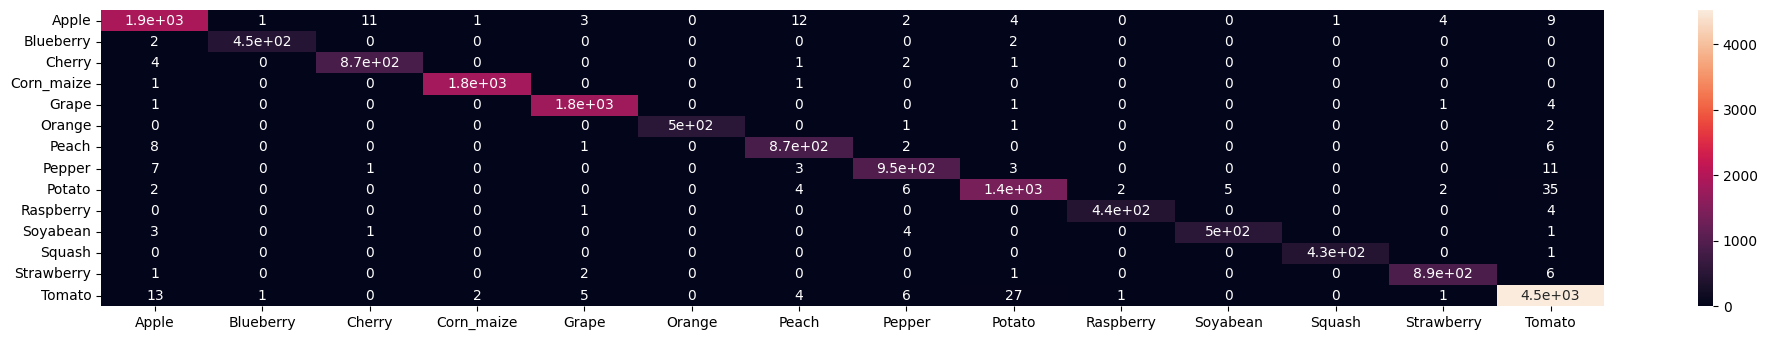

-------------------------------------------------------------------

Diseases Classifaction:
	The accuracy score for the validation dataset is 0.9639
	The balanced accuracy score for the validation dataset is 0.9566
	Classification Report:
                                      precision    recall  f1-score   support

                          Apple_scab       0.96      0.95      0.96       504
                      Bacterial_spot       0.95      0.95      0.95      1362
                           Black_rot       0.97      0.97      0.97       969
                    Cedar_apple_rust       0.98      0.97      0.98       440
 Cercospora_leaf_spot Gray_leaf_spot       0.95      0.94      0.94       410
                         Common_rust       1.00      1.00      1.00       477
                        Early_blight       0.92      0.93      0.92       965
                Esca_(Black_Measles)       0.97      0.98      0.98       480
     Haunglongbing_(Citrus_greening)       1.00      0.99

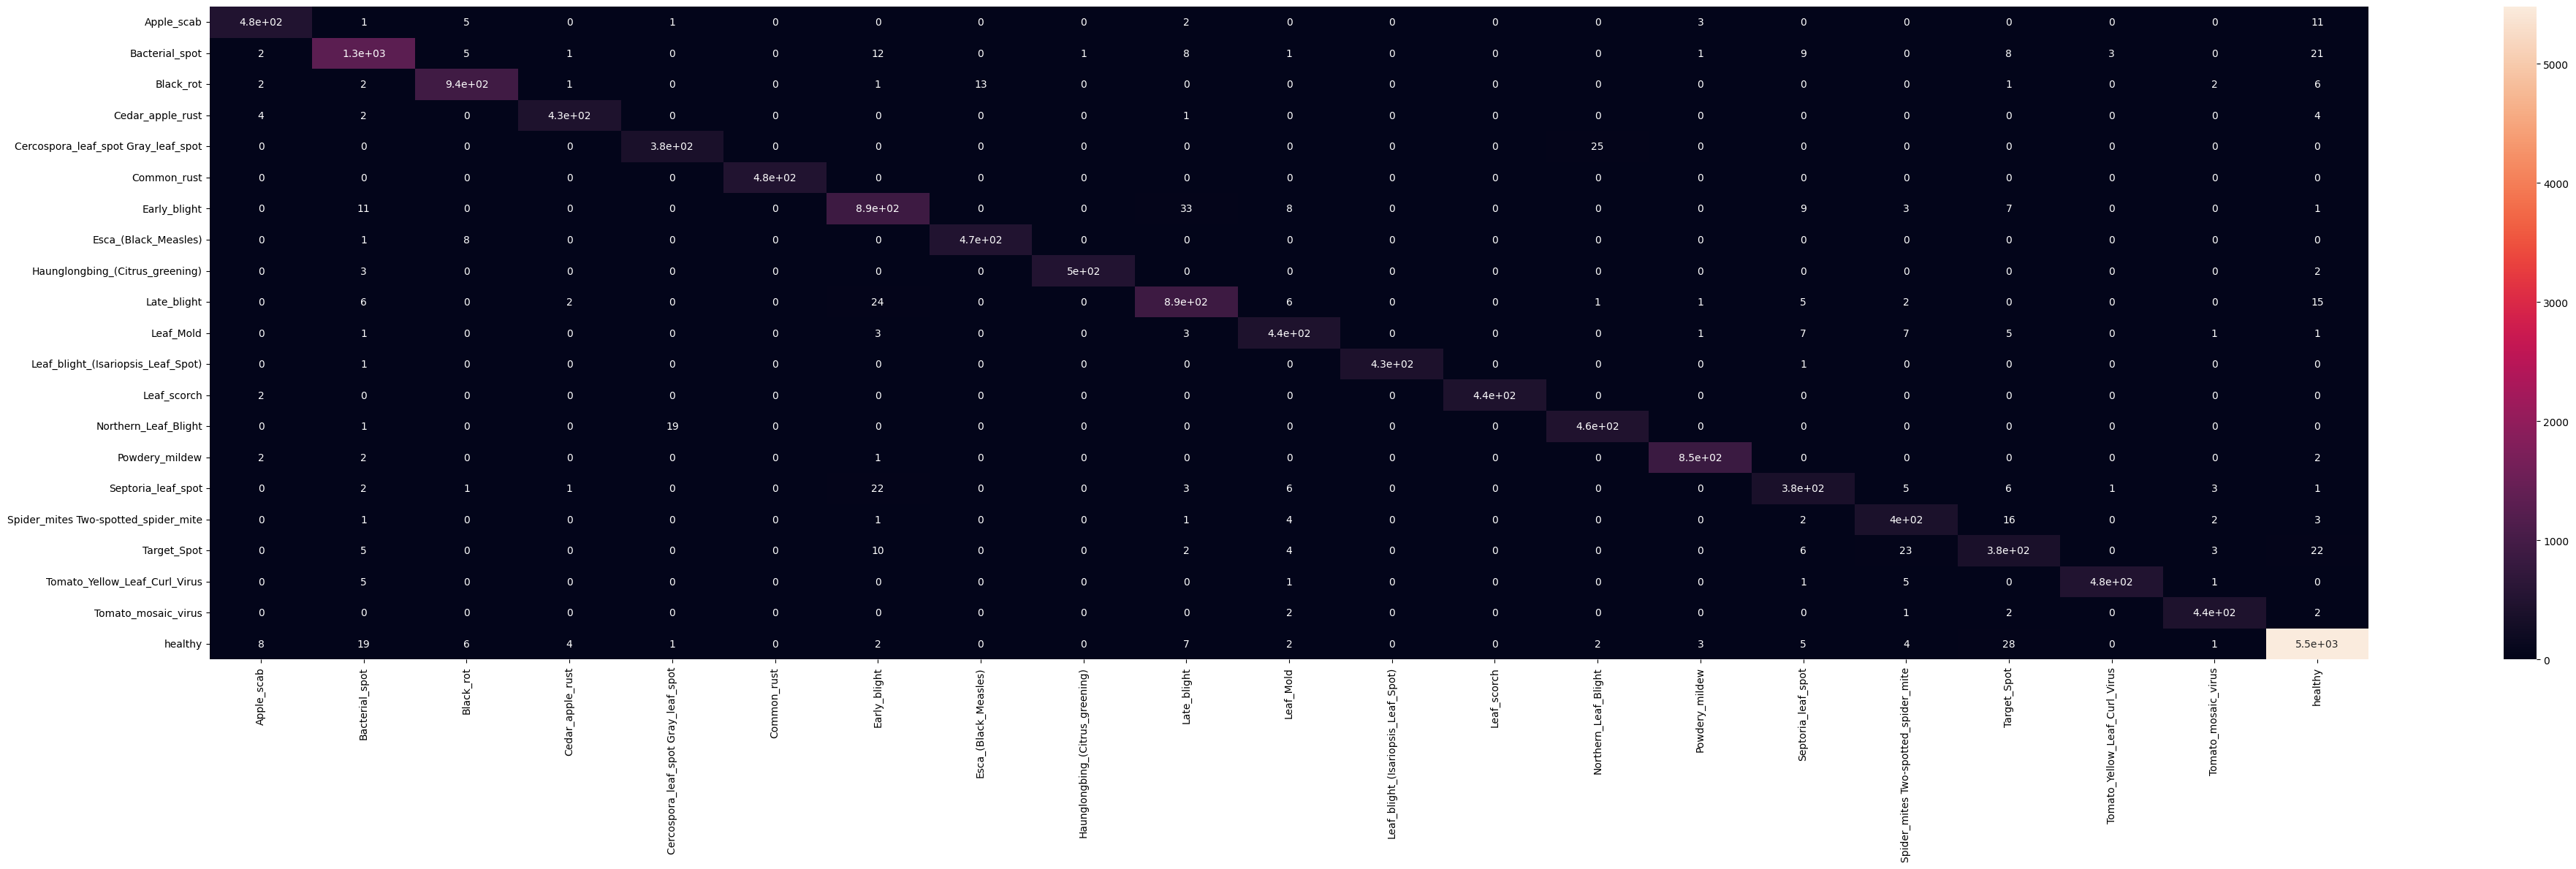

-------------------------------------------------------------------



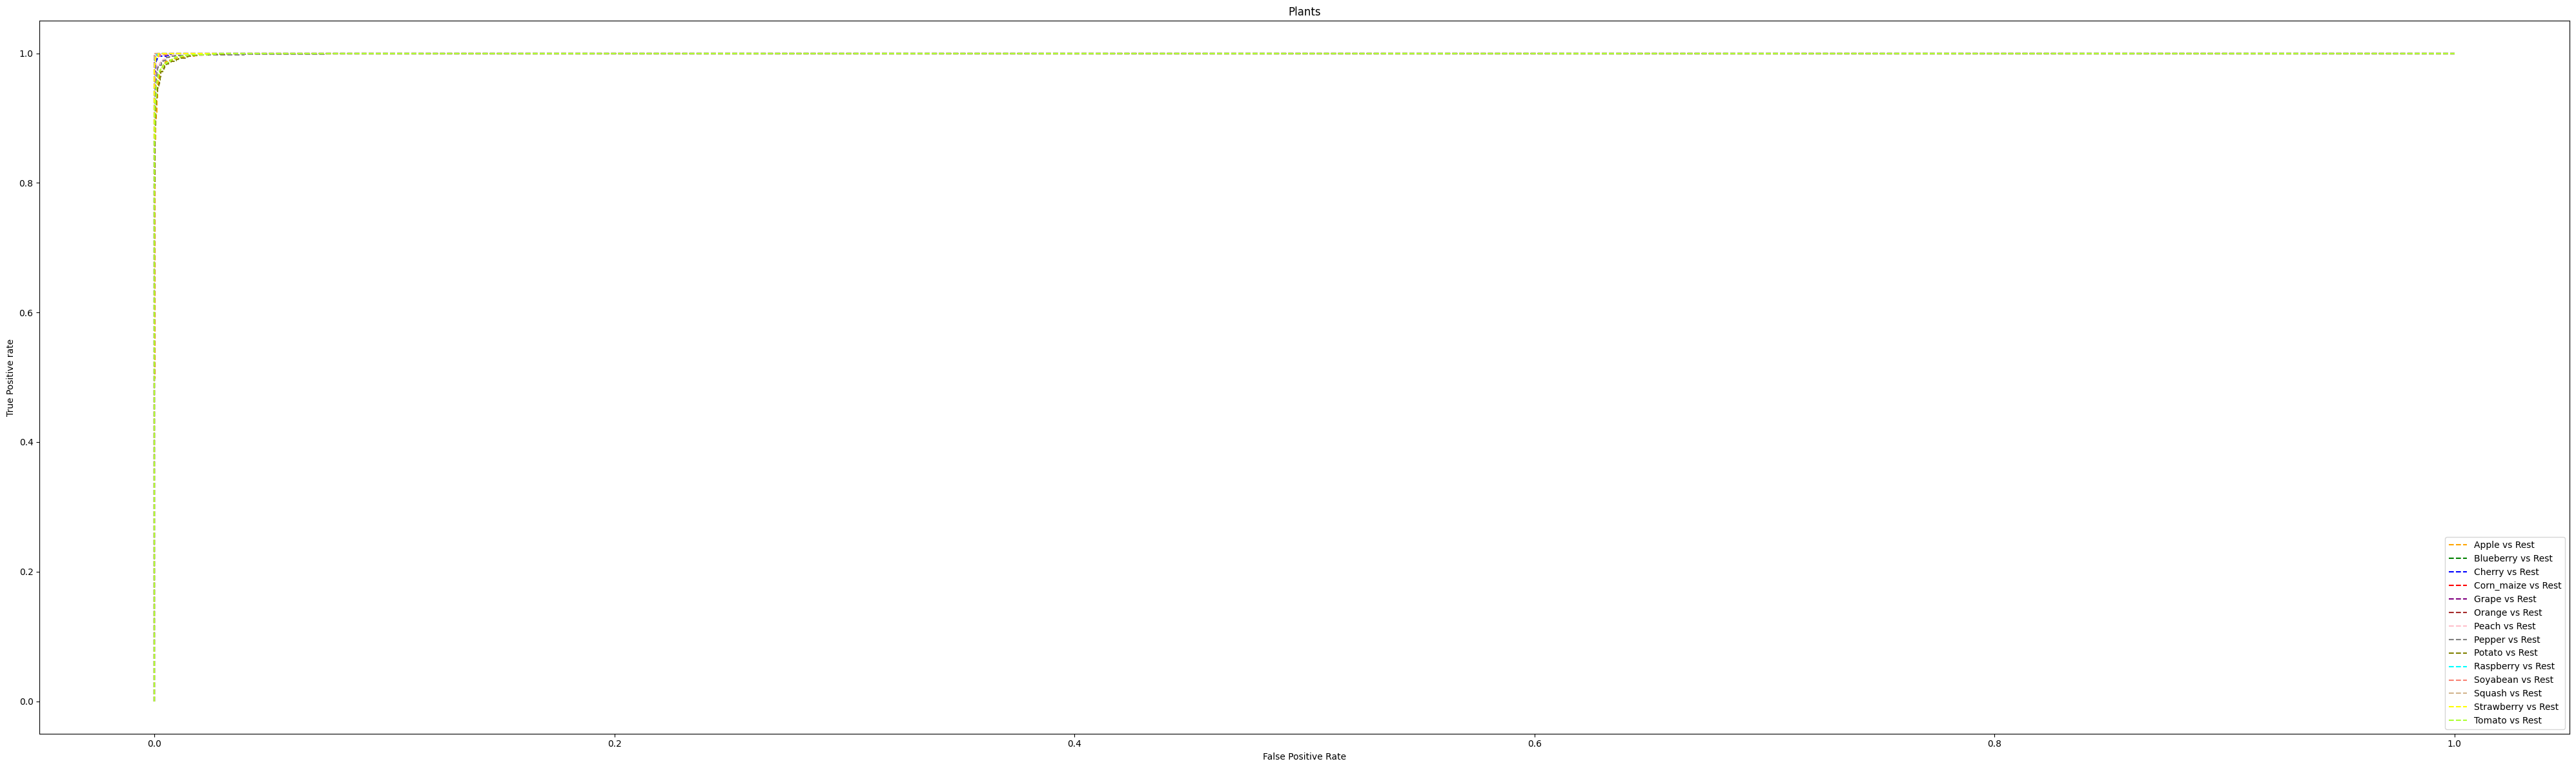

-------------------------------------------------------------------



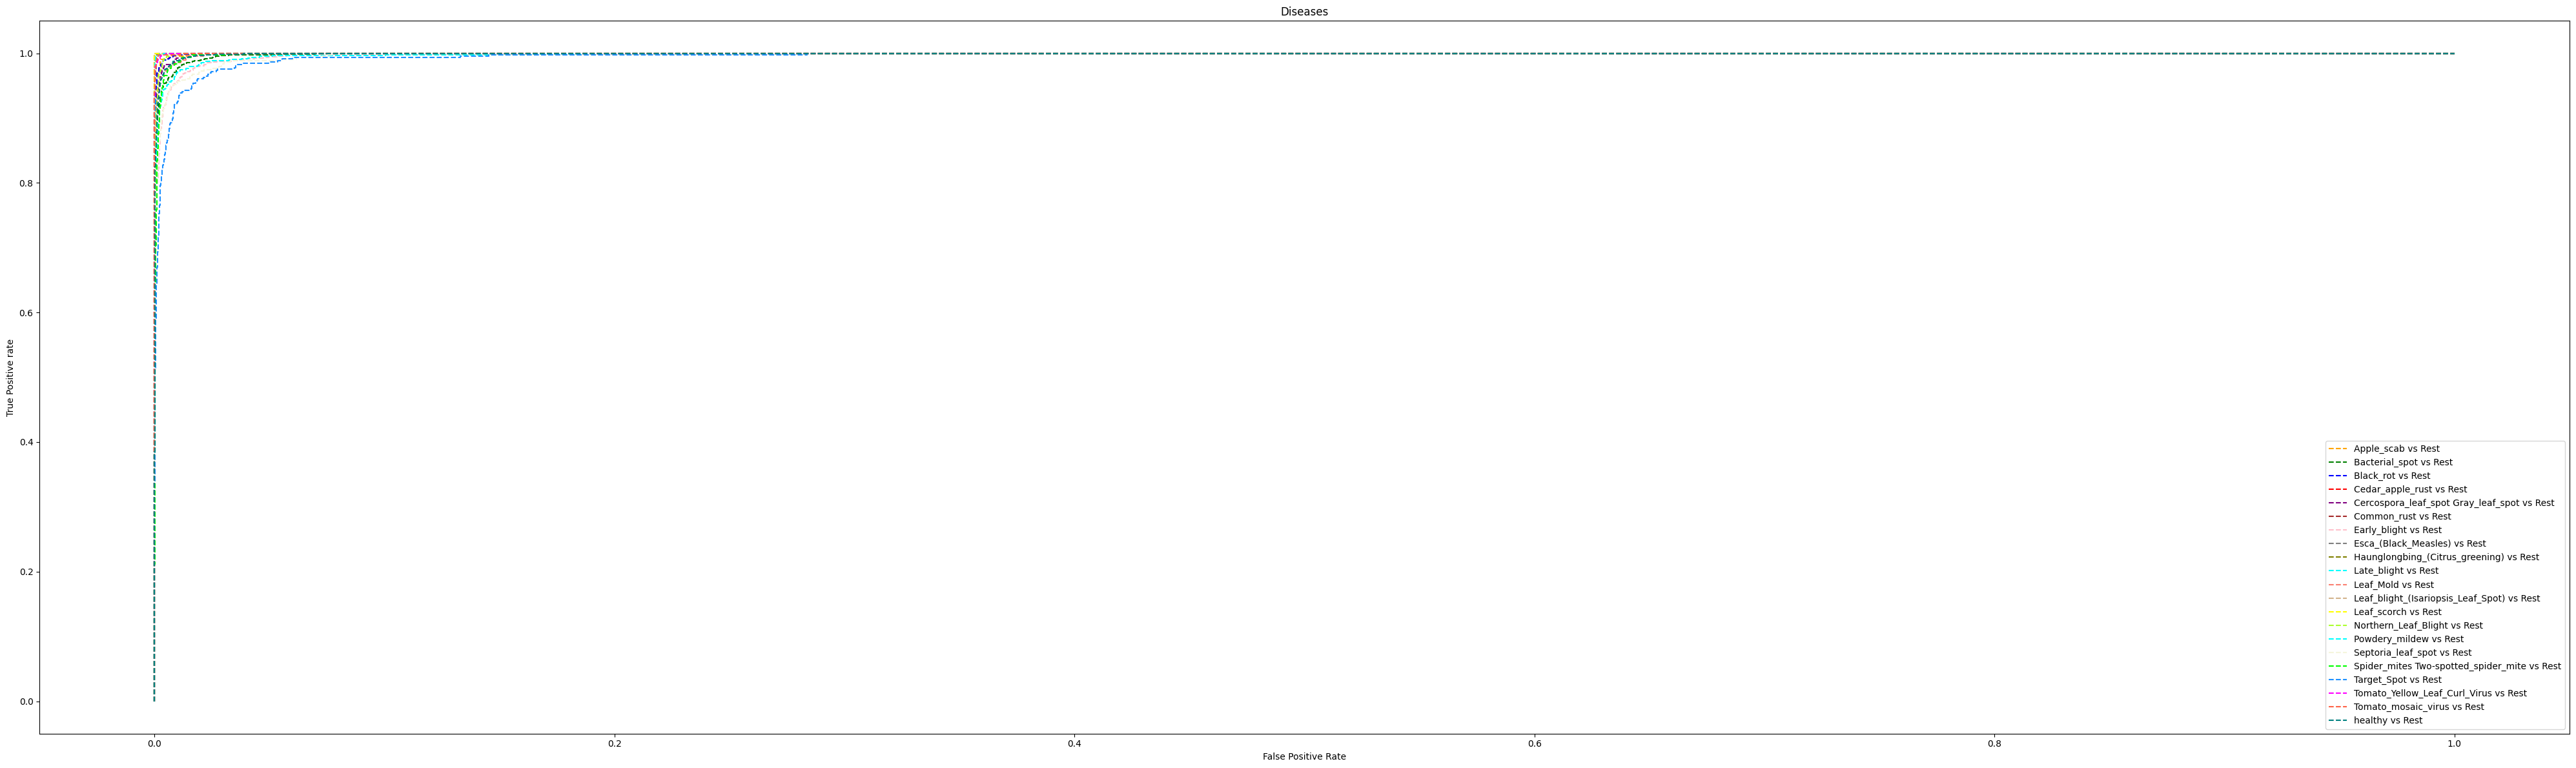

In [ ]:
#function to plot AUC ROC Curve for multi Classification
def plot_auc_roc_multi(y_valid, y_classes, pred_prob2,model_label):
  colors = ['orange','green','blue','red','purple','brown','pink','gray','olive','cyan','salmon','tan','yellow','greenyellow','aqua','beige','lime','dodgerblue','magenta','tomato','teal','silver']
  fpr = {}
  tpr = {}
  thresh ={}
  n_class = len(y_classes)
  for i in range(n_class):    
    fpr[i], tpr[i], thresh[i] = roc_curve(y_valid, pred_prob2[:,i], pos_label=y_classes[i])
    # plotting 
    plt.plot(fpr[i], tpr[i], linestyle='--',color=colors[i], label=y_classes[i] + ' vs Rest')

  plt.title(model_label)
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive rate')
  plt.legend(loc='best')
  plt.show()
  return
#####END of function#############

with open('/content/drive/MyDrive/EE769/L2_regularized_plants_model.bin','rb') as f_in1:
  clf_plants_loaded = pickle.load(f_in1)

with open('/content/drive/MyDrive/EE769/L2_regularized_diseases_model.bin','rb') as f_in2:
  clf_diseases_loaded = pickle.load(f_in2)

plt.rcParams["figure.figsize"] = [20.00, 3.50]
plt.rcParams["figure.autolayout"] = True
y1_valid_predicted = clf_plants_loaded.predict(X1_valid)
confusion_matrix_df = pd.DataFrame(confusion_matrix(y1_valid, y1_valid_predicted), columns=y1_valid_classes, index=y1_valid_classes)
sns.heatmap(confusion_matrix_df, annot=True)
plt.savefig('/content/drive/MyDrive/EE769/L2_Plants.png')

print('Plants Classifaction:')

print(f'\tThe accuracy score for the validation dataset is {accuracy_score(y1_valid, y1_valid_predicted):.4f}')
print(f'\tThe balanced accuracy score for the validation dataset is {balanced_accuracy_score(y1_valid, y1_valid_predicted):.4f}')
pred_prob1 = clf_plants_loaded.predict_proba(X1_valid)
# print(f'\tThe roc_auc score for the validation dataset is {roc_auc_score(y1_valid, pred_prob1,multi_class="ovr"):.4f}')
print('\tClassification Report:')
print(classification_report(y1_valid, y1_valid_predicted))
plt.show()
print('-------------------------------------------------------------------\n')

plt.rcParams["figure.figsize"] = [40.00, 12]
plt.rcParams["figure.autolayout"] = True
y2_valid_predicted = clf_diseases_loaded.predict(X2_valid)
confusion_matrix_df = pd.DataFrame(confusion_matrix(y2_valid, y2_valid_predicted), columns=y2_classes, index=y2_classes)
sns.heatmap(confusion_matrix_df, annot=True)
plt.savefig('/content/drive/MyDrive/EE769/L2_Diseases.png')
print('Diseases Classifaction:')

print(f'\tThe accuracy score for the validation dataset is {accuracy_score(y2_valid, y2_valid_predicted):.4f}')
print(f'\tThe balanced accuracy score for the validation dataset is {balanced_accuracy_score(y2_valid, y2_valid_predicted):.4f}')
pred_prob2 = clf_diseases_loaded.predict_proba(X2_valid)
# print(f'\tThe roc_auc score for the validation dataset is {roc_auc_score(y2_valid, pred_prob2,multi_class="ovr"):.4f}')
print('\tClassification Report:')
print(classification_report(y2_valid, y2_valid_predicted))
plt.show()
print('-------------------------------------------------------------------\n')

plot_auc_roc_multi(y1_valid, y1_classes, pred_prob1,'Plants')
print('-------------------------------------------------------------------\n')
plot_auc_roc_multi(y2_valid, y2_classes, pred_prob2,'Diseases')


## Task-2C: Predictor-1 
###Deployment trail run - L2 regularized logistic regression

1. https://freecontent.manning.com/deploying-machine-learning-models-part-1-saving-models/

In [ ]:
with open('/content/drive/MyDrive/EE769/L2_regularized_plants_model.bin','rb') as f_in1:
  clf_plants_loaded = pickle.load(f_in1)

with open('/content/drive/MyDrive/EE769/L2_regularized_diseases_model.bin','rb') as f_in2:
  clf_diseases_loaded = pickle.load(f_in2)

# print(clf_plants_loaded.get_params())
# print(clf_diseases_loaded.get_params())

#Load the pretrained model
# model = models.resnet18(pretrained=True) #The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
model = models.resnet18(weights=ResNet18_Weights.DEFAULT)
#Use the model object to select the desired layer
layer = model._modules.get('avgpool')
#Set model to evaluation mode
model.eval()
#ResNet-18 expects images to be at least 224x224, as well as normalized with a specific mean and standard deviation
scaler = transforms.Resize((224, 224))
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                std=[0.229, 0.224, 0.225])
to_tensor = transforms.ToTensor()
def extract_ResNet18_features(input_image_path):
  #Load the image with Pillow library
  img = Image.open(input_image_path)
  #Create a PyTorch Variable with the transformed image
  t_img = Variable(normalize(to_tensor(scaler(img))).unsqueeze(0))
  #Create a vector of zeros that will hold our feature vector
    #The 'avgpool' layer has an output size of 512
  features_of_image = torch.zeros(512)
  #Define a function that will copy the output of a layer
  def copy_data(m, i, o):
    features_of_image.copy_(o.data.reshape(o.data.size(1)))
    # features_of_image.copy_(o.data)
  #Attach that function to our selected layer
  h = layer.register_forward_hook(copy_data)
  #Run the model on our transformed image
  model(t_img)
  # Detach our copy function from the layer
  h.remove()
  # Return the feature vector
  return features_of_image

features_list = []
for x in range(512):
  features_list.append(str(x))
  
#input image
input_image = '/content/drive/MyDrive/EE769/project_dataset/test/Apple/Apple_scab/AppleScab2.JPG'
input_data_array = pd.DataFrame([extract_ResNet18_features(input_image).numpy()],columns=features_list)
display(input_data_array)
print('The Predicted plant is '+ str(clf_plants_loaded.predict(input_data_array)[0]) )
print('The Predicted disease is '+ str(clf_diseases_loaded.predict(input_data_array)[0]) )


0         1        2        3         4         5        6  \
0  0.611527  0.787073  0.63086  1.06663  0.712045  0.030071  0.16488   

          7         8         9  ...       502       503       504     505  \
0  0.544176  0.046771  0.879567  ...  0.731227  0.188725  0.202092  2.1628   

        506       507       508       509       510       511  
0  1.647119  0.331114  0.145588  0.064037  0.154471  1.137701  

[1 rows x 512 columns]

The Predicted plant is Apple
The Predicted disease is Apple_scab


## Task-3A: Predictor-2 (Plants Classification)
### Random Forest -  Random Search CV - Training

In [ ]:
#Random Forest

#References:
#1. https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
#2. https://www.geeksforgeeks.org/random-forest-classifier-using-scikit-learn/
#3. https://towardsdatascience.com/bayesian-optimization-for-hyperparameter-tuning-how-and-why-655b0ee0b399


# max_depth_range = np.logspace(0,1,10).astype(int)
max_depth_range = [40]
print(f'The list of values for max_depth are {max_depth_range}')
print('-------------------------------------------------------------------\n')
#Hyperparameter Tuning Using Grid Search
param_grid = { 
    "max_depth": max_depth_range,
    "max_features" : ['sqrt',None]
    # 'max_features' : hp.choice('max_features', ['sqrt','log2',None])
    }

# Set up score
# scoring = ['accuracy']
scoring = {
    'accuracy_score': make_scorer(accuracy_score),
    'balanced_accuracy_score': make_scorer(balanced_accuracy_score),
    # 'recall_score': make_scorer(recall_score)
    # 'precision_score': make_scorer(precision_score)
    # 'roc_auc_score': make_scorer(roc_auc_score)
    'cohen_kappa_score': make_scorer(cohen_kappa_score)
}
# Set up the k-fold cross-validation
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

#Plants Classifaction

clf_plants = RandomForestClassifier(random_state=44)
# Define grid search
grid_search = RandomizedSearchCV(estimator=clf_plants, 
                           param_distributions=param_grid, 
                           scoring=scoring, 
                           refit='accuracy_score', 
                           n_jobs=-1, 
                           cv=kfold, 
                           verbose=True)
# Fit grid search
grid_result = grid_search.fit(X1_train, y1_train.values.ravel())

#For Deployment:
clf_plants = RandomForestClassifier(random_state=44,max_depth=grid_result.best_params_['max_depth'],max_features=grid_result.best_params_['max_features'])
clf_plants.fit(X1_train, y1_train.values.ravel())
with open('/content/drive/MyDrive/EE769/Random_forest_plants_model_Random.bin','wb') as f_out1: #specify the file where you wnt to save
  pickle.dump(clf_plants,f_out1) #Save the model to file with pickle



## Task-3A: Predictor-2 (Diseases Classification) - Part-1
### Random Forest -  Random Search CV - Training

In [ ]:
# warnings.filterwarnings('ignore')
#Random Forest

#References:
#1. https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
#2. https://www.geeksforgeeks.org/random-forest-classifier-using-scikit-learn/
#3. https://towardsdatascience.com/bayesian-optimization-for-hyperparameter-tuning-how-and-why-655b0ee0b399


# max_depth_range = np.logspace(0,1,10).astype(int)
max_depth_range = [40]
print(f'The list of values for max_depth are {max_depth_range}')
print('-------------------------------------------------------------------\n')
#Hyperparameter Tuning Using Grid Search
param_grid = { 
    "max_depth": max_depth_range,
    "max_features" : ['sqrt']
    # 'max_features' : hp.choice('max_features', ['sqrt','log2',None])
    }

# Set up score

# Set up the k-fold cross-validation
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

#Diseases Classifaction
clf_diseases = RandomForestClassifier(random_state=44)
# Define grid search
grid_search = RandomizedSearchCV(estimator=clf_diseases,
                                 param_distributions=param_grid,
                                 scoring='accuracy',
                                 n_jobs=-1,
                                 cv=kfold,
                                 verbose=True)
# Fit grid search
grid_result = grid_search.fit(X2_train, y2_train.values.ravel())

#For Deployment:
clf_diseases = RandomForestClassifier(random_state=44,max_depth=grid_result.best_params_['max_depth'],max_features=grid_result.best_params_['max_features'])
clf_diseases.fit(X2_train, y2_train.values.ravel())
with open('/content/drive/MyDrive/EE769/Random_forest_diseases_model_Random.bin','wb') as f_out2: #specify the file where you wnt to save
  pickle.dump(clf_diseases,f_out2) #Save the model to file with pickle



## Task-3B Predictor-2
### Validation - Random Forest

Plants Classifaction:
	The hyperparameters are {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 40, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 44, 'verbose': 0, 'warm_start': False}
	The accuracy score for the validation dataset is 0.9491
	The balanced accuracy score for the validation dataset is 0.9355
	Classification Report:
              precision    recall  f1-score   support

       Apple       0.90      0.94      0.92      1943
   Blueberry       0.99      0.92      0.95       454
      Cherry       0.98      0.89      0.94       877
  Corn_maize       0.99      1.00      1.00      1829
       Grape       0.98      0.97      0.97      1805
      Orange       0.99      0.96      0.98       503
       Peach       0.96      0.87     

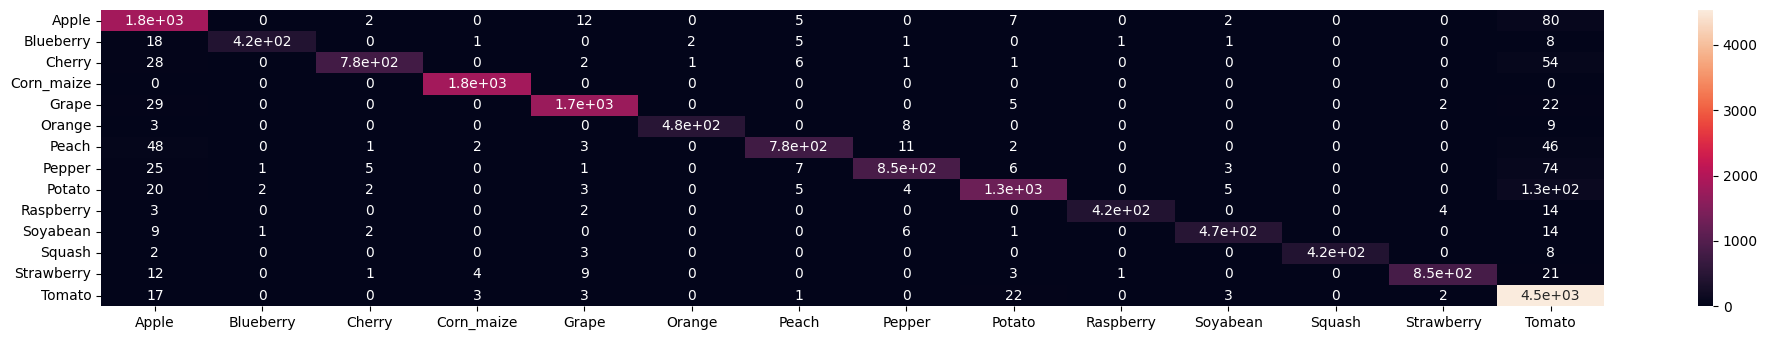

-------------------------------------------------------------------

Diseases Classifaction:
	The hyperparameters are {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 45, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 44, 'verbose': 0, 'warm_start': False}
	The accuracy score for the validation dataset is 0.8808
	The balanced accuracy score for the validation dataset is 0.8274
	Classification Report:
                                      precision    recall  f1-score   support

                          Apple_scab       0.97      0.56      0.71       504
                      Bacterial_spot       0.85      0.90      0.87      1362
                           Black_rot       0.94      0.83      0.88       969
                    Cedar_apple_r

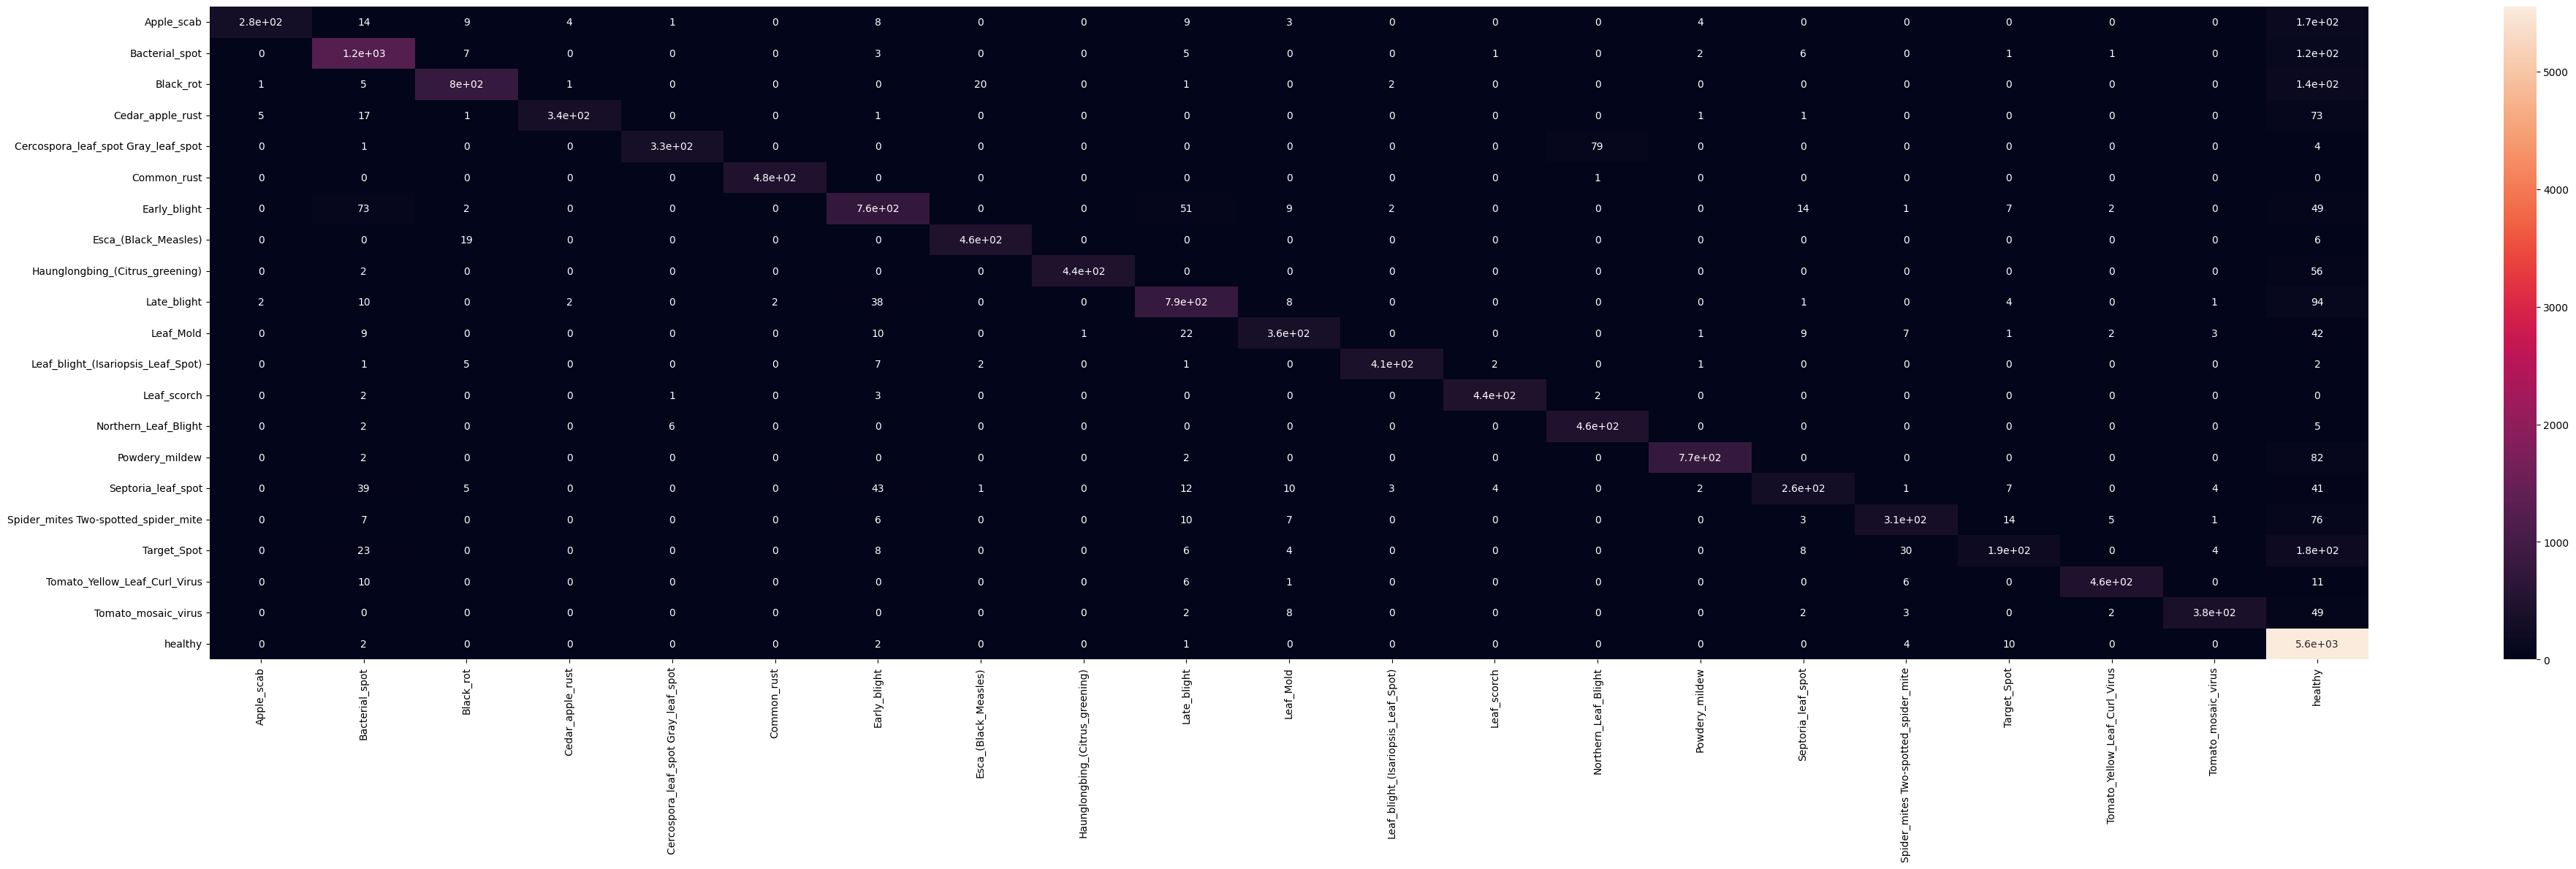

-------------------------------------------------------------------



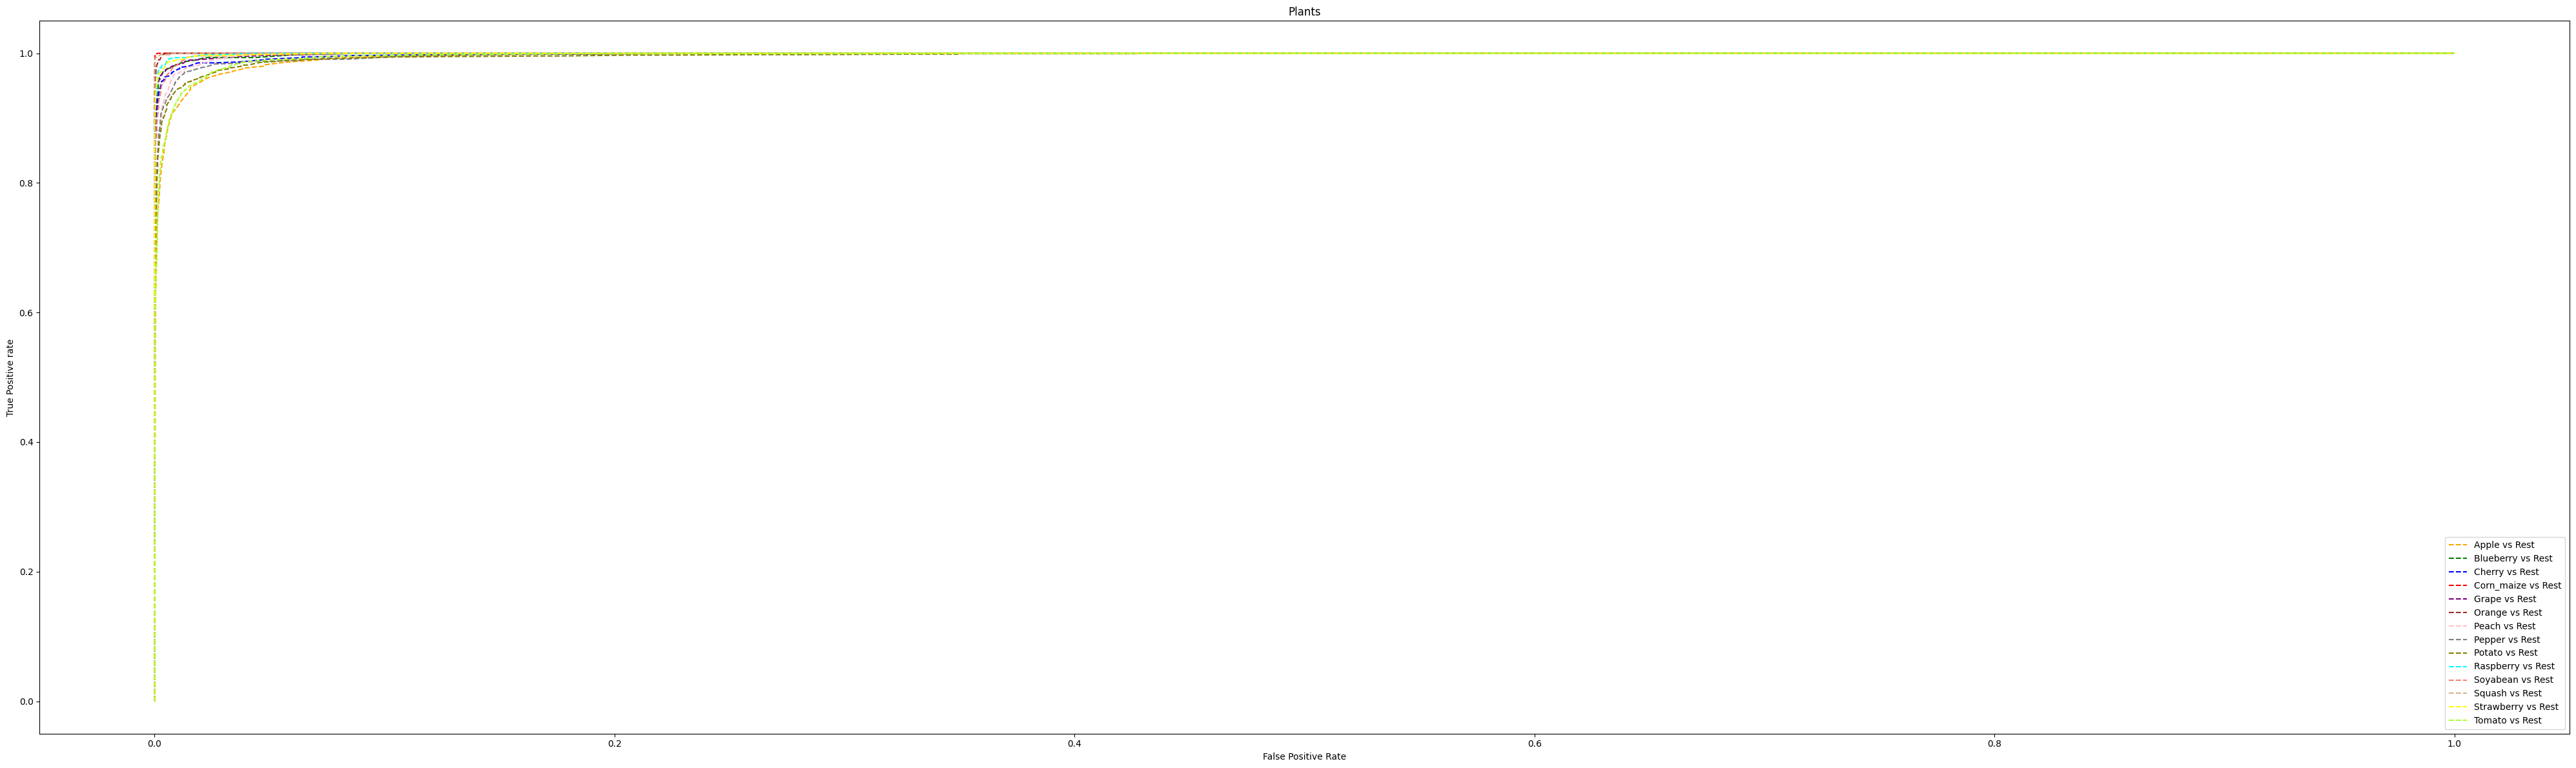

-------------------------------------------------------------------



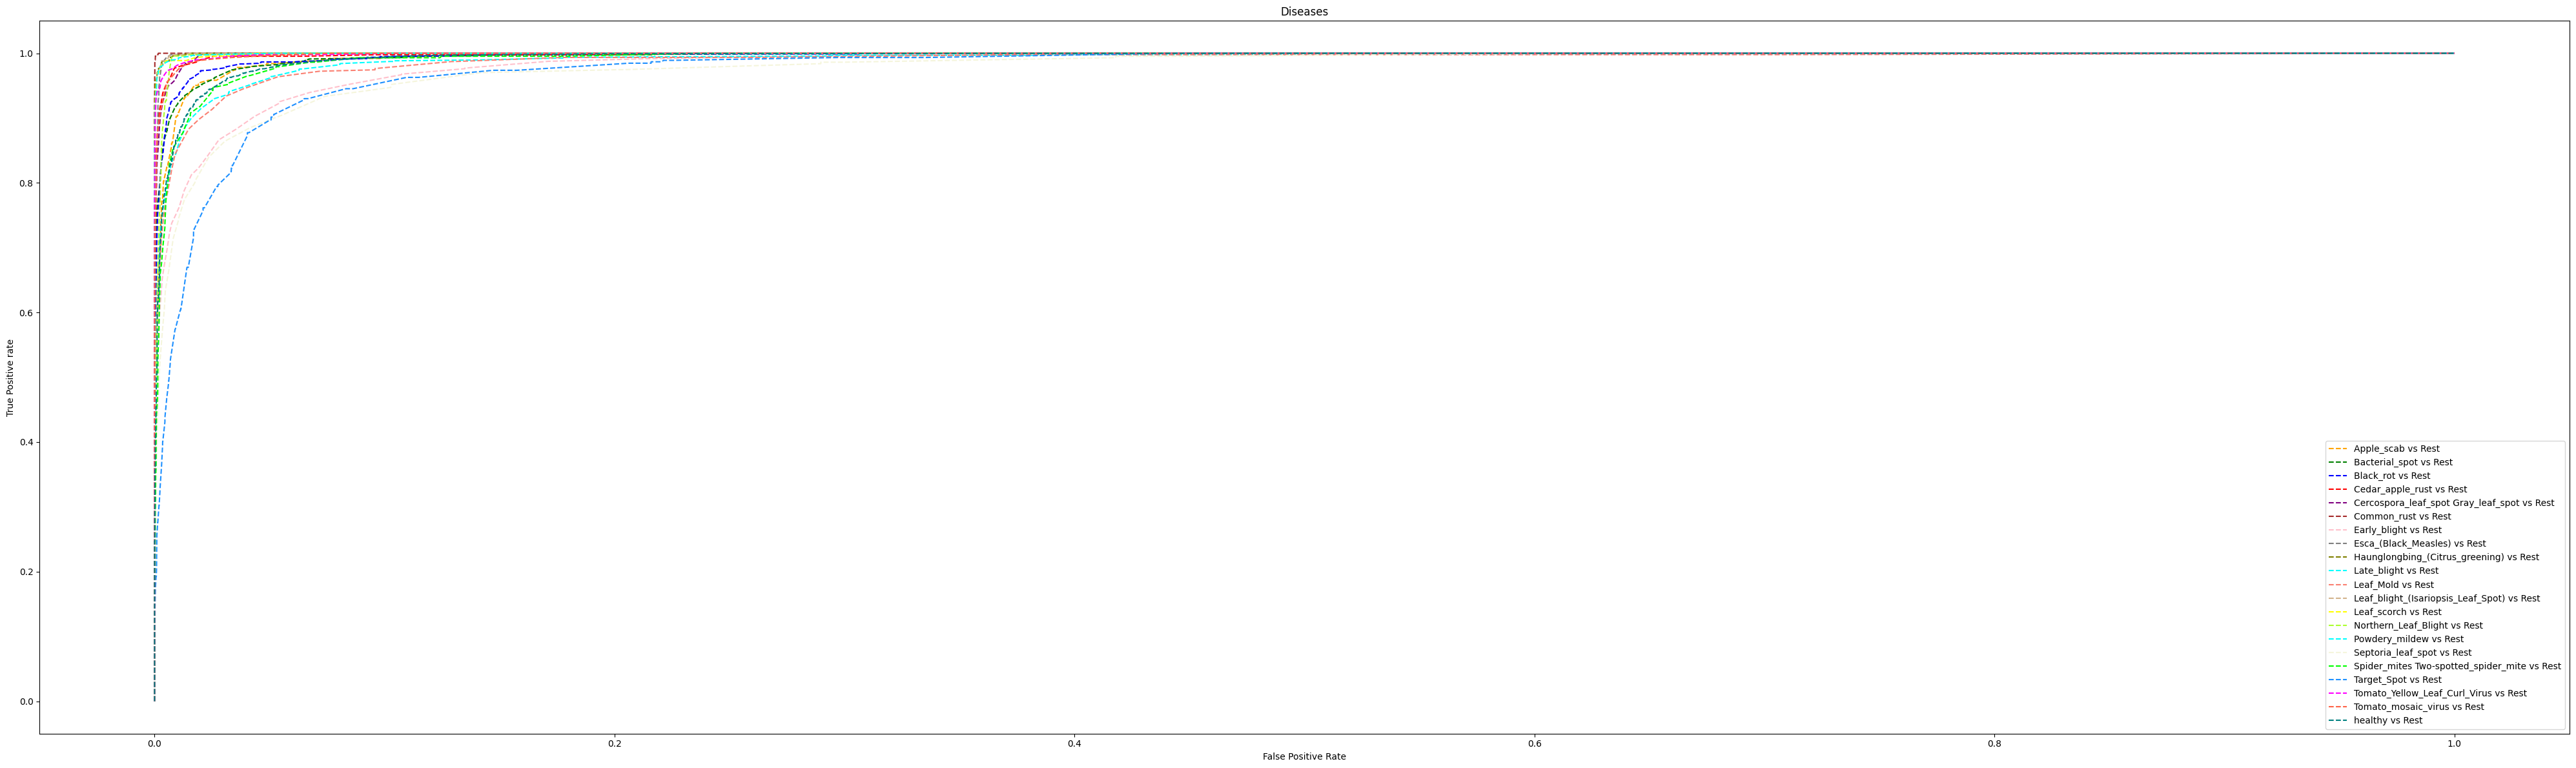

In [ ]:

#function to plot AUC ROC Curve for multi Classification
def plot_auc_roc_multi(y_valid, y_classes, pred_prob2,model_label):
  colors = ['orange','green','blue','red','purple','brown','pink','gray','olive','cyan','salmon','tan','yellow','greenyellow','aqua','beige','lime','dodgerblue','magenta','tomato','teal','silver']
  fpr = {}
  tpr = {}
  thresh ={}
  n_class = len(y_classes)
  for i in range(n_class):    
    fpr[i], tpr[i], thresh[i] = roc_curve(y_valid, pred_prob2[:,i], pos_label=y_classes[i])
    # plotting 
    plt.plot(fpr[i], tpr[i], linestyle='--',color=colors[i], label=y_classes[i] + ' vs Rest')

  plt.title(model_label)
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive rate')
  plt.legend(loc='best')
  plt.show()
  return
#####END of function#############

with open('/content/drive/MyDrive/EE769/Random_forest_plants_model_Random.bin','rb') as f_in1:
  clf_plants_loaded = pickle.load(f_in1)

with open('/content/drive/MyDrive/EE769/Random_forest_diseases_model_Random.bin','rb') as f_in2:
  clf_diseases_loaded = pickle.load(f_in2)

plt.rcParams["figure.figsize"] = [20.00, 3.50]
plt.rcParams["figure.autolayout"] = True
y1_valid_predicted = clf_plants_loaded.predict(X1_valid)
confusion_matrix_df = pd.DataFrame(confusion_matrix(y1_valid, y1_valid_predicted), columns=y1_valid_classes, index=y1_valid_classes)
sns.heatmap(confusion_matrix_df, annot=True)
plt.savefig('/content/drive/MyDrive/EE769/Random_Plants_Random.png')

# grid_result
print('Plants Classifaction:')
# Print the hyperparameters for the best score
print(f'\tThe hyperparameters are {clf_plants_loaded.get_params()}')
# print(f'\tThe best hyperparameters are {grid_result.best_params_}')
print(f'\tThe accuracy score for the validation dataset is {accuracy_score(y1_valid, y1_valid_predicted):.4f}')
print(f'\tThe balanced accuracy score for the validation dataset is {balanced_accuracy_score(y1_valid, y1_valid_predicted):.4f}')
pred_prob1 = clf_plants_loaded.predict_proba(X1_valid)
# print(f'\tThe roc_auc score for the validation dataset is {roc_auc_score(y1_valid, pred_prob1,multi_class="ovr"):.4f}')
print('\tClassification Report:')
print(classification_report(y1_valid, y1_valid_predicted))
plt.show()
print('-------------------------------------------------------------------\n')

plt.rcParams["figure.figsize"] = [40.00, 12]
plt.rcParams["figure.autolayout"] = True
y2_valid_predicted = clf_diseases_loaded.predict(X2_valid)
confusion_matrix_df = pd.DataFrame(confusion_matrix(y2_valid, y2_valid_predicted), columns=y2_valid_classes, index=y2_valid_classes)
sns.heatmap(confusion_matrix_df, annot=True)
plt.savefig('/content/drive/MyDrive/EE769/Random_diseases_Random.png')

# grid_result
print('Diseases Classifaction:')
# Print the hyperparameters for the best score
print(f'\tThe hyperparameters are {clf_diseases_loaded.get_params()}')
print(f'\tThe accuracy score for the validation dataset is {accuracy_score(y2_valid, y2_valid_predicted):.4f}')
print(f'\tThe balanced accuracy score for the validation dataset is {balanced_accuracy_score(y2_valid, y2_valid_predicted):.4f}')
pred_prob2 = clf_diseases_loaded.predict_proba(X2_valid)
# print(f'\tThe roc_auc score for the validation dataset is {roc_auc_score(y1_valid, pred_prob1,multi_class="ovr"):.4f}')
print('\tClassification Report:')
print(classification_report(y2_valid, y2_valid_predicted))
plt.show()

print('-------------------------------------------------------------------\n')
plot_auc_roc_multi(y1_valid, y1_classes, pred_prob1,'Plants')
print('-------------------------------------------------------------------\n')
plot_auc_roc_multi(y2_valid, y2_classes, pred_prob2,'Diseases')



## Task-3C: Predictor-2 
###Deployment trail run -  - Random Forest

1. https://freecontent.manning.com/deploying-machine-learning-models-part-1-saving-models/

In [ ]:

with open('/content/drive/MyDrive/EE769/Random_forest_plants_model_Random.bin','rb') as f_in1:
  clf_plants_loaded = pickle.load(f_in1)

with open('/content/drive/MyDrive/EE769/Random_forest_diseases_model_Random.bin','rb') as f_in2:
  clf_diseases_loaded = pickle.load(f_in2)

# print(clf_plants_loaded.get_params())
# print(clf_diseases_loaded.get_params())

#Load the pretrained model
# model = models.resnet18(pretrained=True) #The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
model = models.resnet18(weights=ResNet18_Weights.DEFAULT)
#Use the model object to select the desired layer
layer = model._modules.get('avgpool')
#Set model to evaluation mode
model.eval()
#ResNet-18 expects images to be at least 224x224, as well as normalized with a specific mean and standard deviation
scaler = transforms.Resize((224, 224))
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                  std=[0.229, 0.224, 0.225])
to_tensor = transforms.ToTensor()
def extract_ResNet18_features(input_image_path):
  #Load the image with Pillow library
  img = Image.open(input_image_path)
  #Create a PyTorch Variable with the transformed image
  t_img = Variable(normalize(to_tensor(scaler(img))).unsqueeze(0))
  #Create a vector of zeros that will hold our feature vector
    #The 'avgpool' layer has an output size of 512
  features_of_image = torch.zeros(512)
  #Define a function that will copy the output of a layer
  def copy_data(m, i, o):
    features_of_image.copy_(o.data.reshape(o.data.size(1)))
    # features_of_image.copy_(o.data)
  #Attach that function to our selected layer
  h = layer.register_forward_hook(copy_data)
  #Run the model on our transformed image
  model(t_img)
  # Detach our copy function from the layer
  h.remove()
  # Return the feature vector
  return features_of_image

features_list = []
for x in range(512):
  features_list.append(str(x))

#input image
input_image = '/content/drive/MyDrive/EE769/project_dataset/test/Apple/Apple_scab/AppleScab1.JPG'
input_data_array = pd.DataFrame([extract_ResNet18_features(input_image).numpy()],columns=features_list)
display(input_data_array)
print('The Predicted plant is '+ str(clf_plants_loaded.predict(input_data_array)[0]) )
print('The Predicted disease is '+ str(clf_diseases_loaded.predict(input_data_array)[0]) )


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


0         1       2         3        4         5         6  \
0  0.113196  1.085623  0.4234  0.379735  0.12552  0.019379  0.026019   

          7         8         9  ...      502       503       504       505  \
0  0.134951  0.058653  0.670229  ...  0.80811  0.078584  0.070219  1.748914   

        506       507       508       509       510       511  
0  2.377569  0.015677  0.654779  0.058494  0.506796  0.832138  

[1 rows x 512 columns]

The Predicted plant is Cherry
The Predicted disease is healthy


## Task-4A: Predictor-3A (Plants Prediction)
### Decision Tree - Random Search CV - Training

In [ ]:
#Decision Tree

#References:
#1. https://towardsdatascience.com/decision-tree-in-python-b433ae57fb93
#2. https://mathtuition88.com/2019/10/11/how-to-save-sklearn-tree-plot-as-file-vector-graphics/

max_depth_range = [18,19,20]
min_samples_split_range = np.logspace(-5, -4, 3, endpoint=True)
min_impurity_decrease_range = np.logspace(-5, -4, 3, endpoint=True)
min_samples_leaf_range = np.logspace(-9, -7, 3, endpoint=True)
max_leaf_nodes_range = [1000,1200,1500]
# min_samples_split_range = np.linspace(0.0001, 0.001, 3, endpoint=True)
print(f'The list of values for max_depth are {max_depth_range}')
print(f'The list of values for min_samples_split are {min_samples_split_range}')
print(f'The list of values for min_impurity_decrease are {min_impurity_decrease_range}')
print(f'The list of values for min_samples_leaf are {min_samples_leaf_range}')
print(f'The list of values for max_leaf_nodes are {max_leaf_nodes_range}')
print('-------------------------------------------------------------------\n')
#Hyperparameter Tuning Using Grid Search
param_grid = { 
    "max_depth": max_depth_range,
    "max_features" : ['sqrt','log2',None],
    "criterion" : ['gini','entropy','log_loss'],
    "min_samples_split" : min_samples_split_range,
    "min_impurity_decrease" : min_impurity_decrease_range,
    "min_samples_leaf" : min_samples_leaf_range,
    "max_leaf_nodes" : max_leaf_nodes_range
    }

# Set up score
scoring = {
    'accuracy_score': make_scorer(accuracy_score),
    'balanced_accuracy_score': make_scorer(balanced_accuracy_score),
    # 'recall_score': make_scorer(recall_score)
    # 'precision_score': make_scorer(precision_score)
    # 'roc_auc_score': make_scorer(roc_auc_score)
    'cohen_kappa_score': make_scorer(cohen_kappa_score)
}
# Set up the k-fold cross-validation
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

clf_plants = DecisionTreeClassifier(random_state=42)

# Define grid search
grid_search = RandomizedSearchCV(estimator=clf_plants, 
                           param_distributions=param_grid, 
                           scoring=scoring, 
                           refit='accuracy_score', 
                           n_jobs=-1, 
                           cv=kfold, 
                           verbose=0)
# Fit grid search
grid_result = grid_search.fit(X1_train, y1_train.values.ravel())

#For Deployment:
clf_plants = DecisionTreeClassifier(random_state=42,
                                    max_depth=grid_result.best_params_['max_depth'],
                                    max_features=grid_result.best_params_['max_features'],
                                    criterion=grid_result.best_params_['criterion'],
                                    min_samples_split=grid_result.best_params_['min_samples_split'],
                                    min_impurity_decrease = grid_result.best_params_['min_impurity_decrease'],
                                    min_samples_leaf = grid_result.best_params_['min_samples_leaf'],
                                    max_leaf_nodes = grid_result.best_params_['max_leaf_nodes'])
clf_plants.fit(X1_train, y1_train.values.ravel())
with open('/content/drive/MyDrive/EE769/Decision_tree_plants_model.bin','wb') as f_out1: #specify the file where you wnt to save
  pickle.dump(clf_plants,f_out1) #Save the model to file with pickle

# #save the actual decision trees produced by our model
# plt.figure(figsize=(80,40))
# tree.plot_tree(clf_plants,filled=True)  
# plt.savefig('/content/drive/MyDrive/EE769/tree_plants.eps',format='eps',bbox_inches = "tight")
# print('-------------------------------------------------------------------\n')
# plt.close()

## Task-4A: Predictor-3A (Diseases Prediction)
### Decision Tree - Random Search CV - Training

In [ ]:
#Decision Tree

#References:
#1. https://towardsdatascience.com/decision-tree-in-python-b433ae57fb93
#2. https://mathtuition88.com/2019/10/11/how-to-save-sklearn-tree-plot-as-file-vector-graphics/

max_depth_range = [18,19,20]
min_samples_split_range = np.logspace(-5, -4, 3, endpoint=True)
min_impurity_decrease_range = np.logspace(-5, -4, 3, endpoint=True)
min_samples_leaf_range = np.logspace(-9, -7, 3, endpoint=True)
max_leaf_nodes_range = [1000,1200,1500]
# min_samples_split_range = np.linspace(0.0001, 0.001, 3, endpoint=True)
print(f'The list of values for max_depth are {max_depth_range}')
print(f'The list of values for min_samples_split are {min_samples_split_range}')
print(f'The list of values for min_impurity_decrease are {min_impurity_decrease_range}')
print(f'The list of values for min_samples_leaf are {min_samples_leaf_range}')
print(f'The list of values for max_leaf_nodes are {max_leaf_nodes_range}')
print('-------------------------------------------------------------------\n')
#Hyperparameter Tuning Using Grid Search
param_grid = { 
    "max_depth": max_depth_range,
    "max_features" : ['sqrt','log2',None],
    "criterion" : ['gini','entropy','log_loss'],
    "min_samples_split" : min_samples_split_range,
    "min_impurity_decrease" : min_impurity_decrease_range,
    "min_samples_leaf" : min_samples_leaf_range,
    "max_leaf_nodes" : max_leaf_nodes_range
    }

# Set up score
scoring = {
    'accuracy_score': make_scorer(accuracy_score),
    'balanced_accuracy_score': make_scorer(balanced_accuracy_score),
    # 'recall_score': make_scorer(recall_score)
    # 'precision_score': make_scorer(precision_score)
    # 'roc_auc_score': make_scorer(roc_auc_score)
    'cohen_kappa_score': make_scorer(cohen_kappa_score)
}
# Set up the k-fold cross-validation
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

clf_diseases = DecisionTreeClassifier(random_state=42)

# Define grid search
grid_search = RandomizedSearchCV(estimator=clf_diseases, 
                           param_distributions=param_grid, 
                           scoring=scoring, 
                           refit='accuracy_score', 
                           n_jobs=-1, 
                           cv=kfold, 
                           verbose=0)
# Fit grid search
grid_result = grid_search.fit(X2_train, y2_train.values.ravel())

#For Deployment:
clf_diseases = DecisionTreeClassifier(random_state=42,
                                    max_depth=grid_result.best_params_['max_depth'],
                                    max_features=grid_result.best_params_['max_features'],
                                    criterion=grid_result.best_params_['criterion'],
                                    min_samples_split=grid_result.best_params_['min_samples_split'],
                                    min_impurity_decrease = grid_result.best_params_['min_impurity_decrease'],
                                    min_samples_leaf = grid_result.best_params_['min_samples_leaf'],
                                    max_leaf_nodes = grid_result.best_params_['max_leaf_nodes'])
clf_diseases.fit(X2_train, y2_train.values.ravel())
with open('/content/drive/MyDrive/EE769/Decision_tree_diseases_model.bin','wb') as f_out2: #specify the file where you wnt to save
  pickle.dump(clf_diseases,f_out2) #Save the model to file with pickle

# #save the actual decision trees produced by our model
# plt.figure(figsize=(80,40))
# tree.plot_tree(clf_diseases,filled=True)  
# plt.savefig('/content/drive/MyDrive/EE769/tree_diseases.eps',format='eps',bbox_inches = "tight")
# plt.close()

## Task-4B Predictor-3A
### Validation - Decision Tree

Plants Classifaction:
	The hyperparameters are {'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'log_loss', 'max_depth': 20, 'max_features': None, 'max_leaf_nodes': 1500, 'min_impurity_decrease': 1e-05, 'min_samples_leaf': 1e-07, 'min_samples_split': 3.1622776601683795e-05, 'min_weight_fraction_leaf': 0.0, 'random_state': 42, 'splitter': 'best'}
	The accuracy score for the validation dataset is 0.7575
	The balanced accuracy score for the validation dataset is 0.7284
	Classification Report:
              precision    recall  f1-score   support

       Apple       0.59      0.65      0.62      1943
   Blueberry       0.71      0.64      0.67       454
      Cherry       0.65      0.64      0.64       877
  Corn_maize       0.92      0.92      0.92      1829
       Grape       0.84      0.85      0.85      1805
      Orange       0.82      0.77      0.80       503
       Peach       0.68      0.62      0.65       891
      Pepper       0.65      0.66      0.66       975
      Potato 

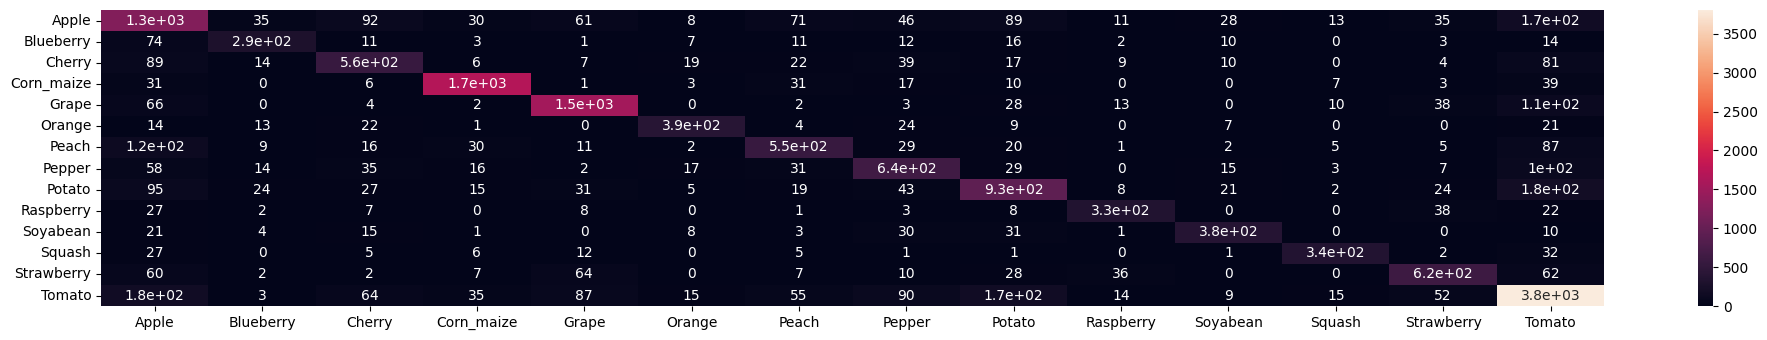

-------------------------------------------------------------------

Diseases Classifaction:
	The hyperparameters are {'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'log_loss', 'max_depth': 18, 'max_features': None, 'max_leaf_nodes': 1200, 'min_impurity_decrease': 3.1622776601683795e-05, 'min_samples_leaf': 1e-09, 'min_samples_split': 1e-05, 'min_weight_fraction_leaf': 0.0, 'random_state': 42, 'splitter': 'best'}
	The accuracy score for the validation dataset is 0.6807
	The balanced accuracy score for the validation dataset is 0.6073
	Classification Report:
                                      precision    recall  f1-score   support

                          Apple_scab       0.48      0.48      0.48       504
                      Bacterial_spot       0.55      0.62      0.59      1362
                           Black_rot       0.62      0.61      0.62       969
                    Cedar_apple_rust       0.56      0.54      0.55       440
 Cercospora_leaf_spot Gray_leaf_spot  

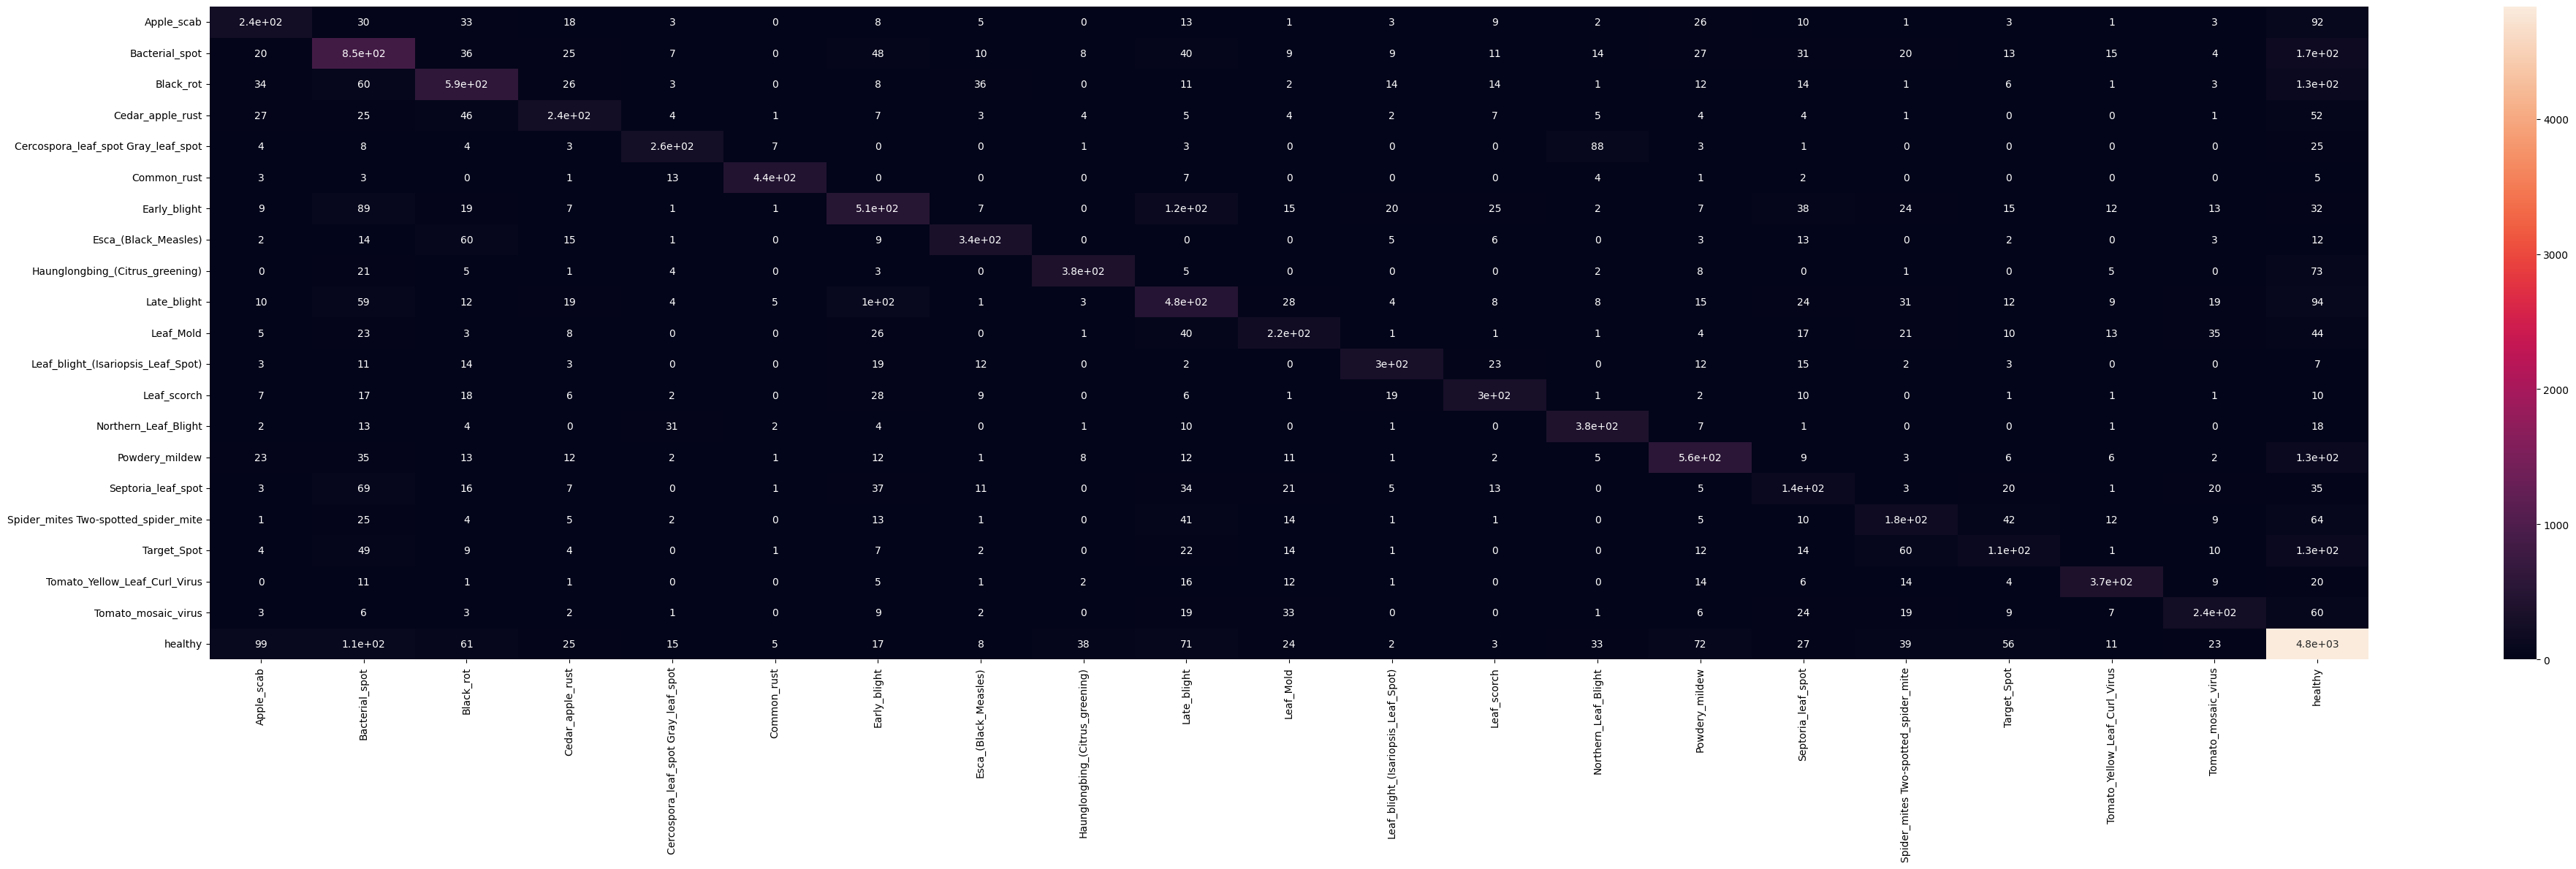

-------------------------------------------------------------------



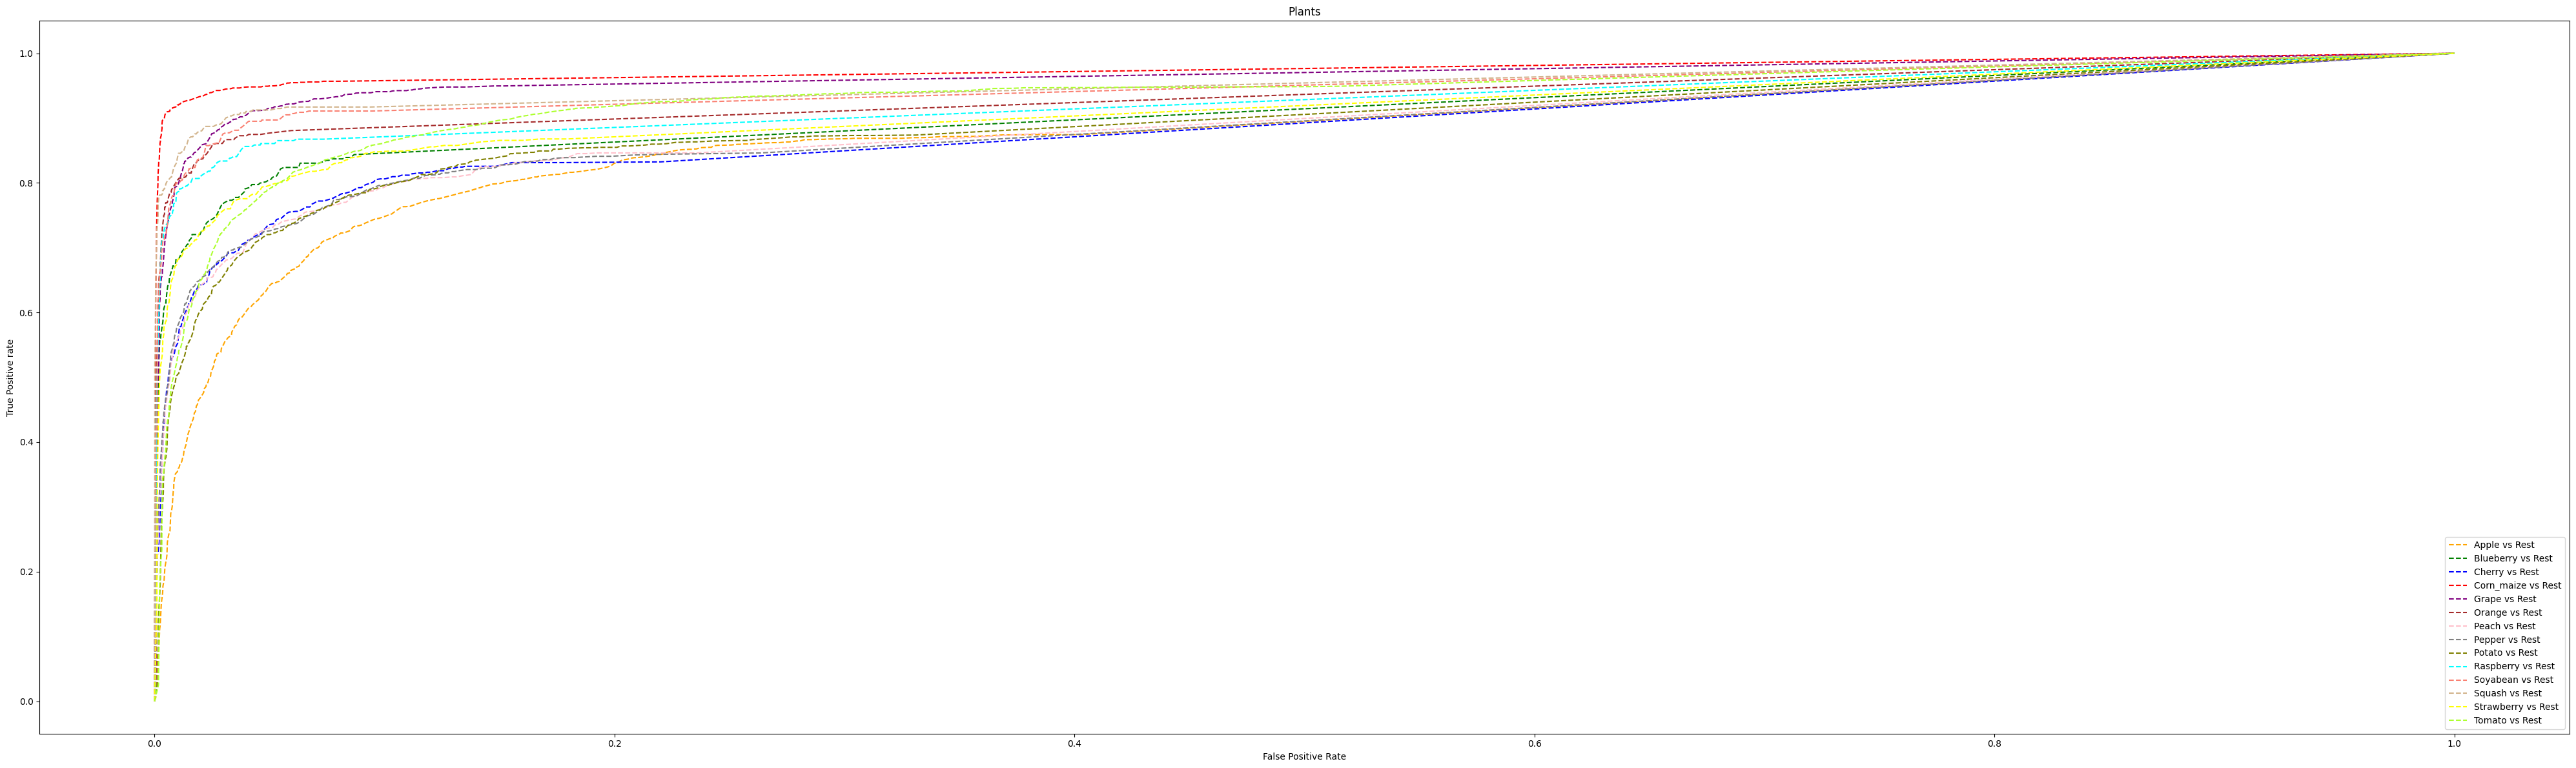

-------------------------------------------------------------------



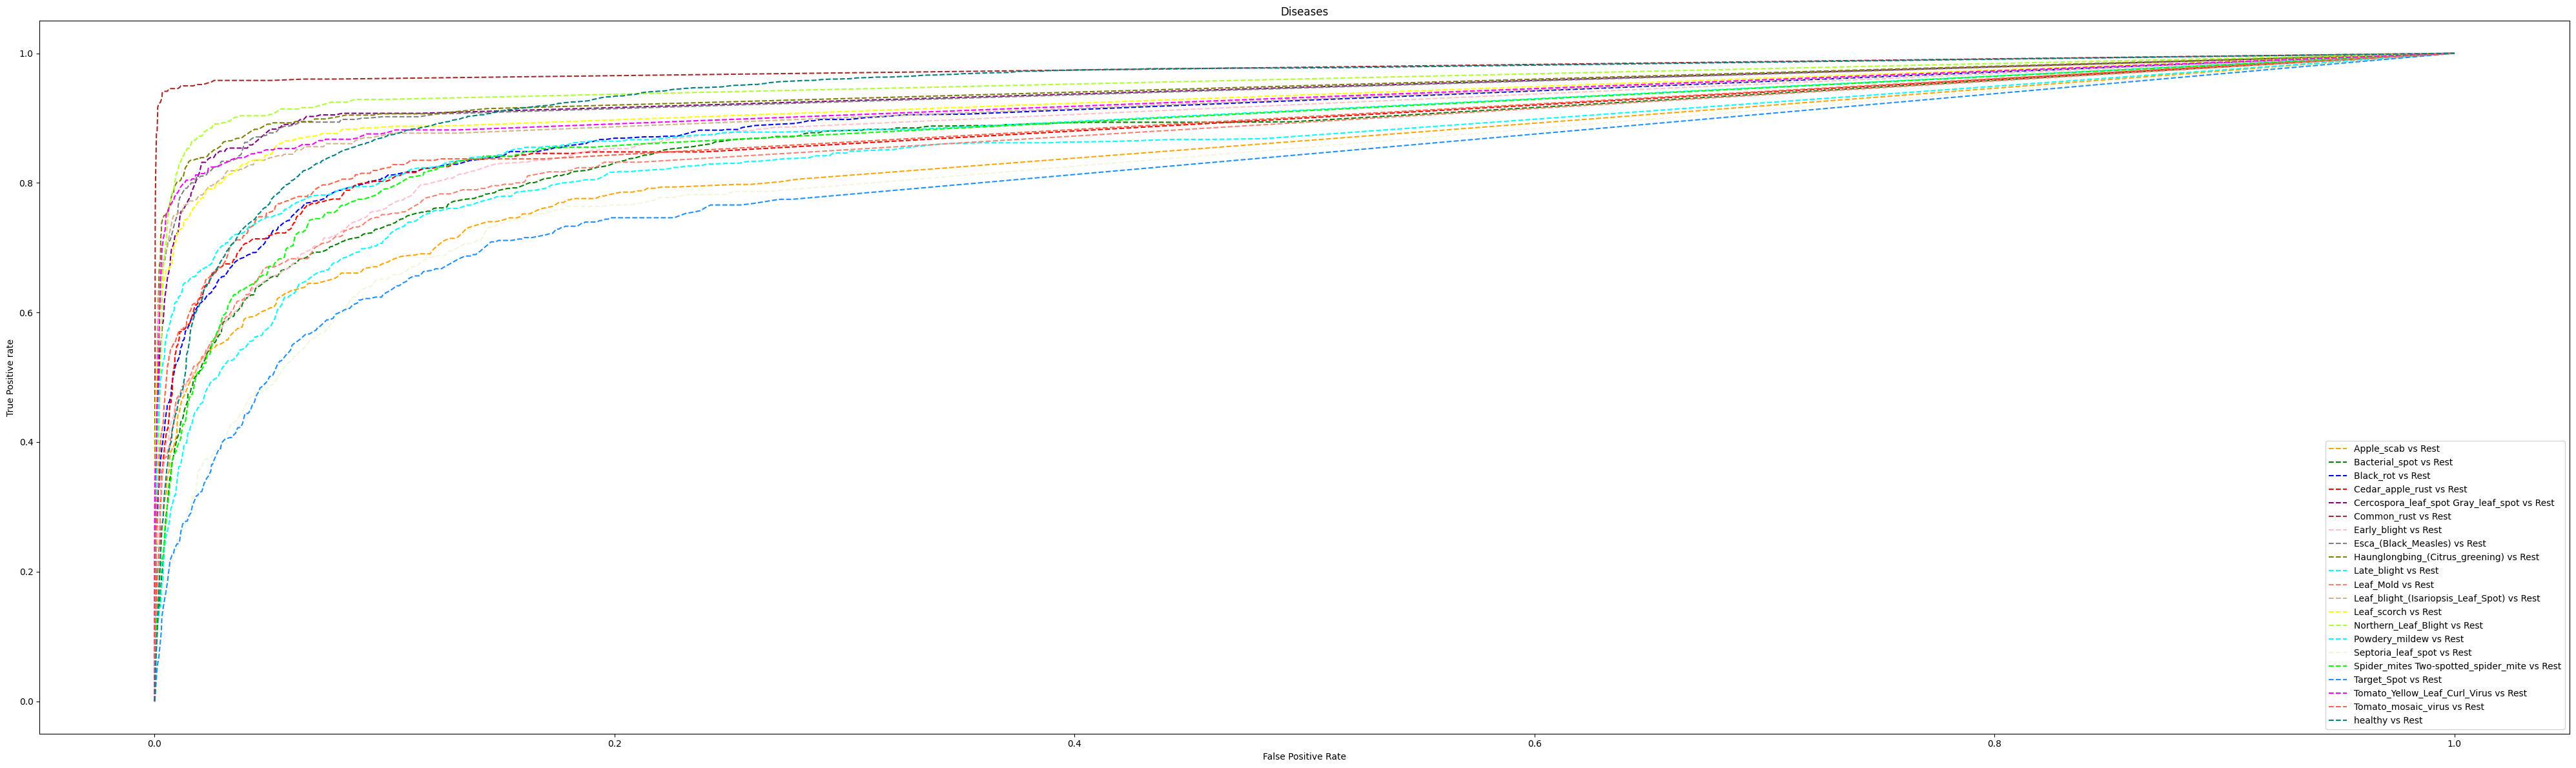

-------------------------------------------------------------------



In [ ]:
#function to plot AUC ROC Curve for multi Classification
def plot_auc_roc_multi(y_valid, y_classes, pred_prob2,model_label):
  colors = ['orange','green','blue','red','purple','brown','pink','gray','olive','cyan','salmon','tan','yellow','greenyellow','aqua','beige','lime','dodgerblue','magenta','tomato','teal','silver']
  fpr = {}
  tpr = {}
  thresh ={}
  n_class = len(y_classes)
  for i in range(n_class):    
    fpr[i], tpr[i], thresh[i] = roc_curve(y_valid, pred_prob2[:,i], pos_label=y_classes[i])
    # plotting 
    plt.plot(fpr[i], tpr[i], linestyle='--',color=colors[i], label=y_classes[i] + ' vs Rest')

  plt.title(model_label)
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive rate')
  plt.legend(loc='best')
  plt.show()
  return
#####END of function#############

with open('/content/drive/MyDrive/EE769/Decision_tree_plants_model.bin','rb') as f_in1:
  clf_plants_loaded = pickle.load(f_in1)

with open('/content/drive/MyDrive/EE769/Decision_tree_diseases_model.bin','rb') as f_in2:
  clf_diseases_loaded = pickle.load(f_in2)


plt.rcParams["figure.figsize"] = [20.00, 3.50]
plt.rcParams["figure.autolayout"] = True
y1_valid_predicted = clf_plants_loaded.predict(X1_valid)
confusion_matrix_df = pd.DataFrame(confusion_matrix(y1_valid, y1_valid_predicted), columns=y1_valid_classes, index=y1_valid_classes)
sns.heatmap(confusion_matrix_df, annot=True)
plt.savefig('/content/drive/MyDrive/EE769/Decision_tree_Plants.png')

print('Plants Classifaction:')
print(f'\tThe hyperparameters are {clf_plants_loaded.get_params()}')
print(f'\tThe accuracy score for the validation dataset is {accuracy_score(y1_valid, y1_valid_predicted):.4f}')
print(f'\tThe balanced accuracy score for the validation dataset is {balanced_accuracy_score(y1_valid, y1_valid_predicted):.4f}')
pred_prob1 = clf_plants_loaded.predict_proba(X1_valid)
# print(f'\tThe roc_auc score for the validation dataset is {roc_auc_score(y1_valid, pred_prob1,multi_class="ovr"):.4f}')
print('\tClassification Report:')
print(classification_report(y1_valid, y1_valid_predicted))
plt.show()
print('-------------------------------------------------------------------\n')

plt.rcParams["figure.figsize"] = [40.00, 12]
plt.rcParams["figure.autolayout"] = True
y2_valid_predicted = clf_diseases_loaded.predict(X2_valid)
confusion_matrix_df = pd.DataFrame(confusion_matrix(y2_valid, y2_valid_predicted), columns=y2_classes, index=y2_classes)
sns.heatmap(confusion_matrix_df, annot=True)
plt.savefig('/content/drive/MyDrive/EE769/Decision_tree_Diseases.png')

print('Diseases Classifaction:')
print(f'\tThe hyperparameters are {clf_diseases_loaded.get_params()}')
print(f'\tThe accuracy score for the validation dataset is {accuracy_score(y2_valid, y2_valid_predicted):.4f}')
print(f'\tThe balanced accuracy score for the validation dataset is {balanced_accuracy_score(y2_valid, y2_valid_predicted):.4f}')
pred_prob2 = clf_diseases_loaded.predict_proba(X2_valid)
# print(f'\tThe roc_auc score for the validation dataset is {roc_auc_score(y2_valid, pred_prob2,multi_class="ovr"):.4f}')
print('\tClassification Report:')
print(classification_report(y2_valid, y2_valid_predicted))
plt.show()
print('-------------------------------------------------------------------\n')


plot_auc_roc_multi(y1_valid, y1_classes, pred_prob1,'Plants')
print('-------------------------------------------------------------------\n')
plot_auc_roc_multi(y2_valid, y2_classes, pred_prob2,'Diseases')
print('-------------------------------------------------------------------\n')



## Task-4C Predictor-3A
###Deployment trail run - Decision Tree

1. https://freecontent.manning.com/deploying-machine-learning-models-part-1-saving-models/

In [ ]:
# import pandas as pd
# import numpy as np
# from sklearn.ensemble import RandomForestClassifier
# import pickle

# import torchvision.models as models
# import torchvision.transforms as transforms
# import torch
# from torch.autograd import Variable
# from PIL import Image
# from torchvision.models import ResNet18_Weights
# import warnings
# import time
# import os
# import copy
# from google.colab import drive
# drive.mount('/content/drive')

with open('/content/drive/MyDrive/EE769/Decision_tree_plants_model.bin','rb') as f_in1:
  clf_plants_loaded = pickle.load(f_in1)

with open('/content/drive/MyDrive/EE769/Decision_tree_diseases_model.bin','rb') as f_in2:
  clf_diseases_loaded = pickle.load(f_in2)

# print(clf_plants_loaded.get_params())
# print(clf_diseases_loaded.get_params())

#Load the pretrained model
# model = models.resnet18(pretrained=True) #The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
model = models.resnet18(weights=ResNet18_Weights.DEFAULT)
#Use the model object to select the desired layer
layer = model._modules.get('avgpool')
#Set model to evaluation mode
model.eval()
#ResNet-18 expects images to be at least 224x224, as well as normalized with a specific mean and standard deviation
scaler = transforms.Resize((224, 224))
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                  std=[0.229, 0.224, 0.225])
to_tensor = transforms.ToTensor()
def extract_ResNet18_features(input_image_path):
  #Load the image with Pillow library
  img = Image.open(input_image_path)
  #Create a PyTorch Variable with the transformed image
  t_img = Variable(normalize(to_tensor(scaler(img))).unsqueeze(0))
  #Create a vector of zeros that will hold our feature vector
    #The 'avgpool' layer has an output size of 512
  features_of_image = torch.zeros(512)
  #Define a function that will copy the output of a layer
  def copy_data(m, i, o):
    features_of_image.copy_(o.data.reshape(o.data.size(1)))
    # features_of_image.copy_(o.data)
  #Attach that function to our selected layer
  h = layer.register_forward_hook(copy_data)
  #Run the model on our transformed image
  model(t_img)
  # Detach our copy function from the layer
  h.remove()
  # Return the feature vector
  return features_of_image

features_list = []
for x in range(512):
  features_list.append(str(x))

#input image
input_image = '/content/drive/MyDrive/EE769/project_dataset/test/Apple/Apple_scab/AppleScab1.JPG'
input_data_array = pd.DataFrame([extract_ResNet18_features(input_image).numpy()],columns=features_list)
display(input_data_array)
print('The Predicted plant is '+ str(clf_plants_loaded.predict(input_data_array)[0]) )
print('The Predicted disease is '+ str(clf_diseases_loaded.predict(input_data_array)[0]) )


## Task-5A: Predictor-3B (Plants Prediction)
### Adaboost - Decision Tree - Random Search CV - Training

In [ ]:
#References:
#1.https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html

#Adaboost-Decision tree
with open('/content/drive/MyDrive/EE769/Decision_tree_plants_model.bin','rb') as f_in1:
  clf_plants_loaded = pickle.load(f_in1)

print(clf_plants_loaded.get_params())

n_estimators_range = [50,75,100,150,200]
learning_rate_range = [0.1,0.2,0.4,0.8,1.0]

print(f'The list of values for n_estimators are {n_estimators_range}')
print(f'The list of values for learning_rate are {learning_rate_range}')
print('-------------------------------------------------------------------\n')
#Hyperparameter Tuning Using Grid Search
param_grid = { 
    "n_estimators": n_estimators_range,
    "learning_rate" : learning_rate_range
    }

# Set up score
scoring = {
    'accuracy_score': make_scorer(accuracy_score),
    'balanced_accuracy_score': make_scorer(balanced_accuracy_score),
    # 'recall_score': make_scorer(recall_score)
    # 'precision_score': make_scorer(precision_score)
    # 'roc_auc_score': make_scorer(roc_auc_score)
    'cohen_kappa_score': make_scorer(cohen_kappa_score)
}
# Set up the k-fold cross-validation
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

clf_plants = AdaBoostClassifier(random_state=42,estimator=clf_plants_loaded)

# Define grid search
grid_search = RandomizedSearchCV(estimator=clf_plants, 
                           param_distributions=param_grid, 
                           scoring=scoring, 
                           refit='accuracy_score', 
                           n_jobs=-1, 
                           cv=kfold, 
                           verbose=0)
# Fit grid search
grid_result = grid_search.fit(X1_train, y1_train.values.ravel())

# For Deployment:
clf_plants = DecisionTreeClassifier(random_state=42,
                                    estimator=clf_plants_loaded,
                                    n_estimators=grid_result.best_params_['n_estimators'],
                                    learning_rate=grid_result.best_params_['learning_rate'])
clf_plants.fit(X1_train, y1_train.values.ravel())
with open('/content/drive/MyDrive/EE769/Adaboost_Decision_tree_plants_model.bin','wb') as f_out1: #specify the file where you wnt to save
  pickle.dump(clf_plants,f_out1) #Save the model to file with pickle


## Task-5A: Predictor-3B (Diseases Prediction)
### Adaboost - Decision Tree - Training

In [ ]:
#Adaboost-Decision tree
with open('/content/drive/MyDrive/EE769/Decision_tree_diseases_model.bin','rb') as f_in2:
  clf_diseases_loaded = pickle.load(f_in2)

print(clf_diseases_loaded.get_params())

# n_estimators_range = [50]
# learning_rate_range = [1.0]

# print(f'The list of values for n_estimators are {n_estimators_range}')
# print(f'The list of values for learning_rate are {learning_rate_range}')
# print('-------------------------------------------------------------------\n')
#Hyperparameter Tuning Using Grid Search
# param_grid = { 
#     "n_estimators": n_estimators_range,
#     "learning_rate" : learning_rate_range
#     }

# Set up score
# scoring = {
#     'accuracy_score': make_scorer(accuracy_score),
#     'balanced_accuracy_score': make_scorer(balanced_accuracy_score),
#     # 'recall_score': make_scorer(recall_score)
#     # 'precision_score': make_scorer(precision_score)
#     # 'roc_auc_score': make_scorer(roc_auc_score)
#     'cohen_kappa_score': make_scorer(cohen_kappa_score)
# }
# Set up the k-fold cross-validation
# kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

clf_diseases = AdaBoostClassifier(random_state=42,estimator=clf_diseases_loaded)
# Define grid search
# grid_search = RandomizedSearchCV(estimator=clf_diseases, 
#                            param_distributions=param_grid, 
#                            scoring=scoring, 
#                            refit='accuracy_score', 
#                            n_jobs=-1, 
#                            cv=kfold, 
#                            verbose=True)
# Fit grid search
# grid_result = grid_search.fit(X2_train, y2_train.values.ravel())
clf_diseases.fit(X2_train, y2_train.values.ravel())

# For Deployment:
# clf_diseases = DecisionTreeClassifier(random_state=42,
#                                     estimator=clf_diseases_loaded,
#                                     n_estimators=grid_result.best_params_['n_estimators'],
#                                     learning_rate=grid_result.best_params_['learning_rate'])
# clf_diseases.fit(X2_train, y2_train.values.ravel())
with open('/content/drive/MyDrive/EE769/Adaboost_Decision_tree_diseases_model.bin','wb') as f_out2: #specify the file where you wnt to save
  pickle.dump(clf_diseases,f_out2) #Save the model to file with pickle


## Task-5B: Predictor-3B
###Validation - Adaboost Decision Tree

Plants Classifaction:
	The hyperparameters are {'algorithm': 'SAMME.R', 'base_estimator': 'deprecated', 'estimator__ccp_alpha': 0.0, 'estimator__class_weight': None, 'estimator__criterion': 'log_loss', 'estimator__max_depth': 20, 'estimator__max_features': None, 'estimator__max_leaf_nodes': 1500, 'estimator__min_impurity_decrease': 1e-05, 'estimator__min_samples_leaf': 1e-07, 'estimator__min_samples_split': 3.1622776601683795e-05, 'estimator__min_weight_fraction_leaf': 0.0, 'estimator__random_state': 42, 'estimator__splitter': 'best', 'estimator': DecisionTreeClassifier(criterion='log_loss', max_depth=20, max_leaf_nodes=1500,
                       min_impurity_decrease=1e-05, min_samples_leaf=1e-07,
                       min_samples_split=3.1622776601683795e-05,
                       random_state=42), 'learning_rate': 1.0, 'n_estimators': 50, 'random_state': 42}
	The accuracy score for the validation dataset is 0.9024
	The balanced accuracy score for the validation dataset is 0.8607

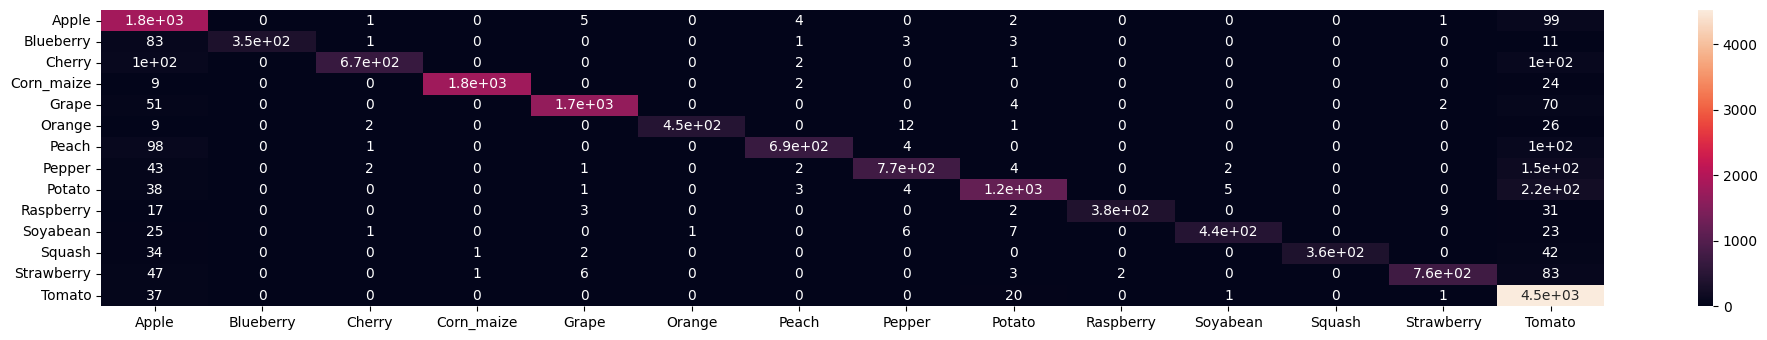

-------------------------------------------------------------------

Diseases Classifaction:
	The hyperparameters are {'algorithm': 'SAMME.R', 'base_estimator': 'deprecated', 'estimator__ccp_alpha': 0.0, 'estimator__class_weight': None, 'estimator__criterion': 'log_loss', 'estimator__max_depth': 18, 'estimator__max_features': None, 'estimator__max_leaf_nodes': 1200, 'estimator__min_impurity_decrease': 3.1622776601683795e-05, 'estimator__min_samples_leaf': 1e-09, 'estimator__min_samples_split': 1e-05, 'estimator__min_weight_fraction_leaf': 0.0, 'estimator__random_state': 42, 'estimator__splitter': 'best', 'estimator': DecisionTreeClassifier(criterion='log_loss', max_depth=18, max_leaf_nodes=1200,
                       min_impurity_decrease=3.1622776601683795e-05,
                       min_samples_leaf=1e-09, min_samples_split=1e-05,
                       random_state=42), 'learning_rate': 1.0, 'n_estimators': 50, 'random_state': 42}
	The accuracy score for the validation dataset is 0

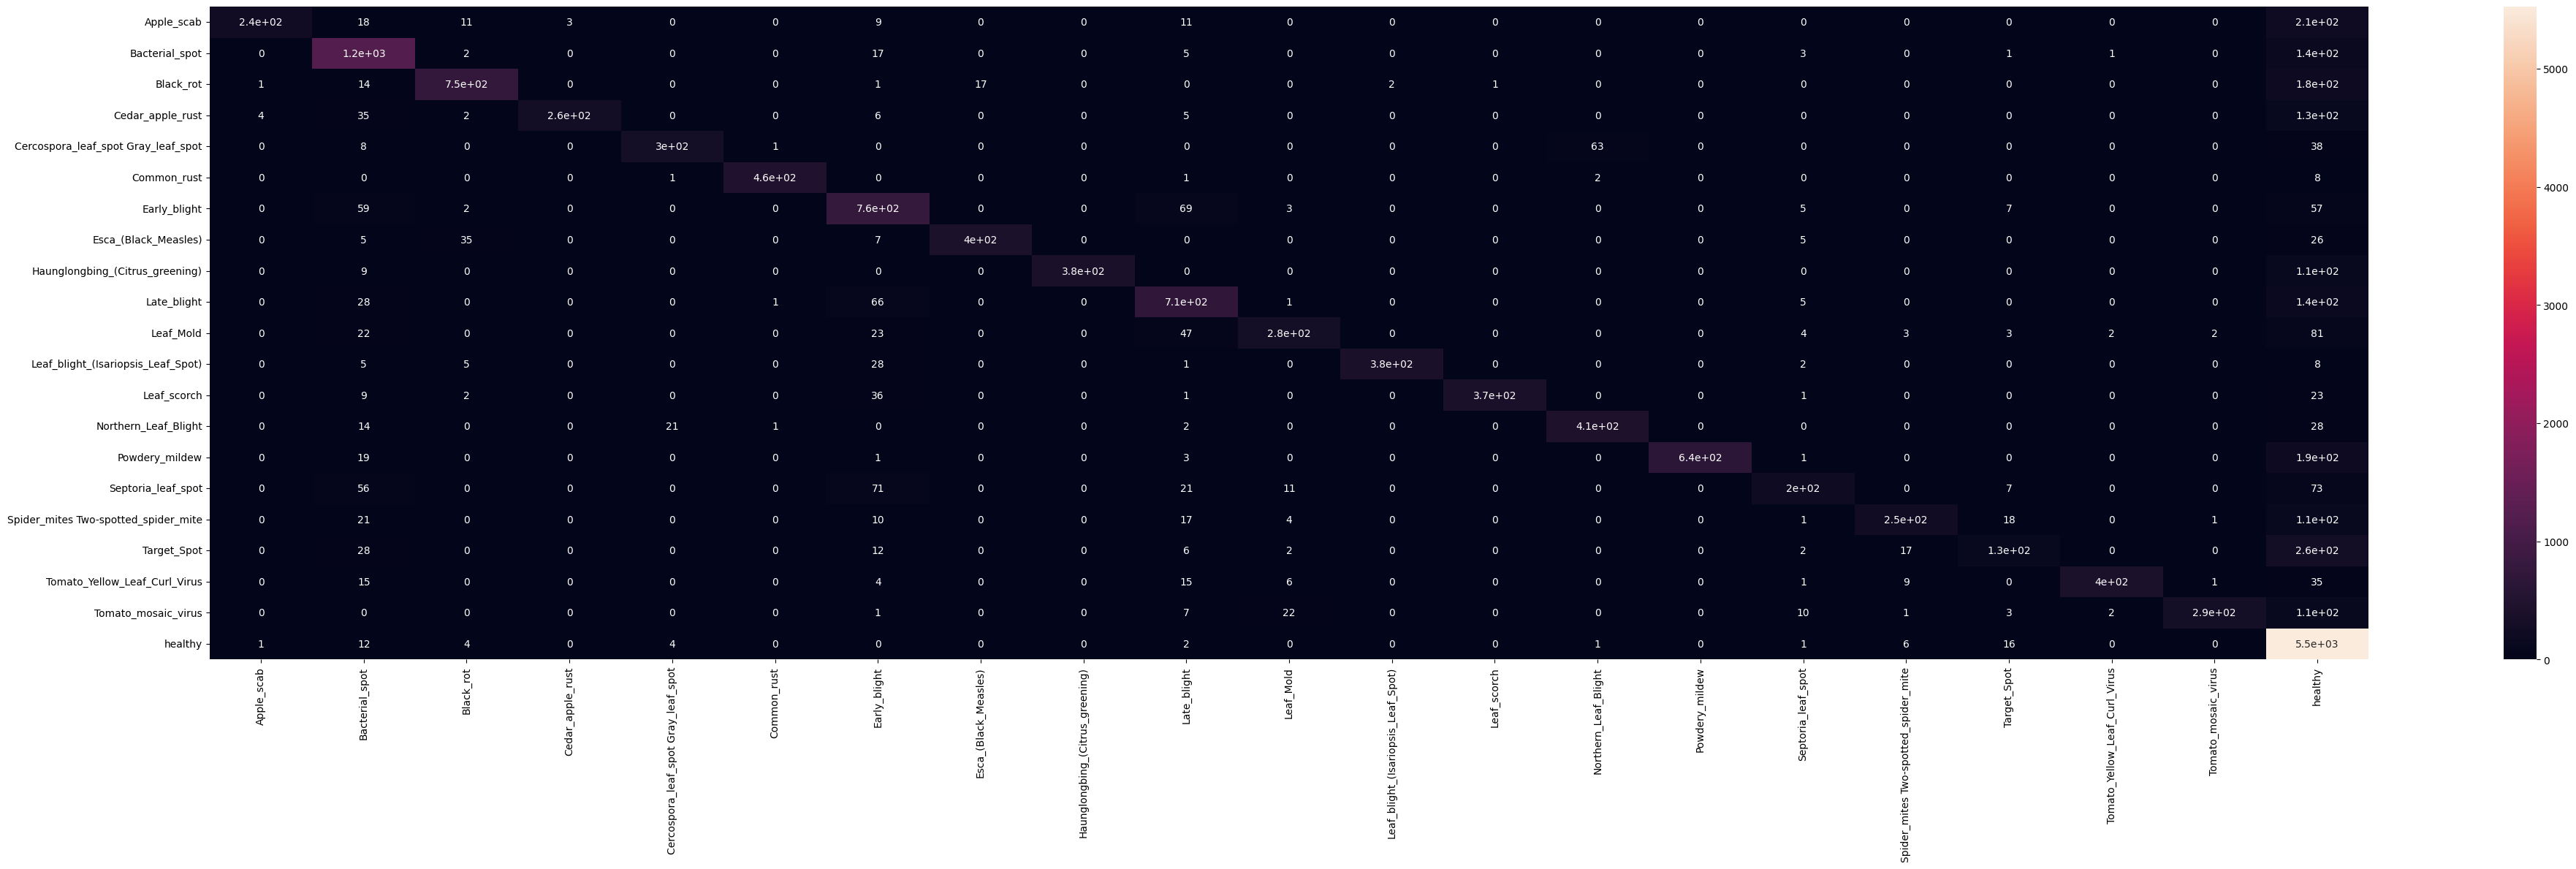

-------------------------------------------------------------------



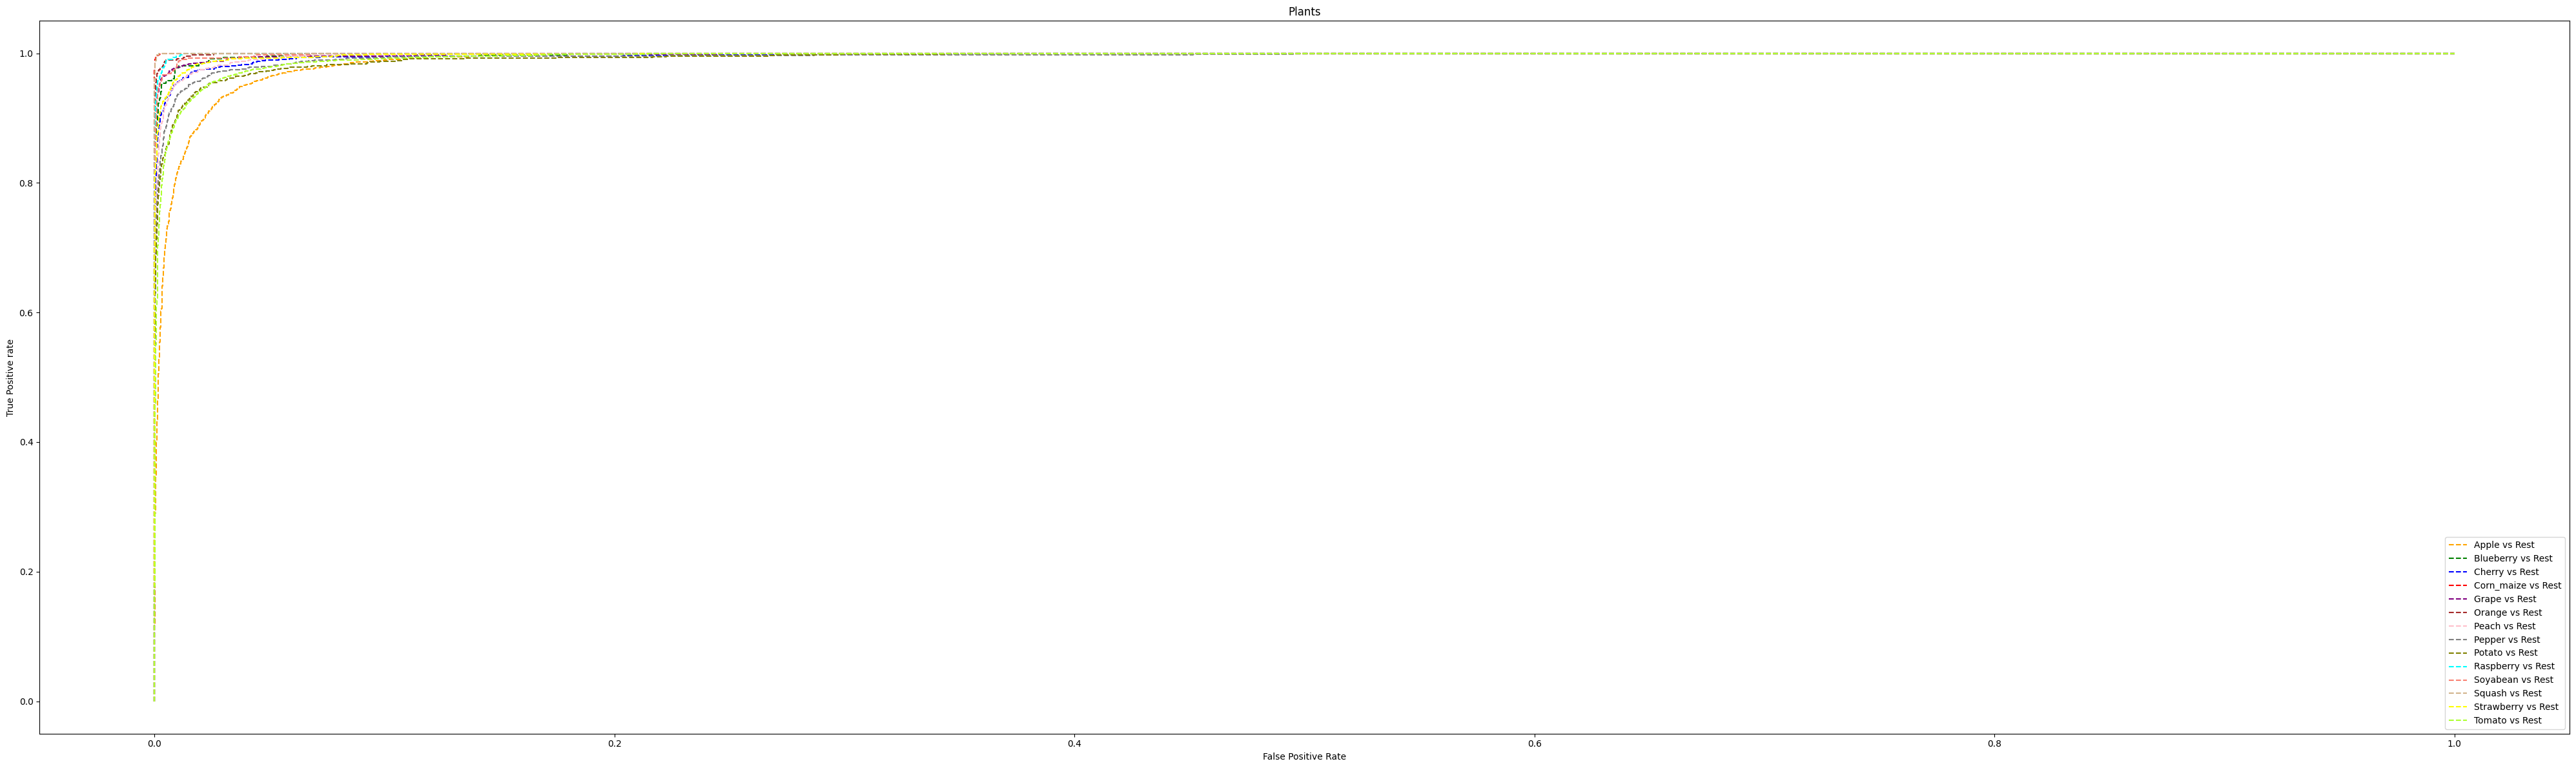

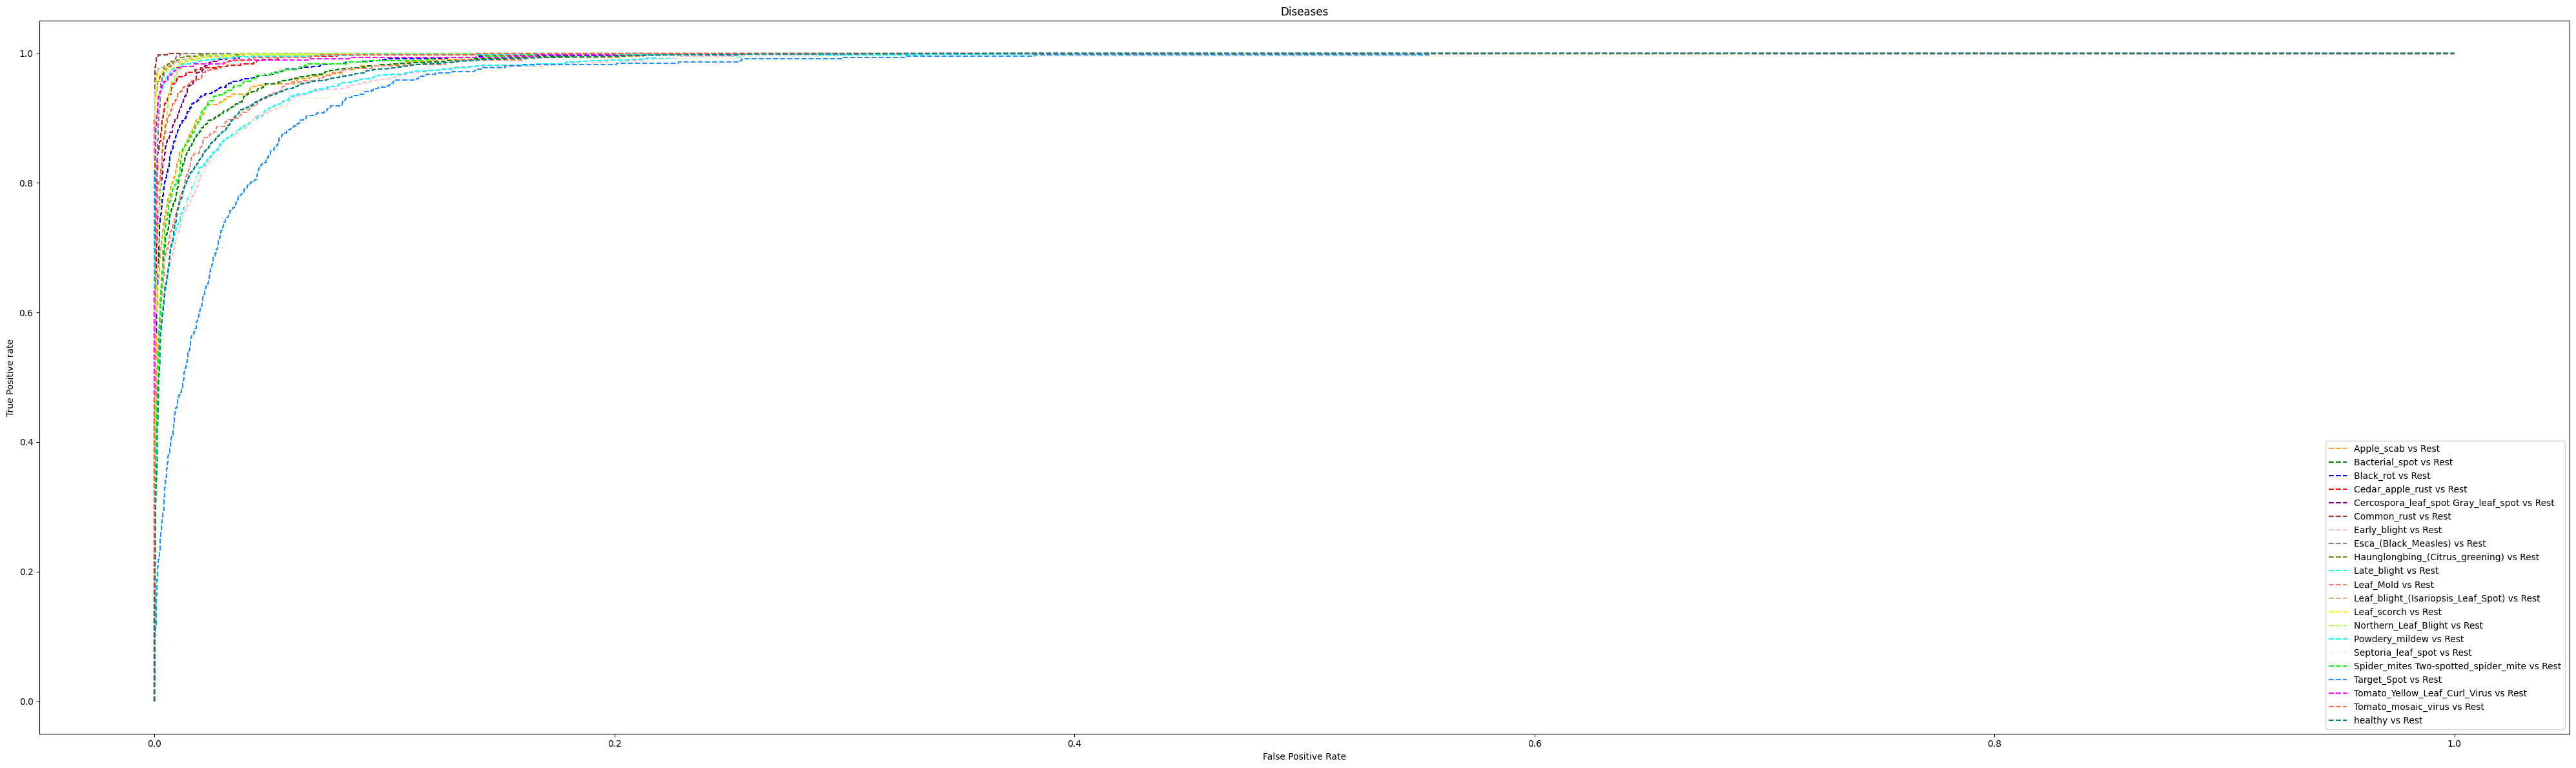

In [ ]:
#function to plot AUC ROC Curve for multi Classification
def plot_auc_roc_multi(y_valid, y_classes, pred_prob2,model_label):
  colors = ['orange','green','blue','red','purple','brown','pink','gray','olive','cyan','salmon','tan','yellow','greenyellow','aqua','beige','lime','dodgerblue','magenta','tomato','teal','silver']
  fpr = {}
  tpr = {}
  thresh ={}
  n_class = len(y_classes)
  for i in range(n_class):    
    fpr[i], tpr[i], thresh[i] = roc_curve(y_valid, pred_prob2[:,i], pos_label=y_classes[i])
    # plotting 
    plt.plot(fpr[i], tpr[i], linestyle='--',color=colors[i], label=y_classes[i] + ' vs Rest')

  plt.title(model_label)
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive rate')
  plt.legend(loc='best')
  plt.show()
  return
#####END of function#############

with open('/content/drive/MyDrive/EE769/Adaboost_Decision_tree_plants_model.bin','rb') as f_in1:
  clf_plants_loaded = pickle.load(f_in1)

with open('/content/drive/MyDrive/EE769/Adaboost_Decision_tree_diseases_model.bin','rb') as f_in2:
  clf_diseases_loaded = pickle.load(f_in2)

plt.rcParams["figure.figsize"] = [20.00, 3.50]
plt.rcParams["figure.autolayout"] = True
y1_valid_predicted = clf_plants_loaded.predict(X1_valid)
confusion_matrix_df = pd.DataFrame(confusion_matrix(y1_valid, y1_valid_predicted), columns=y1_valid_classes, index=y1_valid_classes)
sns.heatmap(confusion_matrix_df, annot=True)
plt.savefig('/content/drive/MyDrive/EE769/Adaboost_Decision_tree_Plants.png')

print('Plants Classifaction:')
print(f'\tThe hyperparameters are {clf_plants_loaded.get_params()}')
print(f'\tThe accuracy score for the validation dataset is {accuracy_score(y1_valid, y1_valid_predicted):.4f}')
print(f'\tThe balanced accuracy score for the validation dataset is {balanced_accuracy_score(y1_valid, y1_valid_predicted):.4f}')
pred_prob1 = clf_plants_loaded.predict_proba(X1_valid)
# print(f'\tThe roc_auc score for the validation dataset is {roc_auc_score(y1_valid, pred_prob1,multi_class="ovr"):.4f}')
print('\tClassification Report:')
print(classification_report(y1_valid, y1_valid_predicted))
plt.show()
print('-------------------------------------------------------------------\n')

plt.rcParams["figure.figsize"] = [40.00, 12]
plt.rcParams["figure.autolayout"] = True
y2_valid_predicted = clf_diseases_loaded.predict(X2_valid)
confusion_matrix_df = pd.DataFrame(confusion_matrix(y2_valid, y2_valid_predicted), columns=y2_classes, index=y2_classes)
sns.heatmap(confusion_matrix_df, annot=True)
plt.savefig('/content/drive/MyDrive/EE769/Adaboost_Decision_tree_Diseases.png')

print('Diseases Classifaction:')
# print(f'\tThe best hyperparameters are {grid_result.best_params_}')
print(f'\tThe hyperparameters are {clf_diseases_loaded.get_params()}')
print(f'\tThe accuracy score for the validation dataset is {accuracy_score(y2_valid, y2_valid_predicted):.4f}')
print(f'\tThe balanced accuracy score for the validation dataset is {balanced_accuracy_score(y2_valid, y2_valid_predicted):.4f}')
pred_prob2 = clf_diseases_loaded.predict_proba(X2_valid)
# print(f'\tThe roc_auc score for the validation dataset is {roc_auc_score(y2_valid, pred_prob2,multi_class="ovr"):.4f}')
print('\tClassification Report:')
print(classification_report(y2_valid, y2_valid_predicted))
plt.show()
print('-------------------------------------------------------------------\n')

plot_auc_roc_multi(y1_valid, y1_classes, pred_prob1,'Plants')
plot_auc_roc_multi(y2_valid, y2_classes, pred_prob2,'Diseases')

## Task-5C: Predictor-3B
###Deployment trail run - Adaboost Decision Tree

1. https://freecontent.manning.com/deploying-machine-learning-models-part-1-saving-models/

In [ ]:

with open('/content/drive/MyDrive/EE769/Adaboost_Decision_tree_plants_model.bin','rb') as f_in1:
  clf_plants_loaded = pickle.load(f_in1)

with open('/content/drive/MyDrive/EE769/Adaboost_Decision_tree_diseases_model.bin','rb') as f_in2:
  clf_diseases_loaded = pickle.load(f_in2)

# print(clf_plants_loaded.get_params())
# print(clf_diseases_loaded.get_params())

#Load the pretrained model
# model = models.resnet18(pretrained=True) #The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
model = models.resnet18(weights=ResNet18_Weights.DEFAULT)
#Use the model object to select the desired layer
layer = model._modules.get('avgpool')
#Set model to evaluation mode
model.eval()
#ResNet-18 expects images to be at least 224x224, as well as normalized with a specific mean and standard deviation
scaler = transforms.Resize((224, 224))
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                  std=[0.229, 0.224, 0.225])
to_tensor = transforms.ToTensor()
def extract_ResNet18_features(input_image_path):
  #Load the image with Pillow library
  img = Image.open(input_image_path)
  #Create a PyTorch Variable with the transformed image
  t_img = Variable(normalize(to_tensor(scaler(img))).unsqueeze(0))
  #Create a vector of zeros that will hold our feature vector
    #The 'avgpool' layer has an output size of 512
  features_of_image = torch.zeros(512)
  #Define a function that will copy the output of a layer
  def copy_data(m, i, o):
    features_of_image.copy_(o.data.reshape(o.data.size(1)))
    # features_of_image.copy_(o.data)
  #Attach that function to our selected layer
  h = layer.register_forward_hook(copy_data)
  #Run the model on our transformed image
  model(t_img)
  # Detach our copy function from the layer
  h.remove()
  # Return the feature vector
  return features_of_image

features_list = []
for x in range(512):
  features_list.append(str(x))

#input image
input_image = '/content/drive/MyDrive/EE769/project_dataset/test/Apple/Apple_scab/AppleScab1.JPG'
input_data_array = pd.DataFrame([extract_ResNet18_features(input_image).numpy()],columns=features_list)
display(input_data_array)
print('The Predicted plant is '+ str(clf_plants_loaded.predict(input_data_array)[0]) )
print('The Predicted disease is '+ str(clf_diseases_loaded.predict(input_data_array)[0]) )


0         1       2         3        4         5         6  \
0  0.113196  1.085623  0.4234  0.379735  0.12552  0.019379  0.026019   

          7         8         9  ...      502       503       504       505  \
0  0.134951  0.058653  0.670229  ...  0.80811  0.078584  0.070219  1.748914   

        506       507       508       509       510       511  
0  2.377569  0.015677  0.654779  0.058494  0.506796  0.832138  

[1 rows x 512 columns]

The Predicted plant is Apple
The Predicted disease is healthy


## Task-6A: Predictor-4
### Voting Classifier (Ensemble Learning Model) - Plants Classification - Training

In [ ]:
#Voting Classifier

#References:
#1. https://towardsdatascience.com/ensemble-learning-using-scikit-learn-85c4531ff86a


with open('/content/drive/MyDrive/EE769/L2_regularized_plants_model.bin','rb') as f_in1:
  l2_plants = pickle.load(f_in1)

with open('/content/drive/MyDrive/EE769/Random_forest_plants_model_Random.bin','rb') as f_in2:
  rf_plants = pickle.load(f_in2)

with open('/content/drive/MyDrive/EE769/Adaboost_Decision_tree_plants_model.bin','rb') as f_in3:
  dt_plants = pickle.load(f_in3)

#create a dictionary of our models
estimators=[('l2', l2_plants), ('rf', rf_plants), ('dt', dt_plants)]

#create our voting classifier, inputting our models
ensemble_plants = VotingClassifier(estimators, voting='hard')
ensemble_plants.fit(X1_train, y1_train.values.ravel())



#For Deployment:
with open('/content/drive/MyDrive/EE769/Voting_classifier_plants_model.bin','wb') as f_out1: #specify the file where you wnt to save
  pickle.dump(ensemble_plants,f_out1) #Save the model to file with pickle


## Task-6A: Predictor-4
### Voting Classifier (Ensemble Learning Model) - Diseases Classification - Training

In [ ]:
#Voting Classifier

#References:
#1. https://towardsdatascience.com/ensemble-learning-using-scikit-learn-85c4531ff86a

with open('/content/drive/MyDrive/EE769/L2_regularized_diseases_model.bin','rb') as f_in4:
  l2_diseases = pickle.load(f_in4)

with open('/content/drive/MyDrive/EE769/Random_forest_diseases_model_Random.bin','rb') as f_in5:
  rf_diseases = pickle.load(f_in5)

with open('/content/drive/MyDrive/EE769/Adaboost_Decision_tree_diseases_model.bin','rb') as f_in6:
  dt_diseases = pickle.load(f_in6)

#create a dictionary of our models
estimators=[('l2', l2_diseases), ('rf', rf_diseases), ('dt', dt_diseases)]

#create our voting classifier, inputting our models
ensemble_diseases = VotingClassifier(estimators, voting='hard')
ensemble_diseases.fit(X2_train, y2_train.values.ravel())

plt.rcParams["figure.figsize"] = [40.00, 12]
plt.rcParams["figure.autolayout"] = True
y2_valid_predicted = ensemble_diseases.predict(X2_valid)
confusion_matrix_df = pd.DataFrame(confusion_matrix(y2_valid, y2_valid_predicted), columns=y2_classes, index=y2_classes)
sns.heatmap(confusion_matrix_df, annot=True)
plt.savefig('/content/drive/MyDrive/EE769/Voting_classifier_Diseases.png')
print('Diseases Classifaction:')

print(f'\tThe accuracy score for the validation dataset is {accuracy_score(y2_valid, y2_valid_predicted):.4f}')
print(f'\tThe balanced accuracy score for the validation dataset is {balanced_accuracy_score(y2_valid, y2_valid_predicted):.4f}')
print('\tClassification Report:')
print(classification_report(y2_valid, y2_valid_predicted))
plt.show()
print('-------------------------------------------------------------------\n')

#For Deployment:
with open('/content/drive/MyDrive/EE769/Voting_classifier_diseases_model.bin','wb') as f_out2: #specify the file where you wnt to save
  pickle.dump(ensemble_diseases,f_out2) #Save the model to file with pickle


## Task-6B: Predictor-4
###Validation - Voting classifier

Plants Classifaction:
	The hyperparameters are {'estimators': [('l2', LogisticRegression(max_iter=5000, random_state=0)), ('rf', RandomForestClassifier(max_depth=40, random_state=44)), ('dt', AdaBoostClassifier(estimator=DecisionTreeClassifier(criterion='log_loss',
                                                    max_depth=20,
                                                    max_leaf_nodes=1500,
                                                    min_impurity_decrease=1e-05,
                                                    min_samples_leaf=1e-07,
                                                    min_samples_split=3.1622776601683795e-05,
                                                    random_state=42),
                   random_state=42))], 'flatten_transform': True, 'n_jobs': None, 'verbose': False, 'voting': 'hard', 'weights': None, 'l2': LogisticRegression(max_iter=5000, random_state=0), 'rf': RandomForestClassifier(max_depth=40, random_state=44), 'dt': AdaBoostClassif

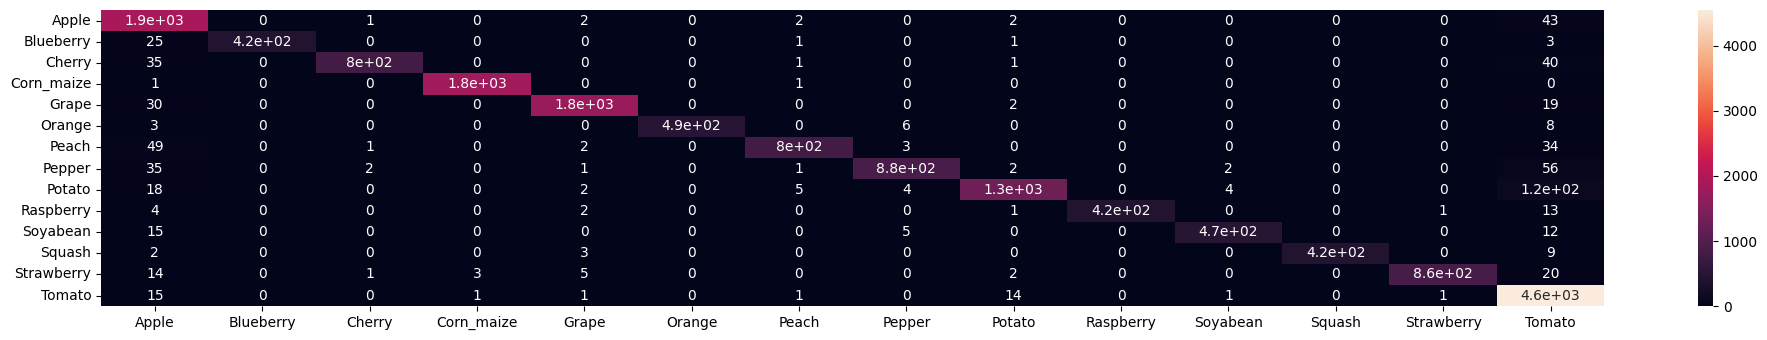

-------------------------------------------------------------------

Diseases Classifaction:
	The hyperparameters are {'estimators': [('l2', LogisticRegression(max_iter=10000, random_state=0)), ('rf', RandomForestClassifier(max_depth=45, random_state=44)), ('dt', AdaBoostClassifier(estimator=DecisionTreeClassifier(criterion='log_loss',
                                                    max_depth=18,
                                                    max_leaf_nodes=1200,
                                                    min_impurity_decrease=3.1622776601683795e-05,
                                                    min_samples_leaf=1e-09,
                                                    min_samples_split=1e-05,
                                                    random_state=42),
                   random_state=42))], 'flatten_transform': True, 'n_jobs': None, 'verbose': False, 'voting': 'hard', 'weights': None, 'l2': LogisticRegression(max_iter=10000, random_state=0), 'rf': Ran

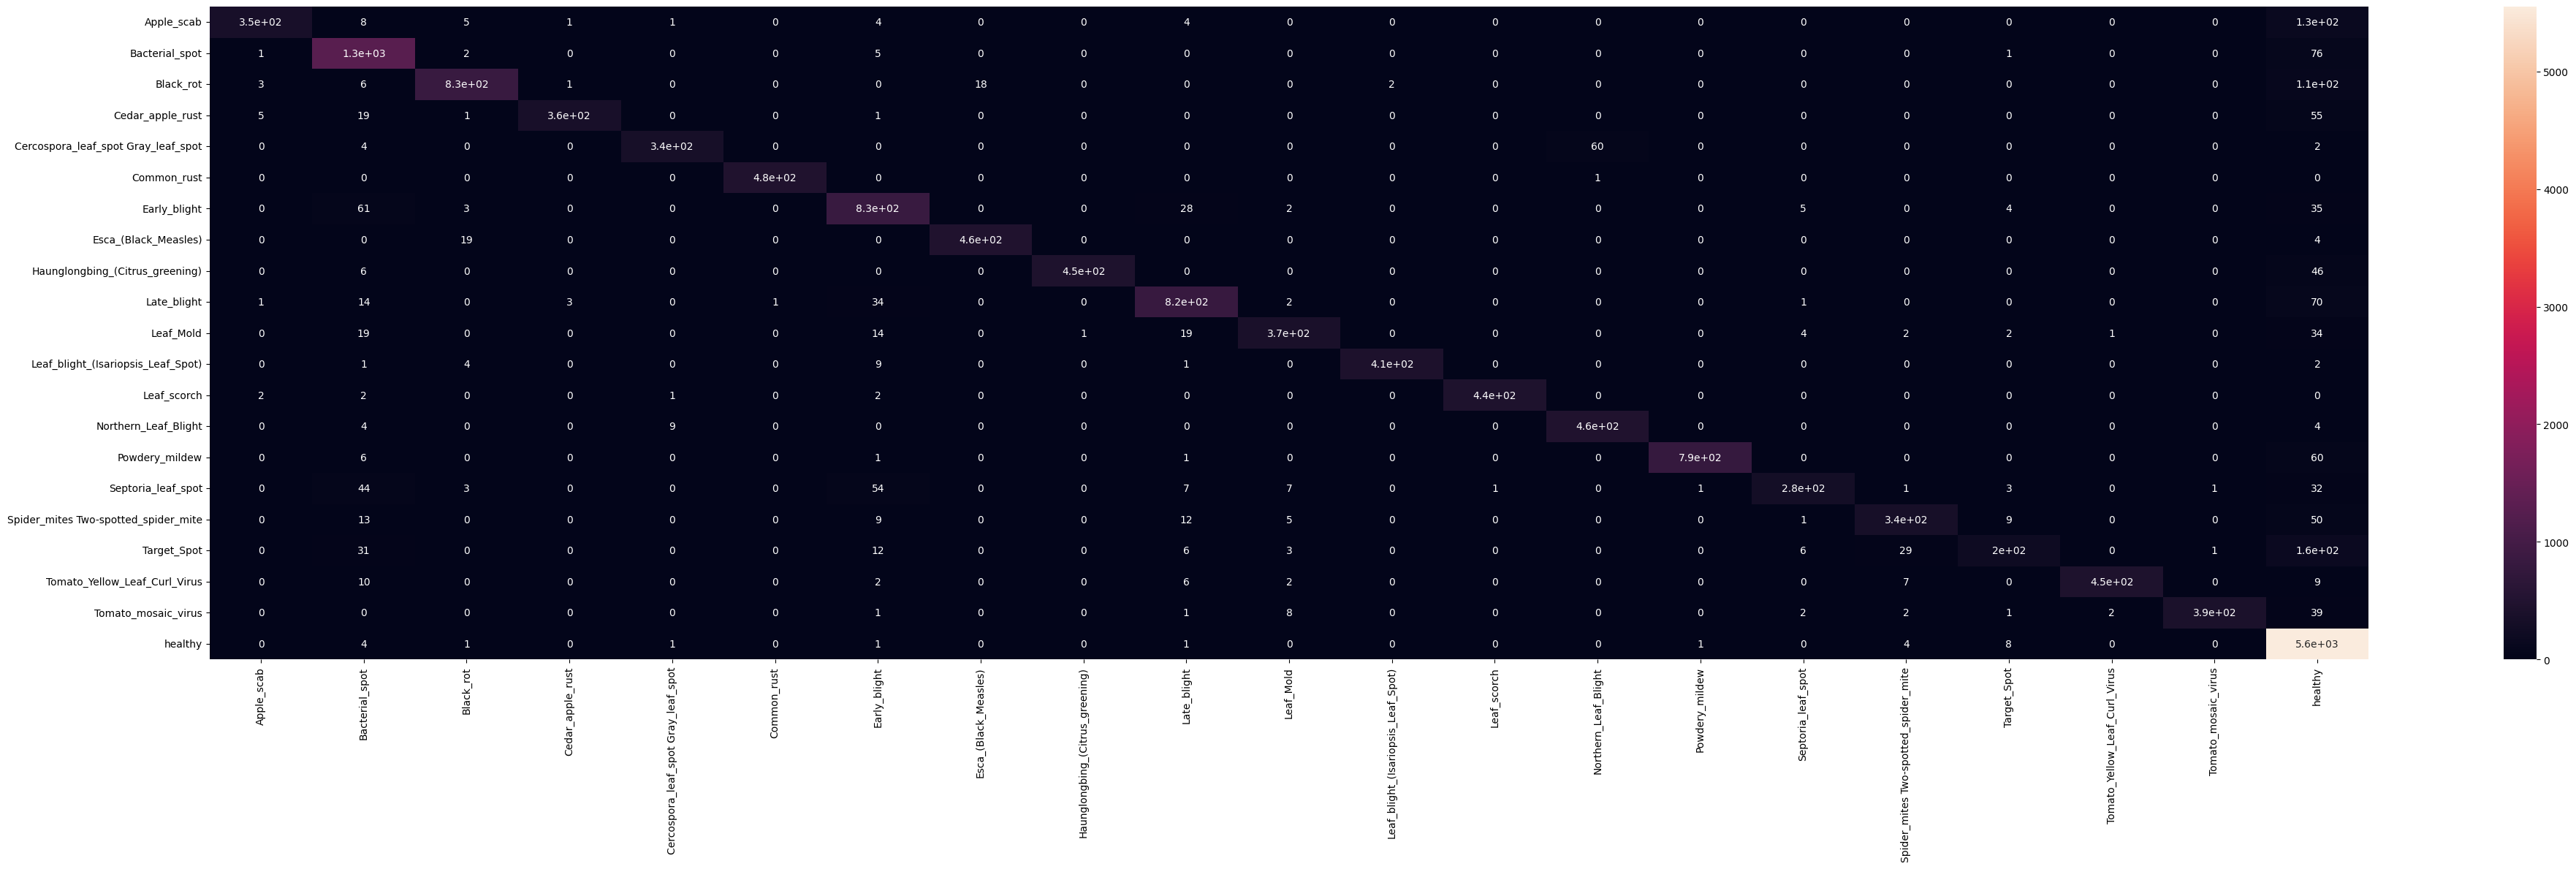

-------------------------------------------------------------------



In [ ]:

with open('/content/drive/MyDrive/EE769/Voting_classifier_plants_model.bin','rb') as f_in1:
  clf_plants_loaded = pickle.load(f_in1)

with open('/content/drive/MyDrive/EE769/Voting_classifier_diseases_model.bin','rb') as f_in2:
  clf_diseases_loaded = pickle.load(f_in2)

#Plants
plt.rcParams["figure.figsize"] = [20.00, 3.50]
plt.rcParams["figure.autolayout"] = True
y1_valid_predicted = clf_plants_loaded.predict(X1_valid)
confusion_matrix_df = pd.DataFrame(confusion_matrix(y1_valid, y1_valid_predicted), columns=y1_valid_classes, index=y1_valid_classes)
sns.heatmap(confusion_matrix_df, annot=True)
plt.savefig('/content/drive/MyDrive/EE769/Voting_classifier_Plants.png')

print('Plants Classifaction:')
print(f'\tThe hyperparameters are {clf_plants_loaded.get_params()}')
print(f'\tThe accuracy score for the validation dataset is {accuracy_score(y1_valid, y1_valid_predicted):.4f}')
print(f'\tThe balanced accuracy score for the validation dataset is {balanced_accuracy_score(y1_valid, y1_valid_predicted):.4f}')
print('\tClassification Report:')
print(classification_report(y1_valid, y1_valid_predicted))
plt.show()
print('-------------------------------------------------------------------\n')

#Diseases
plt.rcParams["figure.figsize"] = [40.00, 12]
plt.rcParams["figure.autolayout"] = True
y2_valid_predicted = clf_diseases_loaded.predict(X2_valid)
confusion_matrix_df = pd.DataFrame(confusion_matrix(y2_valid, y2_valid_predicted), columns=y2_classes, index=y2_classes)
sns.heatmap(confusion_matrix_df, annot=True)
plt.savefig('/content/drive/MyDrive/EE769/Voting_classifier_Diseases.png')
print('Diseases Classifaction:')
print(f'\tThe hyperparameters are {clf_diseases_loaded.get_params()}')
print(f'\tThe accuracy score for the validation dataset is {accuracy_score(y2_valid, y2_valid_predicted):.4f}')
print(f'\tThe balanced accuracy score for the validation dataset is {balanced_accuracy_score(y2_valid, y2_valid_predicted):.4f}')
print('\tClassification Report:')
print(classification_report(y2_valid, y2_valid_predicted))
plt.show()
print('-------------------------------------------------------------------\n')


## Task-6C: Predictor-4
###Deployment trail run - Voting classifier

1. https://freecontent.manning.com/deploying-machine-learning-models-part-1-saving-models/

In [ ]:

with open('/content/drive/MyDrive/EE769/Voting_classifier_plants_model.bin','rb') as f_in1:
  clf_plants_loaded = pickle.load(f_in1)

with open('/content/drive/MyDrive/EE769/Voting_classifier_diseases_model.bin','rb') as f_in2:
  clf_diseases_loaded = pickle.load(f_in2)

# print(clf_plants_loaded.get_params())
# print(clf_diseases_loaded.get_params())

#Load the pretrained model
# model = models.resnet18(pretrained=True) #The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
model = models.resnet18(weights=ResNet18_Weights.DEFAULT)
#Use the model object to select the desired layer
layer = model._modules.get('avgpool')
#Set model to evaluation mode
model.eval()
#ResNet-18 expects images to be at least 224x224, as well as normalized with a specific mean and standard deviation
scaler = transforms.Resize((224, 224))
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                  std=[0.229, 0.224, 0.225])
to_tensor = transforms.ToTensor()
def extract_ResNet18_features(input_image_path):
  #Load the image with Pillow library
  img = Image.open(input_image_path)
  #Create a PyTorch Variable with the transformed image
  t_img = Variable(normalize(to_tensor(scaler(img))).unsqueeze(0))
  #Create a vector of zeros that will hold our feature vector
    #The 'avgpool' layer has an output size of 512
  features_of_image = torch.zeros(512)
  #Define a function that will copy the output of a layer
  def copy_data(m, i, o):
    features_of_image.copy_(o.data.reshape(o.data.size(1)))
    # features_of_image.copy_(o.data)
  #Attach that function to our selected layer
  h = layer.register_forward_hook(copy_data)
  #Run the model on our transformed image
  model(t_img)
  # Detach our copy function from the layer
  h.remove()
  # Return the feature vector
  return features_of_image

features_list = []
for x in range(512):
  features_list.append(str(x))

#input image
input_image = '/content/drive/MyDrive/EE769/project_dataset/test/Apple/Apple_scab/AppleScab1.JPG'
input_data_array = pd.DataFrame([extract_ResNet18_features(input_image).numpy()],columns=features_list)
display(input_data_array)
print('The Predicted plant is '+ str(clf_plants_loaded.predict(input_data_array)[0]) )
print('The Predicted disease is '+ str(clf_diseases_loaded.predict(input_data_array)[0]) )


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

0         1       2         3        4         5         6  \
0  0.113196  1.085623  0.4234  0.379735  0.12552  0.019379  0.026019   

          7         8         9  ...      502       503       504       505  \
0  0.134951  0.058653  0.670229  ...  0.80811  0.078584  0.070219  1.748914   

        506       507       508       509       510       511  
0  2.377569  0.015677  0.654779  0.058494  0.506796  0.832138  

[1 rows x 512 columns]

The Predicted plant is Apple
The Predicted disease is Apple_scab


## Task-7
### Testing 
* Test the final model on test data and show the results -- accuracy and F1 score.

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 228MB/s]


['Apple', 'Tomato', 'Potato', 'Corn_maize']
-------------------------------------------------------------------

Dimensions of features array list is 33 X 512

-------------------------------------------------------------------

        plant   0
0      Tomato  16
1       Apple   7
2      Potato   7
3  Corn_maize   3
                         disease   0
0                   Early_blight  11
1  Tomato_Yellow_Leaf_Curl_Virus   6
2                        healthy   6
3               Cedar_apple_rust   4
4                     Apple_scab   3
5                    Common_rust   3
The obtained features data array is:


0         1         2         3         4         5         6  \
0   0.611527  0.787073  0.630860  1.066630  0.712045  0.030071  0.164880   
1   0.531117  0.446651  0.055453  1.259031  1.648638  3.102148  0.119297   
2   0.113196  1.085623  0.423400  0.379735  0.125520  0.019379  0.026019   
3   1.189359  1.473629  0.580164  0.985276  0.559383  0.875154  0.615874   
4   0.464387  1.338749  0.324937  0.144043  0.452366  1.180327  0.267062   
5   0.316720  0.581423  0.408798  0.969348  0.760631  1.029367  0.137466   
6   1.018174  0.726067  0.412649  0.714907  0.164964  0.019071  0.159731   
7   0.341049  0.162341  0.034841  0.451500  1.058219  0.511938  0.138252   
8   0.232600  0.091181  0.035929  0.731169  1.250897  0.948492  0.000000   
9   0.226374  0.682756  0.119023  0.995547  0.027824  0.200614  0.041905   
10  1.393360  1.122675  0.765600  1.616773  1.177145  0.627328  0.056928   
11  0.317018  0.612654  0.006788  0.370638  0.177823  1.061081  0.000000   
12  0.989667  0.406440  0.053091  0.646940  0.030522  0.133390  0.001633   
13  0.695460  0.328127  0.412291  0.856903  0.407459  0.918154  0.026733   
14  0.034580  0.582729  0.082586  0.386250  0.444107  0.039012  0.502508   
15  0.223612  0.738820  1.476791  0.871625  1.938701  0.036406  0.829121   
16  0.785301  0.501948  0.553149  0.380730  0.581229  0.738680  0.115630   
17  0.354775  0.306250  0.119736  0.545575  0.089585  0.753043  0.072577   
18  0.313857  0.215062  0.214556  0.331443  1.093317  0.172000  0.591602   
19  0.781969  0.139346  0.319951  1.845415  0.649251  1.419497  0.134563   
20  0.284024  0.062148  1.135835  2.518461  0.558649  0.309081  0.170757   
21  0.378612  0.743402  0.441919  1.507875  0.655625  0.538489  0.676964   
22  0.464857  0.245989  0.638659  1.113061  0.010889  0.400447  0.304938   
23  0.345972  0.396749  0.033738  0.921184  0.061269  1.728609  0.007795   
24  0.744484  0.714263  0.036174  0.741754  0.313110  1.749003  0.007502   
25  0.863838  1.204419  0.034289  0.462893  0.751011  0.586755  0.000000   
26  1.973058  0.949452  0.087429  0.074349  1.052066  0.322663  0.056214   
27  0.741108  0.309171  0.960908  0.377084  1.872458  1.139262  0.434575   
28  0.644281  0.653815  1.026023  0.812567  2.803248  0.462875  0.005693   
29  1.250605  0.644481  0.634444  0.504874  1.473618  1.068283  0.089776   
30  0.046452  0.239215  0.255170  2.441159  0.216589  0.390198  0.326027   
31  0.121055  0.520247  0.029516  3.463089  1.224967  0.068820  0.175365   
32  1.174011  0.946997  0.907250  2.062031  2.018669  0.788883  0.726496   

           7         8         9  ...       504       505       506       507  \
0   0.544176  0.046771  0.879567  ...  0.202092  2.162800  1.647119  0.331114   
1   0.550663  1.868685  0.349384  ...  0.270277  3.214028  0.022998  0.339611   
2   0.134951  0.058653  0.670229  ...  0.070219  1.748914  2.377569  0.015677   
3   0.203584  1.842691  0.165133  ...  0.119673  3.395891  1.838923  0.033118   
4   0.050093  0.707732  1.159778  ...  0.398575  3.113049  0.541653  0.041974   
5   0.136000  1.255579  0.139855  ...  1.457568  2.316872  0.356286  0.000000   
6   0.293241  1.483855  1.766702  ...  0.047460  0.199844  1.237094  0.566589   
7   0.193361  0.607279  0.073477  ...  0.045089  1.717230  0.550884  0.142755   
8   0.013986  0.790201  0.023488  ...  0.003173  3.825809  1.972725  0.585064   
9   0.952883  0.394849  0.021122  ...  0.055567  1.700097  1.741782  0.162698   
10  1.638221  1.299266  0.631113  ...  0.000000  2.724736  1.976132  0.248882   
11  0.025796  0.181889  0.000000  ...  0.024017  2.507403  1.899765  0.210459   
12  0.484530  1.500331  0.164987  ...  0.000000  2.714401  1.895125  0.093510   
13  0.052886  0.346078  0.302562  ...  0.234680  2.931638  1.664407  0.335484   
14  0.068694  0.341818  0.168479  ...  0.141676  4.272242  2.106778  0.000000   
15  1.833751  0.438364  0.753685  ...  0.041244  2.373766  0.742655  0.070737   
16  0.125707  1.822110  0.353345  ...  0.052053  

-------------------------------------------------------------------

-------------------------------------------------------------------

L2 regularized logistic regression
	Plants Classification
	The accuracy score for the testing dataset is 0.9394
	The balanced accuracy score for the testing dataset is 0.9286
	Classification Report:
              precision    recall  f1-score   support

       Apple       1.00      0.71      0.83         7
      Cherry       0.00      0.00      0.00         0
  Corn_maize       1.00      1.00      1.00         3
      Potato       1.00      1.00      1.00         7
      Squash       0.00      0.00      0.00         0
      Tomato       1.00      1.00      1.00        16

    accuracy                           0.94        33
   macro avg       0.67      0.62      0.64        33
weighted avg       1.00      0.94      0.96        33



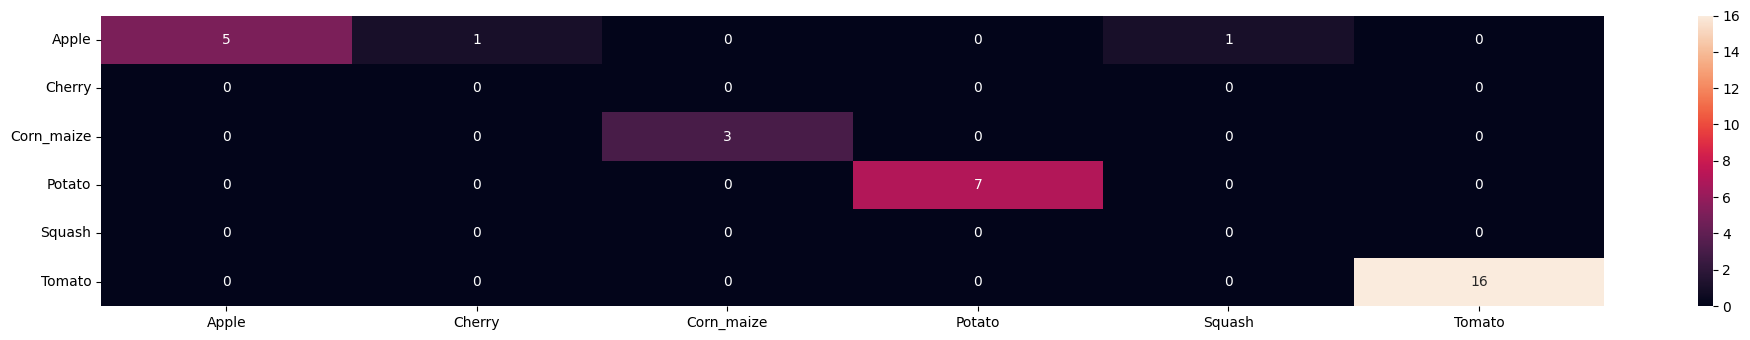

-------------------------------------------------------------------

	Diseases Classification
	The accuracy score for the testing dataset is 0.9091
	The balanced accuracy score for the testing dataset is 0.9154
	Classification Report:
                                      precision    recall  f1-score   support

                          Apple_scab       1.00      1.00      1.00         3
                      Bacterial_spot       0.00      0.00      0.00         0
                    Cedar_apple_rust       1.00      0.75      0.86         4
                         Common_rust       1.00      1.00      1.00         3
                        Early_blight       1.00      0.91      0.95        11
                         Late_blight       0.00      0.00      0.00         0
Spider_mites Two-spotted_spider_mite       0.00      0.00      0.00         0
       Tomato_Yellow_Leaf_Curl_Virus       1.00      1.00      1.00         6
                             healthy       1.00      0.83     

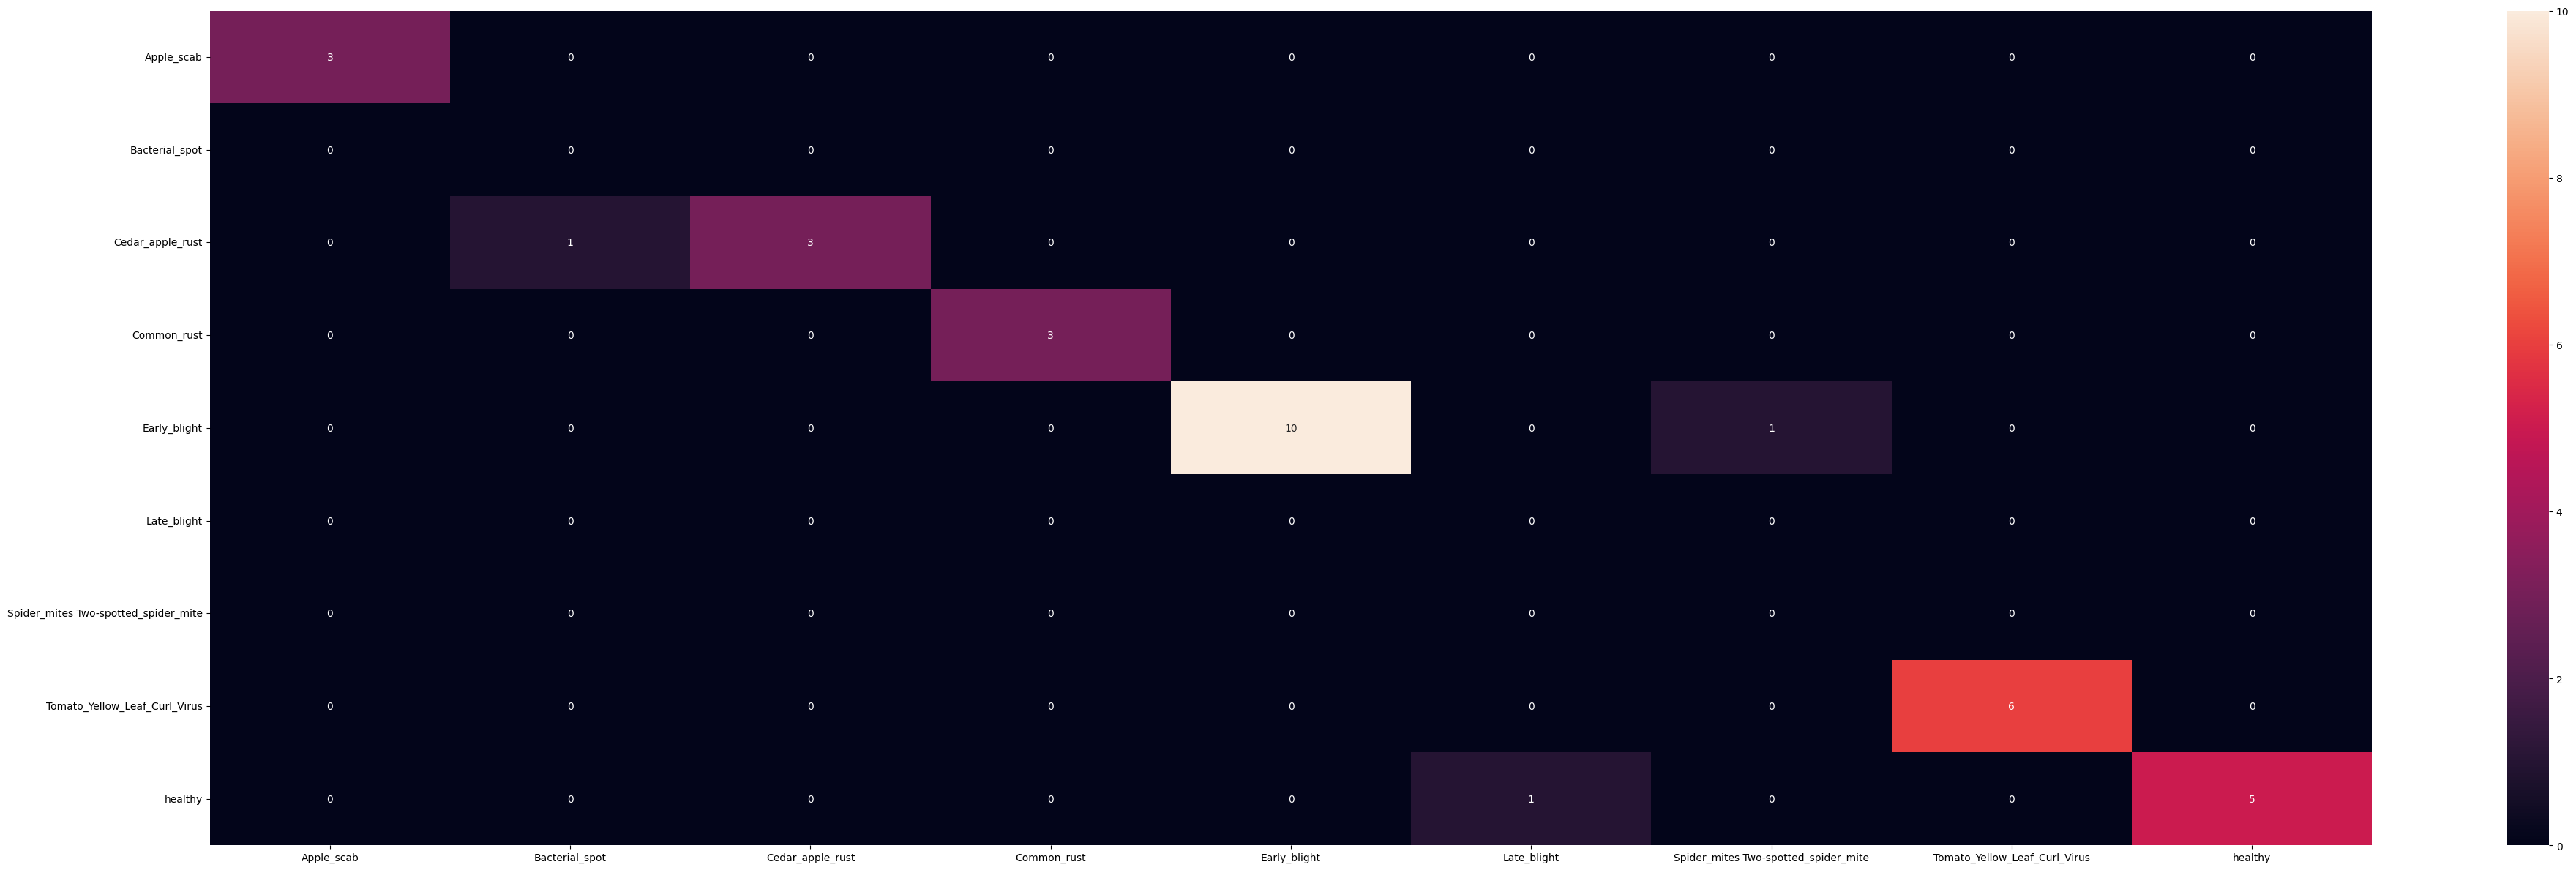

-------------------------------------------------------------------

-------------------------------------------------------------------

Random Forest
	Plants Classification
	The accuracy score for the testing dataset is 0.9091
	The balanced accuracy score for the testing dataset is 0.8929
	Classification Report:
              precision    recall  f1-score   support

       Apple       1.00      0.57      0.73         7
      Cherry       0.00      0.00      0.00         0
  Corn_maize       1.00      1.00      1.00         3
      Potato       1.00      1.00      1.00         7
      Tomato       0.89      1.00      0.94        16

    accuracy                           0.91        33
   macro avg       0.78      0.71      0.73        33
weighted avg       0.95      0.91      0.91        33



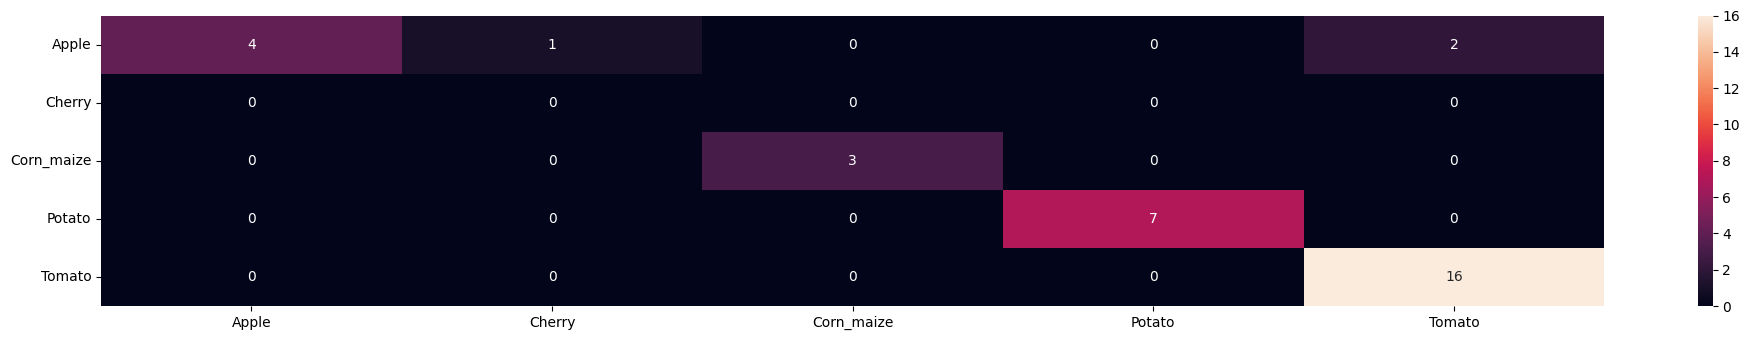

-------------------------------------------------------------------

	Diseases Classification
	The accuracy score for the testing dataset is 0.6667
	The balanced accuracy score for the testing dataset is 0.6591
	Classification Report:
                               precision    recall  f1-score   support

                   Apple_scab       0.00      0.00      0.00         3
               Bacterial_spot       0.00      0.00      0.00         0
             Cedar_apple_rust       1.00      0.50      0.67         4
                  Common_rust       1.00      1.00      1.00         3
                 Early_blight       1.00      0.45      0.62        11
                  Late_blight       0.00      0.00      0.00         0
                  Target_Spot       0.00      0.00      0.00         0
Tomato_Yellow_Leaf_Curl_Virus       1.00      1.00      1.00         6
                      healthy       0.60      1.00      0.75         6

                     accuracy                        

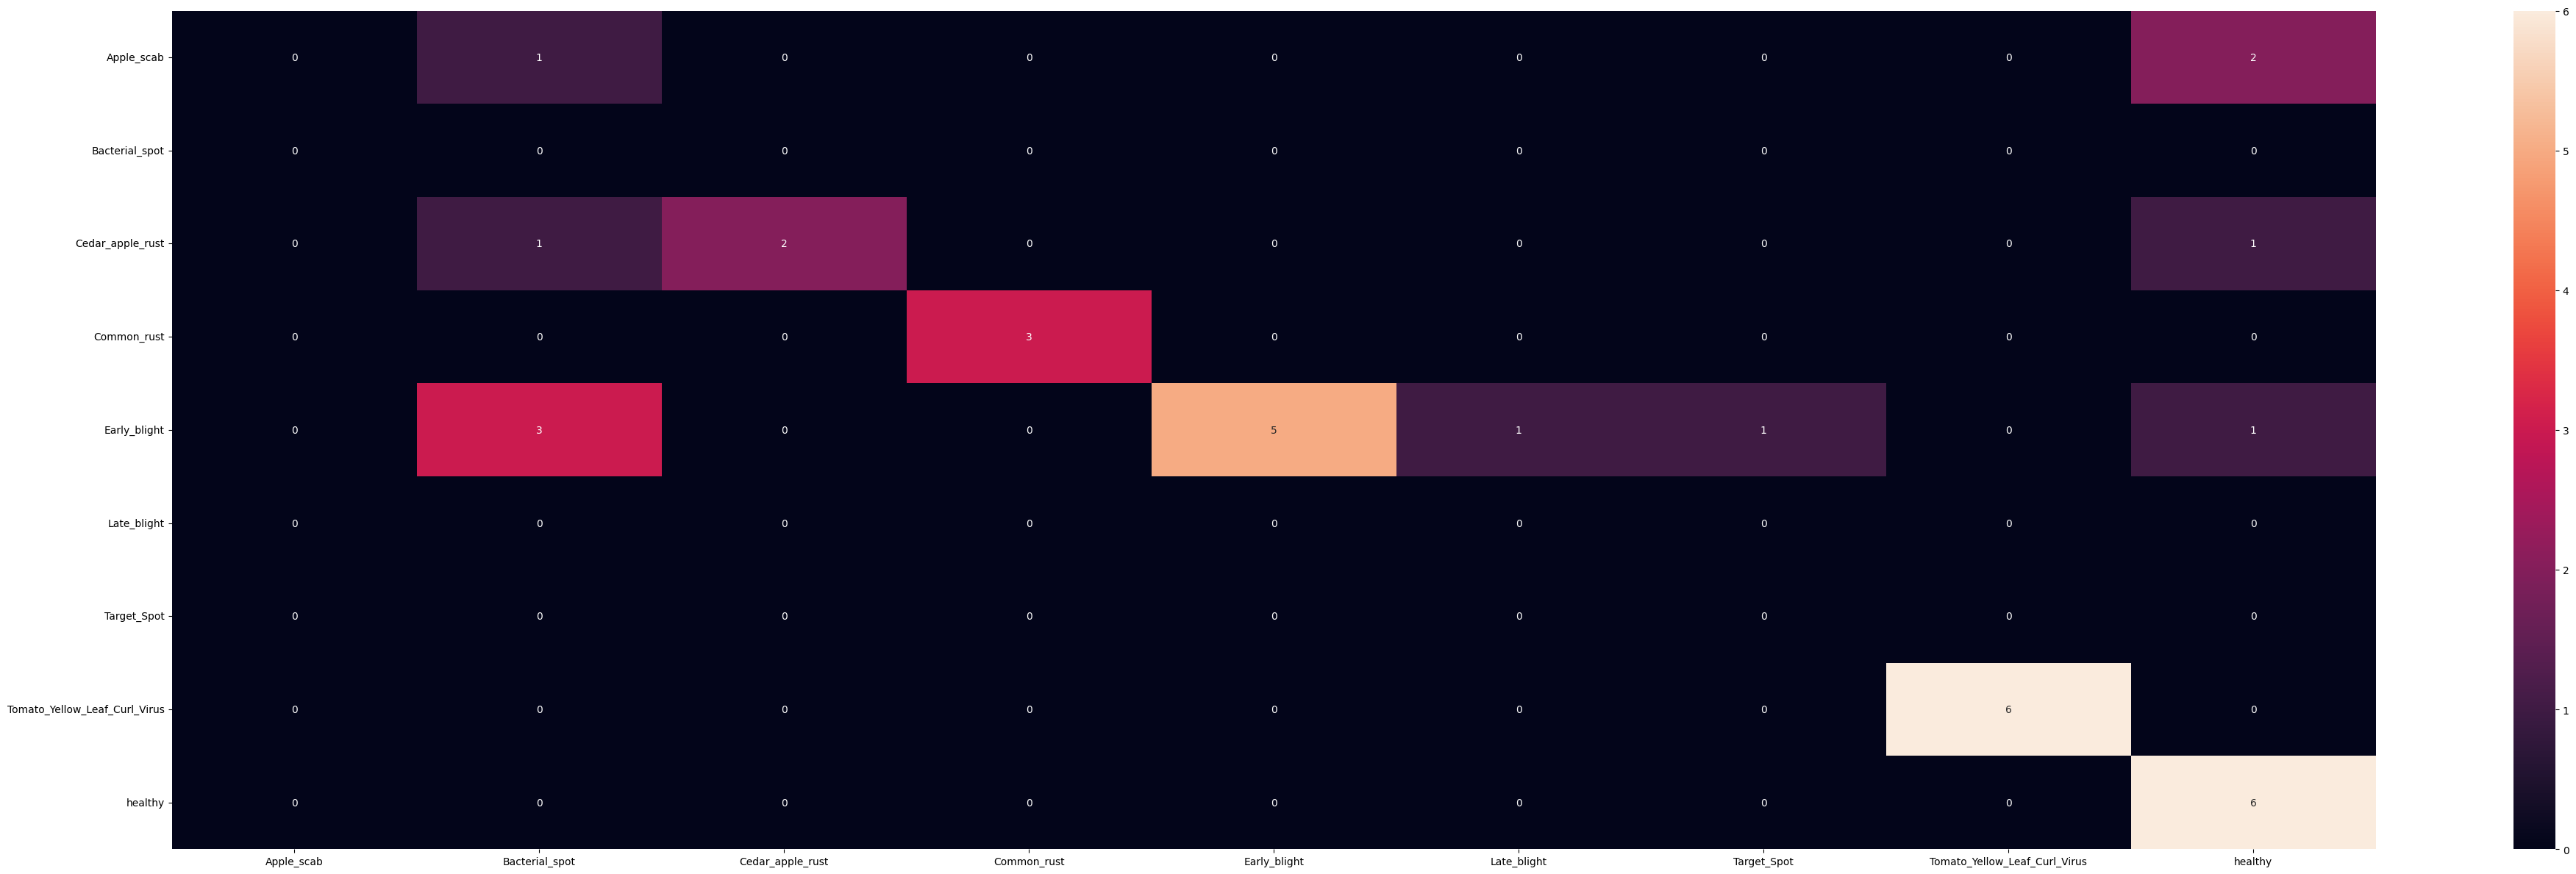

-------------------------------------------------------------------

-------------------------------------------------------------------

Decision Tree
	Plants Classification
	The accuracy score for the testing dataset is 0.7273
	The balanced accuracy score for the testing dataset is 0.6711
	Classification Report:
              precision    recall  f1-score   support

       Apple       1.00      0.29      0.44         7
      Cherry       0.00      0.00      0.00         0
  Corn_maize       1.00      0.67      0.80         3
       Grape       0.00      0.00      0.00         0
       Peach       0.00      0.00      0.00         0
      Potato       0.75      0.86      0.80         7
      Squash       0.00      0.00      0.00         0
      Tomato       0.93      0.88      0.90        16

    accuracy                           0.73        33
   macro avg       0.46      0.34      0.37        33
weighted avg       0.91      0.73      0.77        33



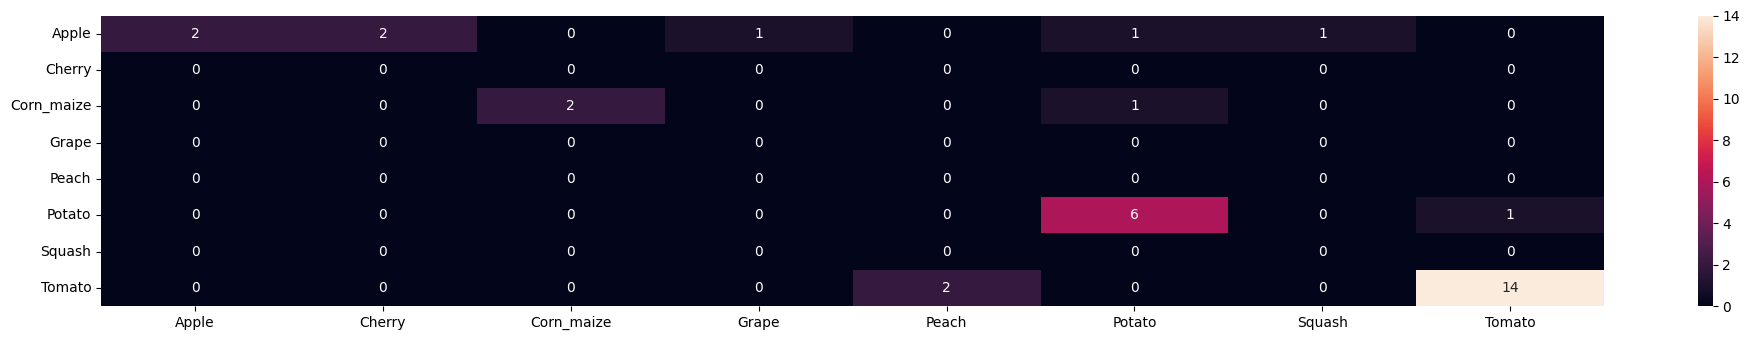

-------------------------------------------------------------------

	Diseases Classification
	The accuracy score for the testing dataset is 0.5455
	The balanced accuracy score for the testing dataset is 0.5871
	Classification Report:
                                      precision    recall  f1-score   support

                          Apple_scab       0.00      0.00      0.00         3
                      Bacterial_spot       0.00      0.00      0.00         0
                    Cedar_apple_rust       1.00      0.75      0.86         4
                         Common_rust       1.00      1.00      1.00         3
                        Early_blight       0.75      0.27      0.40        11
                         Late_blight       0.00      0.00      0.00         0
  Leaf_blight_(Isariopsis_Leaf_Spot)       0.00      0.00      0.00         0
                  Septoria_leaf_spot       0.00      0.00      0.00         0
Spider_mites Two-spotted_spider_mite       0.00      0.00     

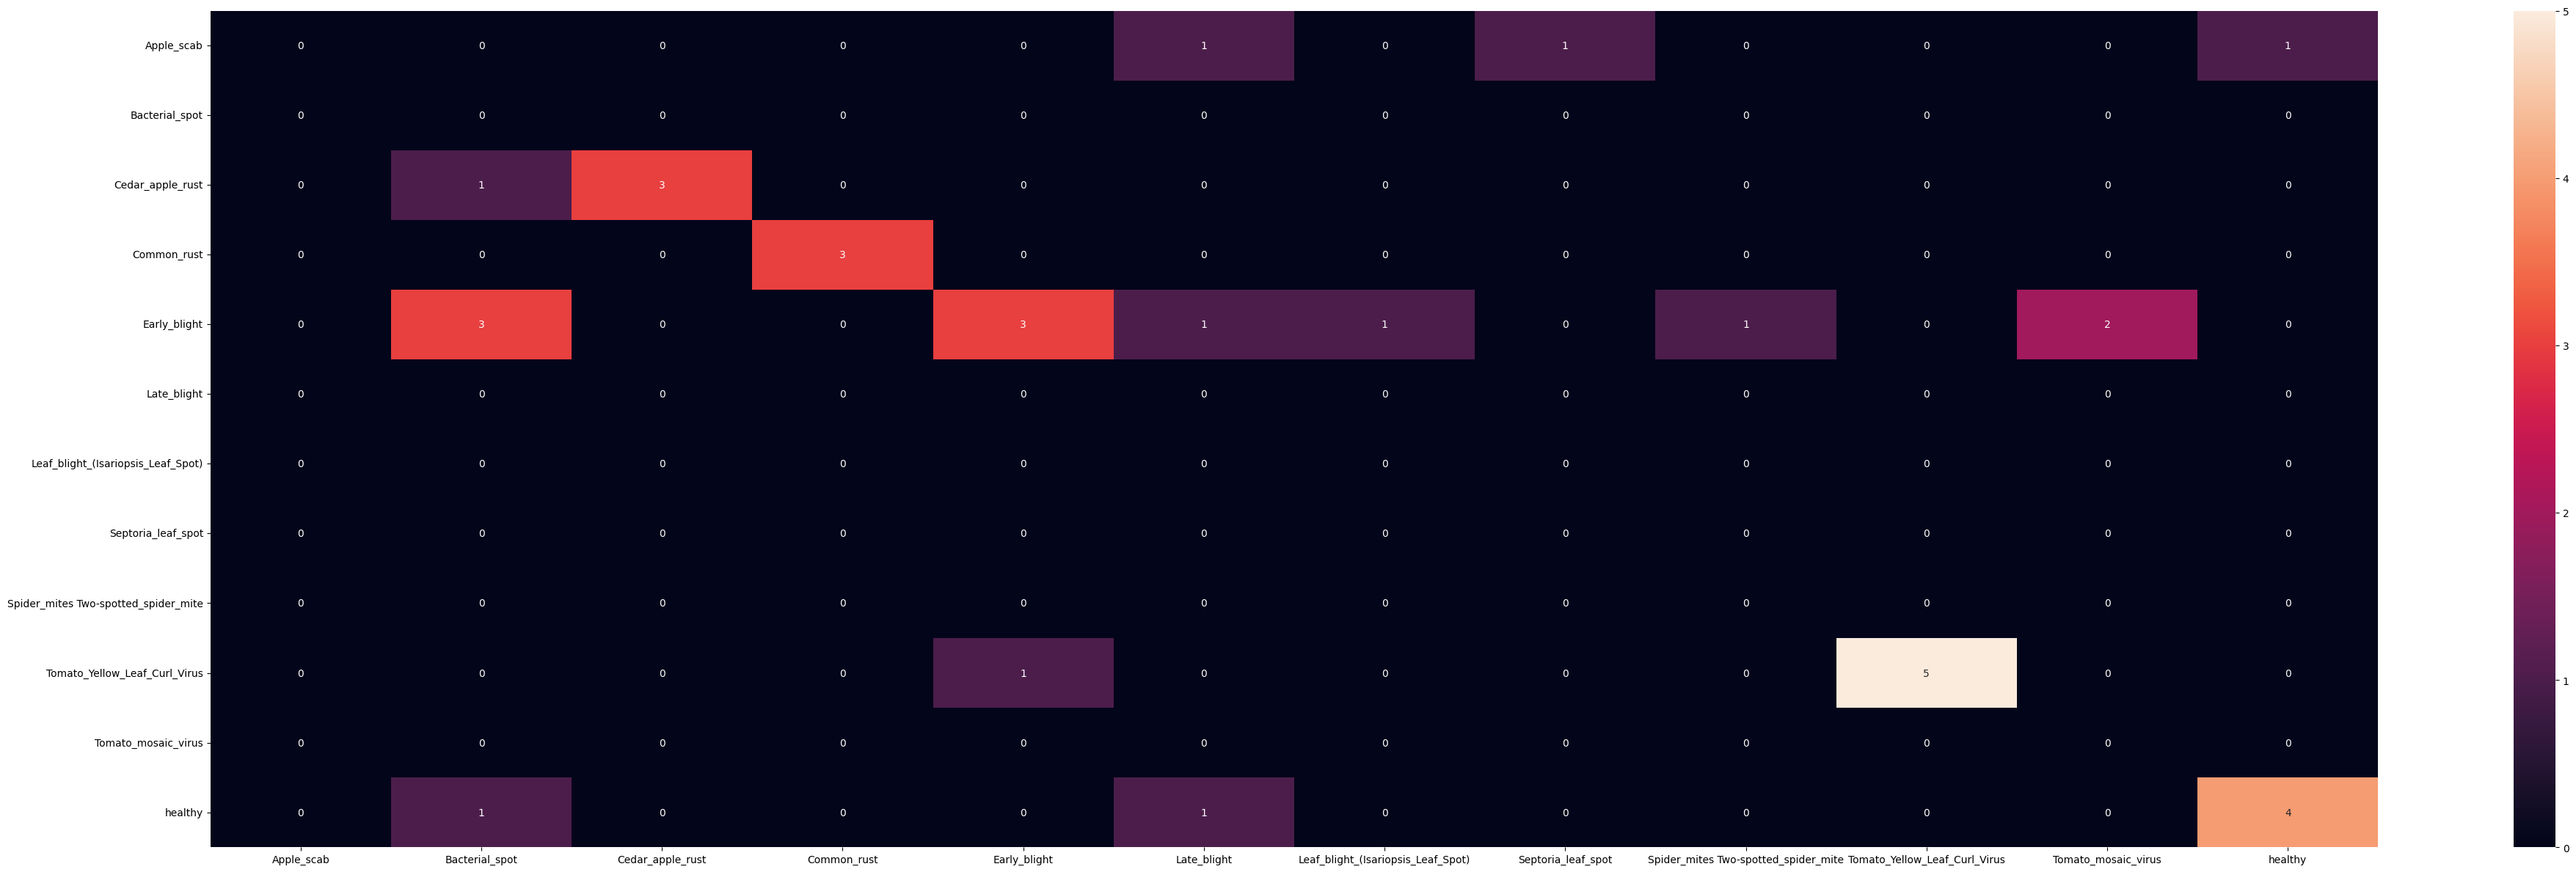

-------------------------------------------------------------------

-------------------------------------------------------------------

Adaboost-Decision Tree
	Plants Classification
	The accuracy score for the testing dataset is 0.9697
	The balanced accuracy score for the testing dataset is 0.9643
	Classification Report:
              precision    recall  f1-score   support

       Apple       1.00      0.86      0.92         7
  Corn_maize       1.00      1.00      1.00         3
      Potato       1.00      1.00      1.00         7
      Tomato       0.94      1.00      0.97        16

    accuracy                           0.97        33
   macro avg       0.99      0.96      0.97        33
weighted avg       0.97      0.97      0.97        33



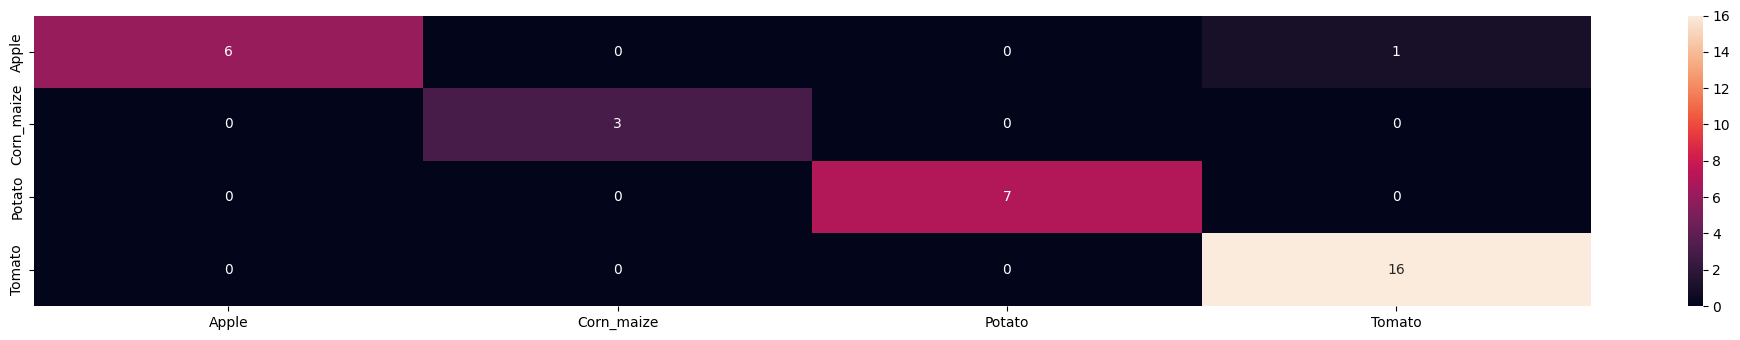

-------------------------------------------------------------------

	Diseases Classification
	The accuracy score for the testing dataset is 0.7576
	The balanced accuracy score for the testing dataset is 0.7449
	Classification Report:
                               precision    recall  f1-score   support

                   Apple_scab       1.00      0.33      0.50         3
               Bacterial_spot       0.00      0.00      0.00         0
             Cedar_apple_rust       1.00      0.50      0.67         4
                  Common_rust       1.00      1.00      1.00         3
                 Early_blight       1.00      0.64      0.78        11
                  Target_Spot       0.00      0.00      0.00         0
Tomato_Yellow_Leaf_Curl_Virus       1.00      1.00      1.00         6
                      healthy       0.60      1.00      0.75         6

                     accuracy                           0.76        33
                    macro avg       0.70      0.56   

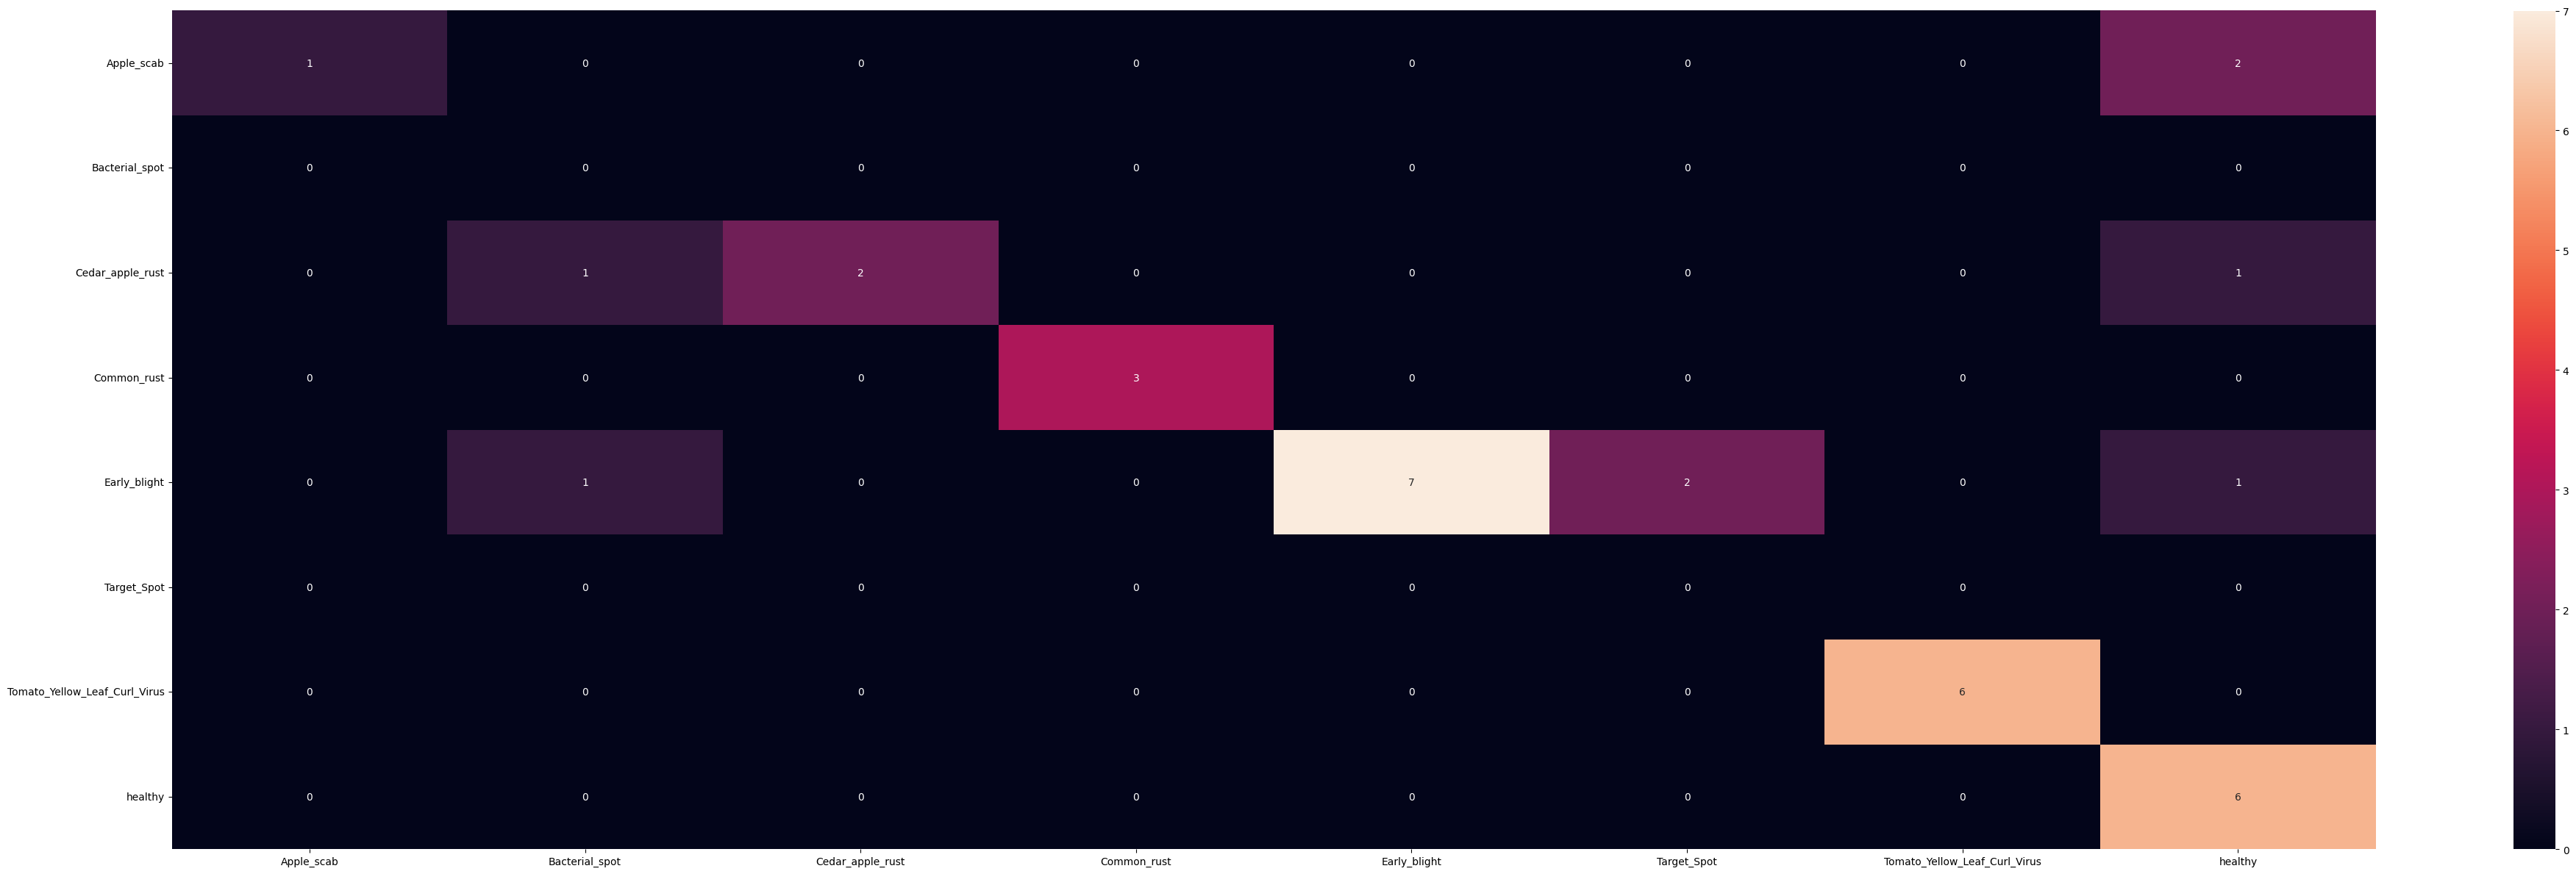

-------------------------------------------------------------------

-------------------------------------------------------------------

Voting Classifier
	Plants Classification
	The accuracy score for the testing dataset is 0.9697
	The balanced accuracy score for the testing dataset is 0.9643
	Classification Report:
              precision    recall  f1-score   support

       Apple       1.00      0.86      0.92         7
  Corn_maize       1.00      1.00      1.00         3
      Potato       1.00      1.00      1.00         7
      Tomato       0.94      1.00      0.97        16

    accuracy                           0.97        33
   macro avg       0.99      0.96      0.97        33
weighted avg       0.97      0.97      0.97        33



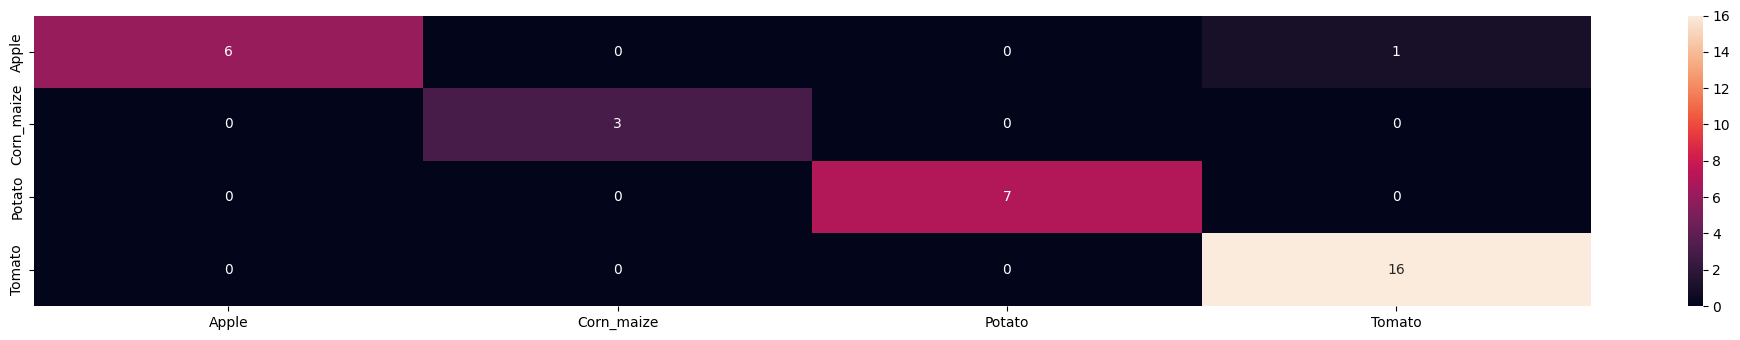

-------------------------------------------------------------------

	Diseases Classification
	The accuracy score for the testing dataset is 0.7879
	The balanced accuracy score for the testing dataset is 0.8005
	Classification Report:
                               precision    recall  f1-score   support

                   Apple_scab       1.00      0.67      0.80         3
               Bacterial_spot       0.00      0.00      0.00         0
             Cedar_apple_rust       1.00      0.50      0.67         4
                  Common_rust       1.00      1.00      1.00         3
                 Early_blight       1.00      0.64      0.78        11
                  Target_Spot       0.00      0.00      0.00         0
Tomato_Yellow_Leaf_Curl_Virus       1.00      1.00      1.00         6
                      healthy       0.67      1.00      0.80         6

                     accuracy                           0.79        33
                    macro avg       0.71      0.60   

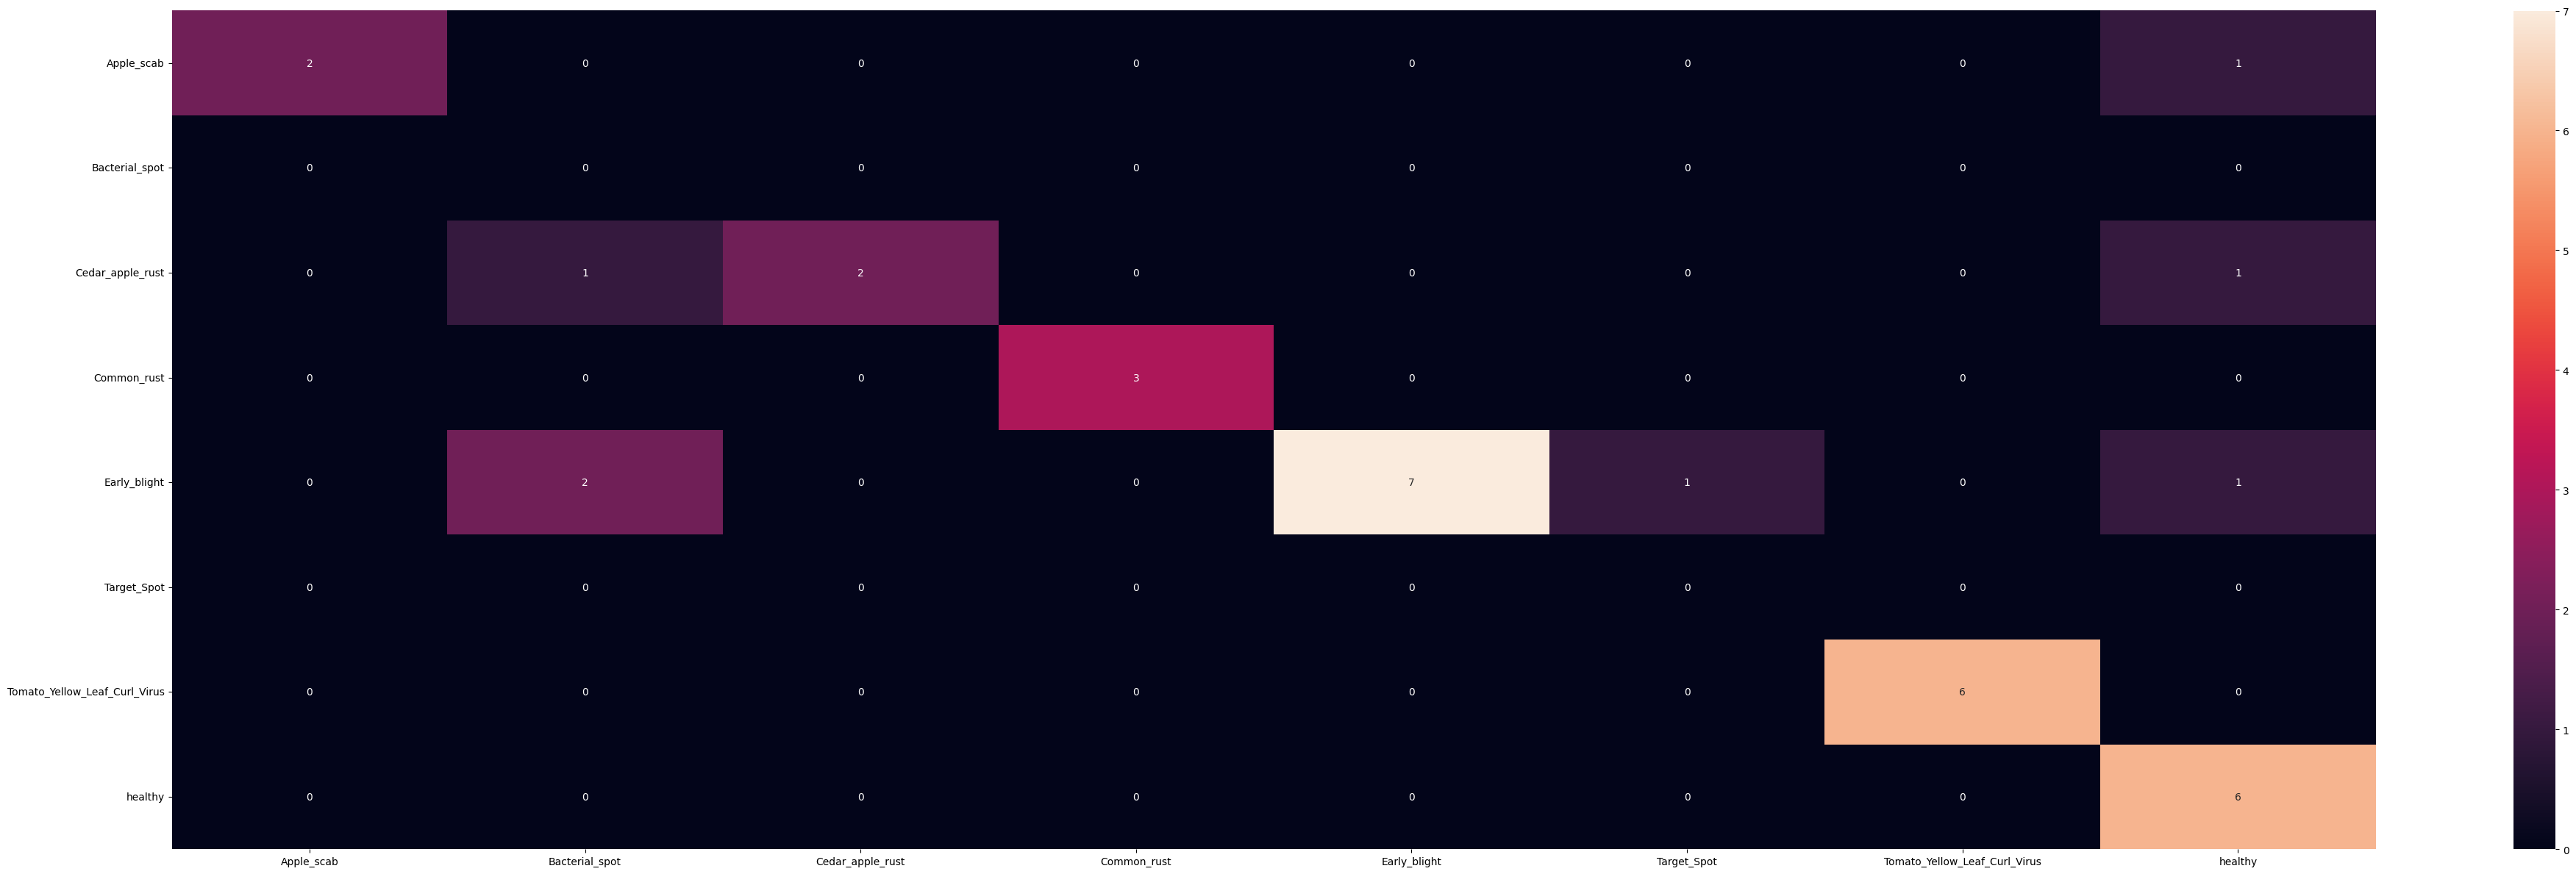

In [ ]:
#Test Data
warnings.filterwarnings('ignore')
#References:
#1. https://becominghuman.ai/extract-a-feature-vector-for-any-image-with-pytorch-9717561d1d4c
#2. https://stackoverflow.com/questions/61606416/runtimeerror-output-with-shape-512-doesnt-match-the-broadcast-shape-1-512


#Load the pretrained model
# model = models.resnet18(pretrained=True) #The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
model = models.resnet18(weights=ResNet18_Weights.DEFAULT)
#Use the model object to select the desired layer
layer = model._modules.get('avgpool')

#Set model to evaluation mode
model.eval()

#ResNet-18 expects images to be at least 224x224, as well as normalized with a specific mean and standard deviation
scaler = transforms.Resize((224, 224))
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                  std=[0.229, 0.224, 0.225])
to_tensor = transforms.ToTensor()

def extract_ResNet18_features(input_image_path):
  #Load the image with Pillow library
  img = Image.open(input_image_path)

  #Create a PyTorch Variable with the transformed image
  t_img = Variable(normalize(to_tensor(scaler(img))).unsqueeze(0))

  #Create a vector of zeros that will hold our feature vector
    #The 'avgpool' layer has an output size of 512
  features_of_image = torch.zeros(512)

  #Define a function that will copy the output of a layer
  def copy_data(m, i, o):
    features_of_image.copy_(o.data.reshape(o.data.size(1)))
    # features_of_image.copy_(o.data)
  #Attach that function to our selected layer
  h = layer.register_forward_hook(copy_data)

  #Run the model on our transformed image
  model(t_img)

  # Detach our copy function from the layer
  h.remove()

  # Return the feature vector
  return features_of_image.numpy()


path =  '/content/drive/MyDrive/EE769/project_dataset/test'

plants_list = []  #['Orange', 'Peach', 'Squash', 'Strawberry', 'Soyabean', 'Corn_maize', 'Apple', 'Grape', 'Potato', 'Pepper', 'Raspberry', 'Blueberry', 'Tomato', 'Cherry']
diseases_dict = {}
obj = os.scandir(path)
for entry in obj:
    if entry.is_dir():
        plants_list.append(entry.name)

print(plants_list)

features_array = []
target_plants_array = []
target_diseases_array = []

for x in plants_list:
  plants_path = path + str('/') + x
  temp_list = []
  obj = os.scandir(plants_path)
  for entry in obj:
    if entry.is_dir():
      temp_list.append(entry.name)
  diseases_dict[x] = temp_list
  for y in temp_list:
    disease_path = plants_path+ str('/') + y
    obj = os.scandir(disease_path)
    # count = 0
    for entry in obj:
      # if count<50:
      if entry.is_file():
         file_path = disease_path + str('/') + entry.name
         features_array.append(extract_ResNet18_features(file_path))
         target_plants_array.append(x)
         target_diseases_array.append(y)
      #   count += 1
      # else:
      #   break

rows = len(features_array)
cols = len(features_array[0])

print('-------------------------------------------------------------------\n')
print('Dimensions of features array list is ' + str(rows) + ' X ' + str(cols) + '\n')
print('-------------------------------------------------------------------\n')

#Converting feature data, target data into dataframes
features_list = []
for x in range(cols):
  features_list.append(str(x))
X = pd.DataFrame(features_array, columns = features_list)
y1_test = pd.DataFrame({'plant':target_plants_array})
y2_test = pd.DataFrame({'disease':target_diseases_array})

y1_test_classes = np.unique(y1_test) #plants
y2_test_classes = np.unique(y2_test) #diseases

print(y1_test.value_counts().reset_index())
print(y2_test.value_counts().reset_index())

# # Multivariate feature imputation
# imp = IterativeImputer(max_iter=10, random_state=10)
# imp = imp.fit(X)
# X1_train = imp.transform(X)
# X1_train = pd.DataFrame(X1_train, columns = X.columns)

X1_test = X
X2_test = X1_test


# df = pd.concat([X1_test, y1_test, y2_test], axis=1)
# df.to_csv('/content/drive/MyDrive/EE769/data_test.csv')

print('The obtained features data array is:')
display(pd.concat([X1_test, y1_test, y2_test], axis=1))
print('-------------------------------------------------------------------\n')
print('-------------------------------------------------------------------\n')

with open('/content/drive/MyDrive/EE769/L2_regularized_plants_model.bin','rb') as f_in1:
  l2_plants = pickle.load(f_in1)
with open('/content/drive/MyDrive/EE769/Random_forest_plants_model_Random.bin','rb') as f_in2:
  rf_plants = pickle.load(f_in2)
with open('/content/drive/MyDrive/EE769/Decision_tree_plants_model.bin','rb') as f_in3A:
  dt_plants = pickle.load(f_in3A)
with open('/content/drive/MyDrive/EE769/Adaboost_Decision_tree_plants_model.bin','rb') as f_in3B:
  ada_plants = pickle.load(f_in3B)
with open('/content/drive/MyDrive/EE769/Voting_classifier_plants_model.bin','rb') as f_in4:
  vote_plants = pickle.load(f_in4)
with open('/content/drive/MyDrive/EE769/L2_regularized_diseases_model.bin','rb') as f_in5:
  l2_diseases = pickle.load(f_in5)
with open('/content/drive/MyDrive/EE769/Random_forest_diseases_model_Random.bin','rb') as f_in6:
  rf_diseases = pickle.load(f_in6)
with open('/content/drive/MyDrive/EE769/Decision_tree_diseases_model.bin','rb') as f_in7A:
  dt_diseases = pickle.load(f_in7A)
with open('/content/drive/MyDrive/EE769/Adaboost_Decision_tree_diseases_model.bin','rb') as f_in7B:
  ada_diseases = pickle.load(f_in7B)
with open('/content/drive/MyDrive/EE769/Voting_classifier_diseases_model.bin','rb') as f_in8:
  vote_diseases = pickle.load(f_in8)

print('L2 regularized logistic regression')
print('\tPlants Classification')
y1_test_predicted = l2_plants.predict(X1_test)
pred_prob1 = l2_plants.predict_proba(X1_test)
print(f'\tThe accuracy score for the testing dataset is {accuracy_score(y1_test, y1_test_predicted):.4f}')
print(f'\tThe balanced accuracy score for the testing dataset is {balanced_accuracy_score(y1_test, y1_test_predicted):.4f}')
# print(f'\tThe roc_auc score for the testing dataset is {roc_auc_score(y1_test, pred_prob1[:,1]):.4f}')
print('\tClassification Report:')
print(classification_report(y1_test, y1_test_predicted))

plt.rcParams["figure.figsize"] = [20.00, 3.50]
plt.rcParams["figure.autolayout"] = True
y1_test_pred_classes = np.unique(y1_test_predicted) #plants
confusion_matrix_df = pd.DataFrame(confusion_matrix(y1_test, y1_test_predicted), columns=y1_test_pred_classes, index=y1_test_pred_classes)
sns.heatmap(confusion_matrix_df, annot=True)
plt.savefig('/content/drive/MyDrive/EE769/Testing_L2_Plants.png')
plt.show()
print('-------------------------------------------------------------------\n')
print('\tDiseases Classification')
y2_test_predicted = l2_diseases.predict(X2_test)
pred_prob2 = l2_diseases.predict_proba(X2_test)
print(f'\tThe accuracy score for the testing dataset is {accuracy_score(y2_test, y2_test_predicted):.4f}')
print(f'\tThe balanced accuracy score for the testing dataset is {balanced_accuracy_score(y2_test, y2_test_predicted):.4f}')
# print(f'\tThe roc_auc score for the testing dataset is {roc_auc_score(y1_test, pred_prob1[:,1]):.4f}')
print('\tClassification Report:')
print(classification_report(y2_test, y2_test_predicted))

plt.rcParams["figure.figsize"] = [40.00, 12]
plt.rcParams["figure.autolayout"] = True
y2_test_pred_classes = np.unique([*y2_test_classes , *np.unique(y2_test_predicted)]) #diseases
confusion_matrix_df = pd.DataFrame(confusion_matrix(y2_test, y2_test_predicted), columns=y2_test_pred_classes, index=y2_test_pred_classes)
sns.heatmap(confusion_matrix_df, annot=True)
plt.savefig('/content/drive/MyDrive/EE769/Testing_L2_Diseases.png')
plt.show()
print('-------------------------------------------------------------------\n')
print('-------------------------------------------------------------------\n')
print('Random Forest')
print('\tPlants Classification')
y1_test_predicted = rf_plants.predict(X1_test)
pred_prob1 = rf_plants.predict_proba(X1_test)
print(f'\tThe accuracy score for the testing dataset is {accuracy_score(y1_test, y1_test_predicted):.4f}')
print(f'\tThe balanced accuracy score for the testing dataset is {balanced_accuracy_score(y1_test, y1_test_predicted):.4f}')
# print(f'\tThe roc_auc score for the testing dataset is {roc_auc_score(y1_test, pred_prob1[:,1]):.4f}')
print('\tClassification Report:')
print(classification_report(y1_test, y1_test_predicted))

plt.rcParams["figure.figsize"] = [20.00, 3.50]
plt.rcParams["figure.autolayout"] = True
y1_test_pred_classes = np.unique(y1_test_predicted) #plants
confusion_matrix_df = pd.DataFrame(confusion_matrix(y1_test, y1_test_predicted), columns=y1_test_pred_classes, index=y1_test_pred_classes)
sns.heatmap(confusion_matrix_df, annot=True)
plt.savefig('/content/drive/MyDrive/EE769/Testing_Random_Forest_Plants.png')
plt.show()
print('-------------------------------------------------------------------\n')
print('\tDiseases Classification')
y2_test_predicted = rf_diseases.predict(X2_test)
pred_prob2 = rf_diseases.predict_proba(X2_test)
print(f'\tThe accuracy score for the testing dataset is {accuracy_score(y2_test, y2_test_predicted):.4f}')
print(f'\tThe balanced accuracy score for the testing dataset is {balanced_accuracy_score(y2_test, y2_test_predicted):.4f}')
# print(f'\tThe roc_auc score for the testing dataset is {roc_auc_score(y1_test, pred_prob1[:,1]):.4f}')
print('\tClassification Report:')
print(classification_report(y2_test, y2_test_predicted))

plt.rcParams["figure.figsize"] = [40.00, 12]
plt.rcParams["figure.autolayout"] = True
y2_test_pred_classes = np.unique([*y2_test_classes , *np.unique(y2_test_predicted)]) #diseases
confusion_matrix_df = pd.DataFrame(confusion_matrix(y2_test, y2_test_predicted), columns=y2_test_pred_classes, index=y2_test_pred_classes)
sns.heatmap(confusion_matrix_df, annot=True)
plt.savefig('/content/drive/MyDrive/EE769/Testing_Random_Forest_Diseases.png')
plt.show()
print('-------------------------------------------------------------------\n')
print('-------------------------------------------------------------------\n')
print('Decision Tree')
print('\tPlants Classification')
y1_test_predicted = dt_plants.predict(X1_test)
pred_prob1 = dt_plants.predict_proba(X1_test)
print(f'\tThe accuracy score for the testing dataset is {accuracy_score(y1_test, y1_test_predicted):.4f}')
print(f'\tThe balanced accuracy score for the testing dataset is {balanced_accuracy_score(y1_test, y1_test_predicted):.4f}')
# print(f'\tThe roc_auc score for the testing dataset is {roc_auc_score(y1_test, pred_prob1[:,1]):.4f}')
print('\tClassification Report:')
print(classification_report(y1_test, y1_test_predicted))

plt.rcParams["figure.figsize"] = [20.00, 3.50]
plt.rcParams["figure.autolayout"] = True
y1_test_pred_classes = np.unique(y1_test_predicted) #plants
confusion_matrix_df = pd.DataFrame(confusion_matrix(y1_test, y1_test_predicted), columns=y1_test_pred_classes, index=y1_test_pred_classes)
sns.heatmap(confusion_matrix_df, annot=True)
plt.savefig('/content/drive/MyDrive/EE769/Testing_Decision_tree_Plants.png')
plt.show()
print('-------------------------------------------------------------------\n')
print('\tDiseases Classification')
y2_test_predicted = dt_diseases.predict(X2_test)
pred_prob2 = dt_diseases.predict_proba(X2_test)
print(f'\tThe accuracy score for the testing dataset is {accuracy_score(y2_test, y2_test_predicted):.4f}')
print(f'\tThe balanced accuracy score for the testing dataset is {balanced_accuracy_score(y2_test, y2_test_predicted):.4f}')
# print(f'\tThe roc_auc score for the testing dataset is {roc_auc_score(y1_test, pred_prob1[:,1]):.4f}')
print('\tClassification Report:')
print(classification_report(y2_test, y2_test_predicted))

plt.rcParams["figure.figsize"] = [40.00, 12]
plt.rcParams["figure.autolayout"] = True
y2_test_pred_classes = np.unique([*y2_test_classes , *np.unique(y2_test_predicted)]) #diseases
confusion_matrix_df = pd.DataFrame(confusion_matrix(y2_test, y2_test_predicted), columns=y2_test_pred_classes, index=y2_test_pred_classes)
sns.heatmap(confusion_matrix_df, annot=True)
plt.savefig('/content/drive/MyDrive/EE769/Testing_Decision_tree_Diseases.png')
plt.show()

print('-------------------------------------------------------------------\n')
print('-------------------------------------------------------------------\n')

print('Adaboost-Decision Tree')
print('\tPlants Classification')
y1_test_predicted = ada_plants.predict(X1_test)
pred_prob1 = ada_plants.predict_proba(X1_test)
print(f'\tThe accuracy score for the testing dataset is {accuracy_score(y1_test, y1_test_predicted):.4f}')
print(f'\tThe balanced accuracy score for the testing dataset is {balanced_accuracy_score(y1_test, y1_test_predicted):.4f}')
# print(f'\tThe roc_auc score for the testing dataset is {roc_auc_score(y1_test, pred_prob1[:,1]):.4f}')
print('\tClassification Report:')
print(classification_report(y1_test, y1_test_predicted))

plt.rcParams["figure.figsize"] = [20.00, 3.50]
plt.rcParams["figure.autolayout"] = True
y1_test_pred_classes = np.unique(y1_test_predicted) #plants
confusion_matrix_df = pd.DataFrame(confusion_matrix(y1_test, y1_test_predicted), columns=y1_test_pred_classes, index=y1_test_pred_classes)
sns.heatmap(confusion_matrix_df, annot=True)
plt.savefig('/content/drive/MyDrive/EE769/Testing_Adaboost_Decision_tree_Plants.png')
plt.show()
print('-------------------------------------------------------------------\n')
print('\tDiseases Classification')
y2_test_predicted = ada_diseases.predict(X2_test)
pred_prob2 = ada_diseases.predict_proba(X2_test)
print(f'\tThe accuracy score for the testing dataset is {accuracy_score(y2_test, y2_test_predicted):.4f}')
print(f'\tThe balanced accuracy score for the testing dataset is {balanced_accuracy_score(y2_test, y2_test_predicted):.4f}')
# print(f'\tThe roc_auc score for the testing dataset is {roc_auc_score(y1_test, pred_prob1[:,1]):.4f}')
print('\tClassification Report:')
print(classification_report(y2_test, y2_test_predicted))

plt.rcParams["figure.figsize"] = [40.00, 12]
plt.rcParams["figure.autolayout"] = True
y2_test_pred_classes = np.unique([*y2_test_classes , *np.unique(y2_test_predicted)]) #diseases
confusion_matrix_df = pd.DataFrame(confusion_matrix(y2_test, y2_test_predicted), columns=y2_test_pred_classes, index=y2_test_pred_classes)
sns.heatmap(confusion_matrix_df, annot=True)
plt.savefig('/content/drive/MyDrive/EE769/Testing_Adaboost_Decision_tree_Diseases.png')
plt.show()

print('-------------------------------------------------------------------\n')
print('-------------------------------------------------------------------\n')
print('Voting Classifier')
print('\tPlants Classification')
y1_test_predicted = vote_plants.predict(X1_test)
# pred_prob1 = vote_plants.predict_proba(X1_test)
print(f'\tThe accuracy score for the testing dataset is {accuracy_score(y1_test, y1_test_predicted):.4f}')
print(f'\tThe balanced accuracy score for the testing dataset is {balanced_accuracy_score(y1_test, y1_test_predicted):.4f}')
# print(f'\tThe roc_auc score for the testing dataset is {roc_auc_score(y1_test, pred_prob1[:,1]):.4f}')
print('\tClassification Report:')
print(classification_report(y1_test, y1_test_predicted))

plt.rcParams["figure.figsize"] = [20.00, 3.50]
plt.rcParams["figure.autolayout"] = True
y1_test_pred_classes = np.unique(y1_test_predicted) #plants
confusion_matrix_df = pd.DataFrame(confusion_matrix(y1_test, y1_test_predicted), columns=y1_test_pred_classes, index=y1_test_pred_classes)
sns.heatmap(confusion_matrix_df, annot=True)
plt.savefig('/content/drive/MyDrive/EE769/Testing_Voting_Classifier_Plants.png')
plt.show()
print('-------------------------------------------------------------------\n')
print('\tDiseases Classification')
y2_test_predicted = vote_diseases.predict(X2_test)
# pred_prob2 = vote_diseases.predict_proba(X2_test)
print(f'\tThe accuracy score for the testing dataset is {accuracy_score(y2_test, y2_test_predicted):.4f}')
print(f'\tThe balanced accuracy score for the testing dataset is {balanced_accuracy_score(y2_test, y2_test_predicted):.4f}')
# print(f'\tThe roc_auc score for the testing dataset is {roc_auc_score(y1_test, pred_prob1[:,1]):.4f}')
print('\tClassification Report:')
print(classification_report(y2_test, y2_test_predicted))

plt.rcParams["figure.figsize"] = [40.00, 12]
plt.rcParams["figure.autolayout"] = True
y2_test_pred_classes = np.unique([*y2_test_classes , *np.unique(y2_test_predicted)]) #diseases
confusion_matrix_df = pd.DataFrame(confusion_matrix(y2_test, y2_test_predicted), columns=y2_test_pred_classes, index=y2_test_pred_classes)
sns.heatmap(confusion_matrix_df, annot=True)
plt.savefig('/content/drive/MyDrive/EE769/Testing_Voting_Classifier_Diseases.png')
plt.show()


## Task-8A: Predictor-5
### Set up the GPU

In [ ]:
# Set up the GPU device
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))



Found GPU at: /device:GPU:0


## Task-8A: Predictor-5
### Deep Learning Model - Plants Classification - Training

In [ ]:
# Set up the training and validation data
X1_train,y1_train,X2_train,y2_train,X1_valid,y1_valid,X2_valid,y2_valid,y1_classes,y2_classes,y1_valid_classes,y2_valid_classes = initialize_train_valid_data()

# Define the number of features and classes in your data
num_features = X1_train.shape[1]
num_classes = len(y1_classes)

label_encoder = LabelEncoder()
y1_train = label_encoder.fit_transform(y1_train)
y1_valid = label_encoder.transform(y1_valid)

# Convert the output labels to one-hot encoded form
y1_train = to_categorical(y1_train, num_classes=num_classes)
y1_valid = to_categorical(y1_valid, num_classes=num_classes)

# Define the number of features and classes in your data
print(num_features)
print(num_classes)

# create plant model 
plant_model = Sequential()
plant_model.add(Dense(512, activation='relu', input_shape=(num_features,)))
plant_model.add(Dropout(0.5))
plant_model.add(Dense(256, activation='relu'))
plant_model.add(Dropout(0.5))
plant_model.add(Dense(128, activation='relu'))
plant_model.add(Dropout(0.5))
plant_model.add(Dense(64, activation='relu'))
plant_model.add(Dropout(0.5))
plant_model.add(Dense(32, activation='relu'))
plant_model.add(Dropout(0.5))
plant_model.add(Dense(num_classes, activation='softmax'))

# # compile plant model
plant_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Set the parameters for training the model
num_epochs = 200
batch_size = 32
steps_per_epoch = int(np.ceil(len(X1_train) / batch_size))

# train plant model
with tf.device('/device:GPU:0'):
  plant_model.fit(
      X1_train,
      y1_train,
      epochs=num_epochs,
      steps_per_epoch = steps_per_epoch,
      validation_data=(X1_valid,y1_valid))

# save plant model
plant_model.save('/content/drive/MyDrive/EE769/plant_model.h5')

## Task-8A: Predictor-5
### Deep Learning Model - Creating diseases models for each plant - Training

In [ ]:
# Set up the training and validation data
X1_train,y1_train,X2_train,y2_train,X1_valid,y1_valid,X2_valid,y2_valid,y1_classes,y2_classes,y1_valid_classes,y2_valid_classes = initialize_train_valid_data()

# Define the number of features and classes in your data
num_features = X2_train.shape[1]
num_classes = len(y2_classes)

label_encoder = LabelEncoder()
y2_train = label_encoder.fit_transform(y2_train)
y2_valid = label_encoder.transform(y2_valid)

# Convert the output labels to one-hot encoded form
y2_train = to_categorical(y2_train, num_classes=num_classes)
y2_valid = to_categorical(y2_valid, num_classes=num_classes)


# Load the plant model and remove the last layer
plant_model = load_model('/content/drive/MyDrive/EE769/plant_model.h5')
plant_model.layers.pop()

# Freeze the layers in the plant model
for layer in plant_model.layers:
    layer.trainable = False

def get_plant_data_indexes(plant_folder):
  data_train = pd.read_csv('/content/drive/MyDrive/EE769/data_tain.csv')
  data_valid = pd.read_csv('/content/drive/MyDrive/EE769/data_valid.csv')
  train_indexes = data_train.index[data_train['plant'] == plant_folder].tolist()
  valid_indexes = data_valid.index[data_valid['plant'] == plant_folder].tolist()
  return train_indexes,valid_indexes

# create disease models using transfer learning
for plant_folder in y1_classes:
    print(plant_folder)
    train_indexes,valid_indexes = get_plant_data_indexes(plant_folder)
    X2_train_plant = X2_train.iloc[train_indexes]
    y2_train_plant = y2_train[train_indexes]
    X2_valid_plant = X2_valid.iloc[valid_indexes]
    y2_valid_plant = y2_valid[valid_indexes]

    disease_model_name = plant_folder+"_disease_model"
    disease_model = Sequential(name=disease_model_name)
    disease_model.add(plant_model)
    disease_model.add(Flatten())
    disease_model.add(Dense(512, activation='relu'))
    disease_model.add(Dropout(0.5))
    disease_model.add(Dense(256, activation='relu'))
    disease_model.add(Dropout(0.5))
    disease_model.add(Dense(128, activation='relu'))
    disease_model.add(Dropout(0.5))
    disease_model.add(Dense(64, activation='relu'))
    disease_model.add(Dropout(0.5))
    disease_model.add(Dense(32, activation='relu'))
    disease_model.add(Dropout(0.5))
    disease_model.add(Dense(num_classes, activation='softmax'))
    disease_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy']) 

    # Set the parameters for training the model
    num_epochs = 25
    batch_size = 16
    steps_per_epoch = int(np.ceil(len(X2_train_plant) / batch_size))

    with tf.device('/device:GPU:0'):
      disease_model.fit(
      X2_train_plant,
      y2_train_plant,
      epochs=num_epochs,
      steps_per_epoch = steps_per_epoch,
      validation_data=(X2_valid_plant,y2_valid_plant))
    disease_model.save(f'/content/drive/MyDrive/EE769/models/{plant_folder}_disease_model.h5')

## Task-8A: Predictor-5
### Deep Learning Model - Merging all the disease models into a single model - Training

In [ ]:
# Set up the training and validation data
X1_train,y1_train,X2_train,y2_train,X1_valid,y1_valid,X2_valid,y2_valid,y1_classes,y2_classes,y1_valid_classes,y2_valid_classes = initialize_train_valid_data()

# Set the parameters for training the model
num_epochs = 50
batch_size = 32
steps_per_epoch = int(np.ceil(len(X2_train) / batch_size))

# Define the number of features and classes in your data
num_features = X2_train.shape[1]
num_classes = len(y2_classes)

label_encoder = LabelEncoder()
y2_train = label_encoder.fit_transform(y2_train)
y2_valid = label_encoder.transform(y2_valid)

# Convert the output labels to one-hot encoded form
y2_train = to_categorical(y2_train, num_classes=num_classes)
y2_valid = to_categorical(y2_valid, num_classes=num_classes)


#merging diseases models 
disease_models_path = '/content/drive/MyDrive/EE769/models'

disease_models = []

for filename in os.listdir(disease_models_path):
    if filename.endswith('.h5'):
        model_path = os.path.join(disease_models_path, filename)
        model = load_model(model_path)
        # Create a new input layer with the desired name
        new_input = Input(shape=model.input_shape[1:], name=filename)
        hidden_layer = Dense(64, activation='relu')(new_input)
        output_layer = Dense(num_classes, activation='softmax')(hidden_layer)
        # Create a new model with the new input layer
        new_model = Model(inputs=new_input, outputs=output_layer)
        new_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
        disease_models.append(new_model)

# merge models
input_layer = Input(shape=(num_features,))
outputs = [model(input_layer) for model in disease_models]
concatenated_output = Concatenate()(outputs)
hidden_layer = Dense(128, activation='relu')(concatenated_output) # hidden layer
final_output = Dense(num_classes, activation='softmax')(hidden_layer) #num_classes =21 (num of unique diseases)
merged_disease_model = Model(inputs=input_layer, outputs=final_output)

# compile new model
merged_disease_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# merged_disease_model.summary()
with tf.device('/device:GPU:0'):
  merged_disease_model.fit(
      X2_train,
      y2_train,
      epochs=num_epochs,
      steps_per_epoch = steps_per_epoch,
      validation_data=(X2_valid_plant,y2_valid_plant))
  merged_disease_model.save(f'/content/drive/MyDrive/EE769/merged_disease_model.h5')

merged_disease_model.summary()

## Task-8B: Predictor-5
### Deep Learning Model - Validation

550/550 [==============================] - 1s 2ms/step
Plants Classifaction:
              precision    recall  f1-score   support

           0       0.99      0.58      0.73      1943
           1       0.09      0.05      0.06       454
           2       0.45      0.95      0.61       877
           3       1.00      1.00      1.00      1829
           4       0.99      0.99      0.99      1805
           5       0.00      0.00      0.00       503
           6       0.32      0.01      0.02       891
           7       0.40      0.90      0.55       975
           8       0.99      0.86      0.92      1426
           9       0.45      0.60      0.51       445
          10       0.45      0.90      0.60       505
          11       1.00      1.00      1.00       434
          12       1.00      0.58      0.73       900
          13       0.96      0.98      0.97      4585

    accuracy                           0.79     17572
   macro avg       0.65      0.67      0.62     17572
wei

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


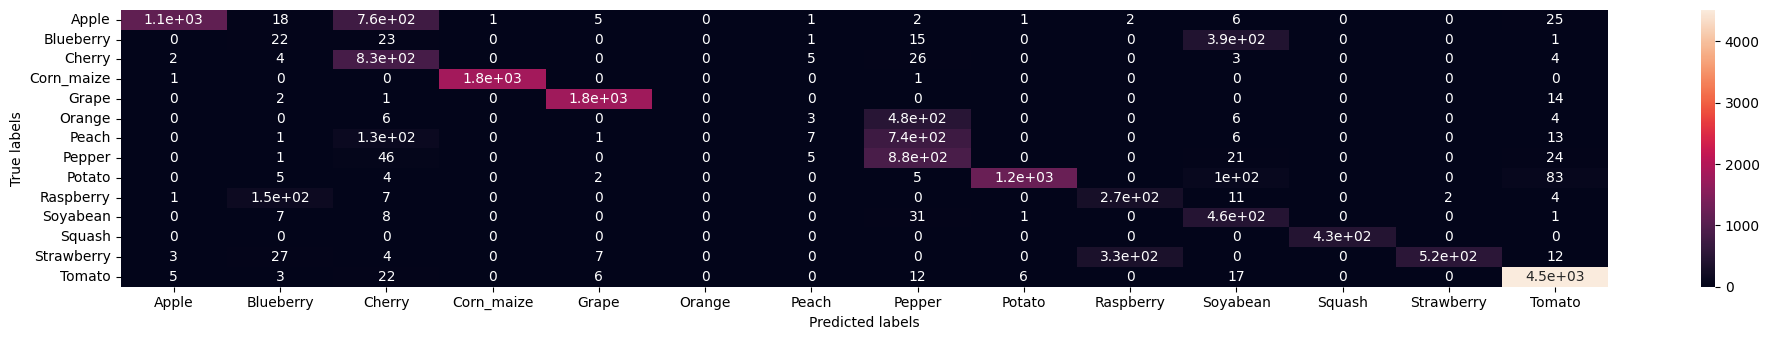

550/550 [==============================] - 2s 2ms/step
Diseases Classifaction:
              precision    recall  f1-score   support

           0       0.95      0.99      0.97       504
           1       0.97      0.97      0.97      1362
           2       0.98      0.98      0.98       969
           3       0.99      0.98      0.98       440
           4       0.96      0.95      0.95       410
           5       1.00      1.00      1.00       477
           6       0.93      0.95      0.94       965
           7       0.98      0.98      0.98       480
           8       1.00      0.99      1.00       503
           9       0.94      0.98      0.96       948
          10       0.93      0.96      0.95       470
          11       0.99      0.99      0.99       430
          12       0.99      0.99      0.99       444
          13       0.95      0.96      0.96       477
          14       1.00      0.99      1.00       855
          15       0.91      0.86      0.89       436
  

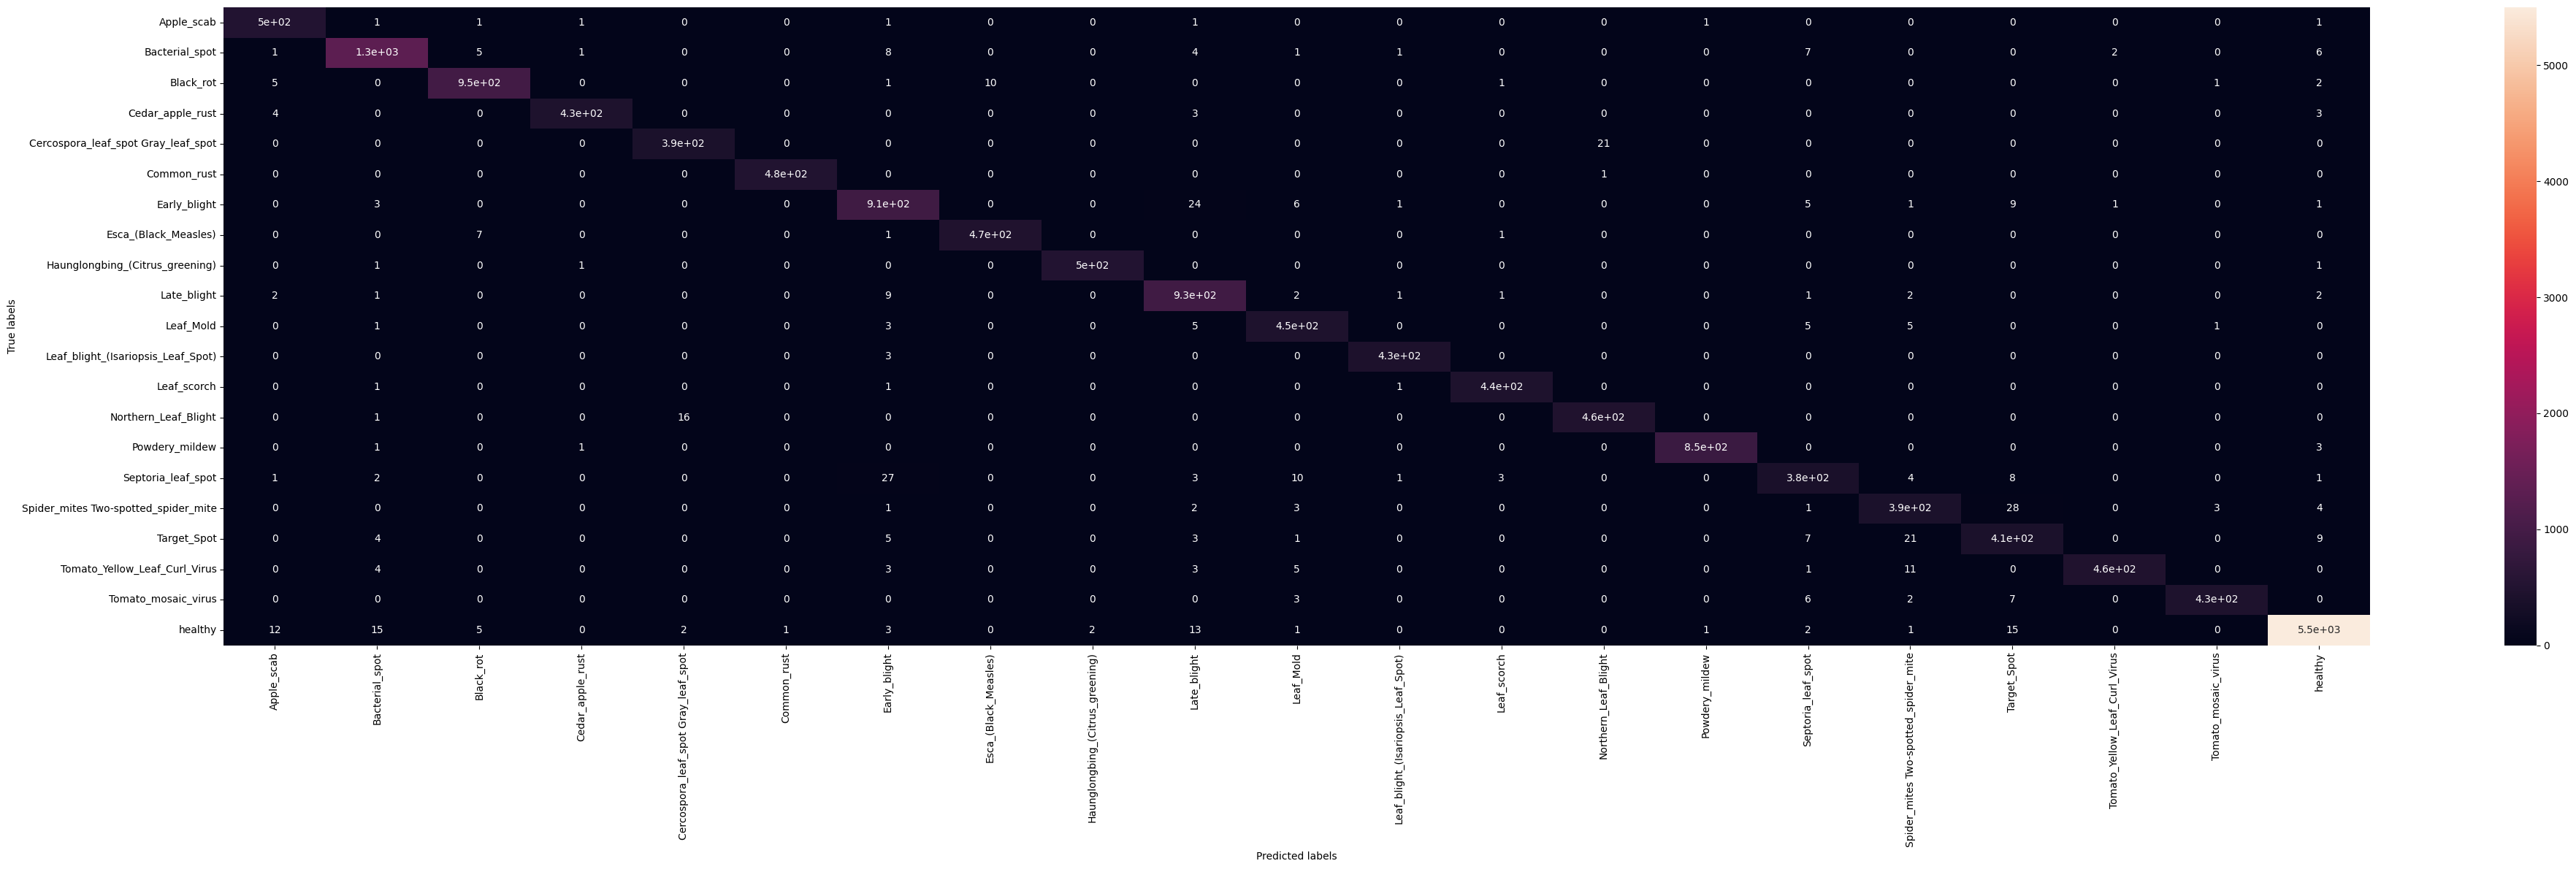

In [ ]:
# Set up the training and validation data
X1_train,y1_train,X2_train,y2_train,X1_valid,y1_valid,X2_valid,y2_valid,y1_classes,y2_classes,y1_valid_classes,y2_valid_classes = initialize_train_valid_data()

label_encoder = LabelEncoder()
y1_train = label_encoder.fit_transform(y1_train)
y1_valid = label_encoder.transform(y1_valid)
plant_class_names = label_encoder.classes_

# Convert the output labels to one-hot encoded form
y1_valid = to_categorical(y1_valid, num_classes=len(y1_classes))

#Load plants model
plant_model = load_model('/content/drive/MyDrive/EE769/plant_model.h5')

# assume y1_valid is the one-hot encoded validation labels
plant_pred = plant_model.predict(X1_valid)
plant_pred_labels = np.argmax(plant_pred, axis=1)
plant_true_labels = np.argmax(y1_valid, axis=1)

# print plnats classification report
print('Plants Classifaction:')
print(classification_report(plant_true_labels, plant_pred_labels))

plt.rcParams["figure.figsize"] = [20.00, 3.50]
plt.rcParams["figure.autolayout"] = True
plants_cm = confusion_matrix(plant_true_labels, plant_pred_labels)
sns.heatmap(plants_cm, annot=True, xticklabels=plant_class_names, yticklabels=plant_class_names)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.savefig('/content/drive/MyDrive/EE769/Plants_model_deep_learning.png')
plt.show()

label_encoder = LabelEncoder()
y2_train = label_encoder.fit_transform(y2_train)
y2_valid = label_encoder.transform(y2_valid)
disease_class_names = label_encoder.classes_

# Convert the output labels to one-hot encoded form
y2_valid = to_categorical(y2_valid, num_classes=len(y2_classes))

#Load disease model
merged_disease_model = load_model('/content/drive/MyDrive/EE769/merged_disease_model.h5')

# assume y2_valid is the one-hot encoded validation labels
disease_pred = merged_disease_model.predict(X2_valid)
disease_pred_labels = np.argmax(disease_pred, axis=1)
disease_true_labels = np.argmax(y2_valid, axis=1)

# print plnats classification report
print('Diseases Classifaction:')
print(classification_report(disease_true_labels, disease_pred_labels))

plt.rcParams["figure.figsize"] = [40.00, 12]
plt.rcParams["figure.autolayout"] = True
disease_cm = confusion_matrix(disease_true_labels, disease_pred_labels)
sns.heatmap(disease_cm, annot=True, xticklabels=disease_class_names, yticklabels=disease_class_names)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.savefig('/content/drive/MyDrive/EE769/Disease_model_deep_learning.png')
plt.show()

## Task-8C: Predictor-5
### Deep Learning Model - Testing

2/2 [==============================] - 0s 13ms/step
Plants Classifaction:
              precision    recall  f1-score   support

       Apple       1.00      0.14      0.25         7
      Cherry       0.00      0.00      0.00         0
  Corn_maize       1.00      1.00      1.00         3
      Potato       1.00      1.00      1.00         7
      Tomato       1.00      1.00      1.00        16

    accuracy                           0.82        33
   macro avg       0.80      0.63      0.65        33
weighted avg       1.00      0.82      0.84        33



/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


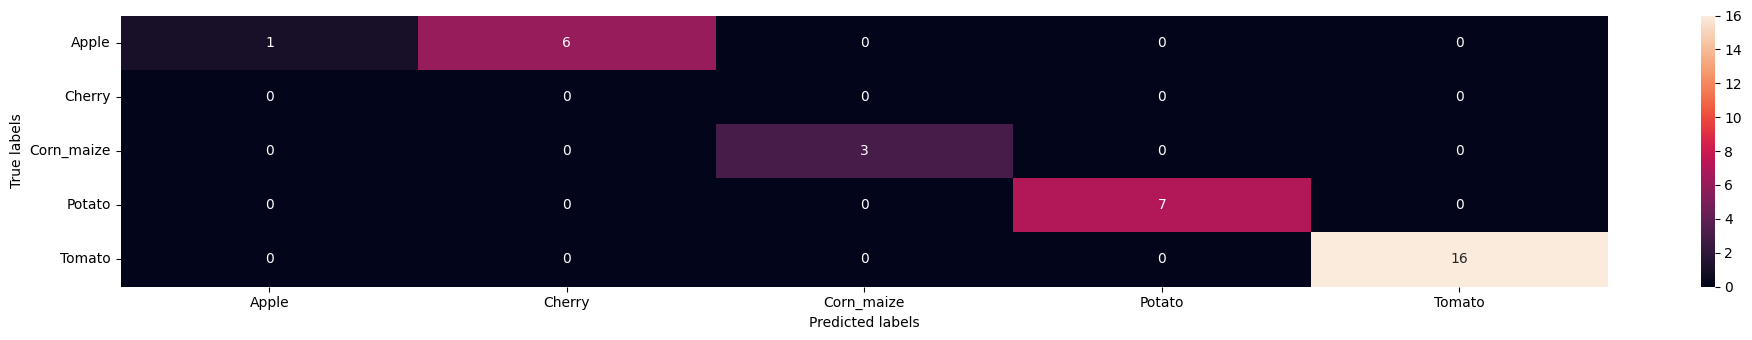

2/2 [==============================] - 0s 7ms/step
Diseases Classifaction:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           3       1.00      1.00      1.00         4
           5       1.00      1.00      1.00         3
           6       1.00      1.00      1.00        11
           9       0.00      0.00      0.00         0
          18       1.00      1.00      1.00         6
          20       1.00      0.83      0.91         6

    accuracy                           0.97        33
   macro avg       0.86      0.83      0.84        33
weighted avg       1.00      0.97      0.98        33



/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


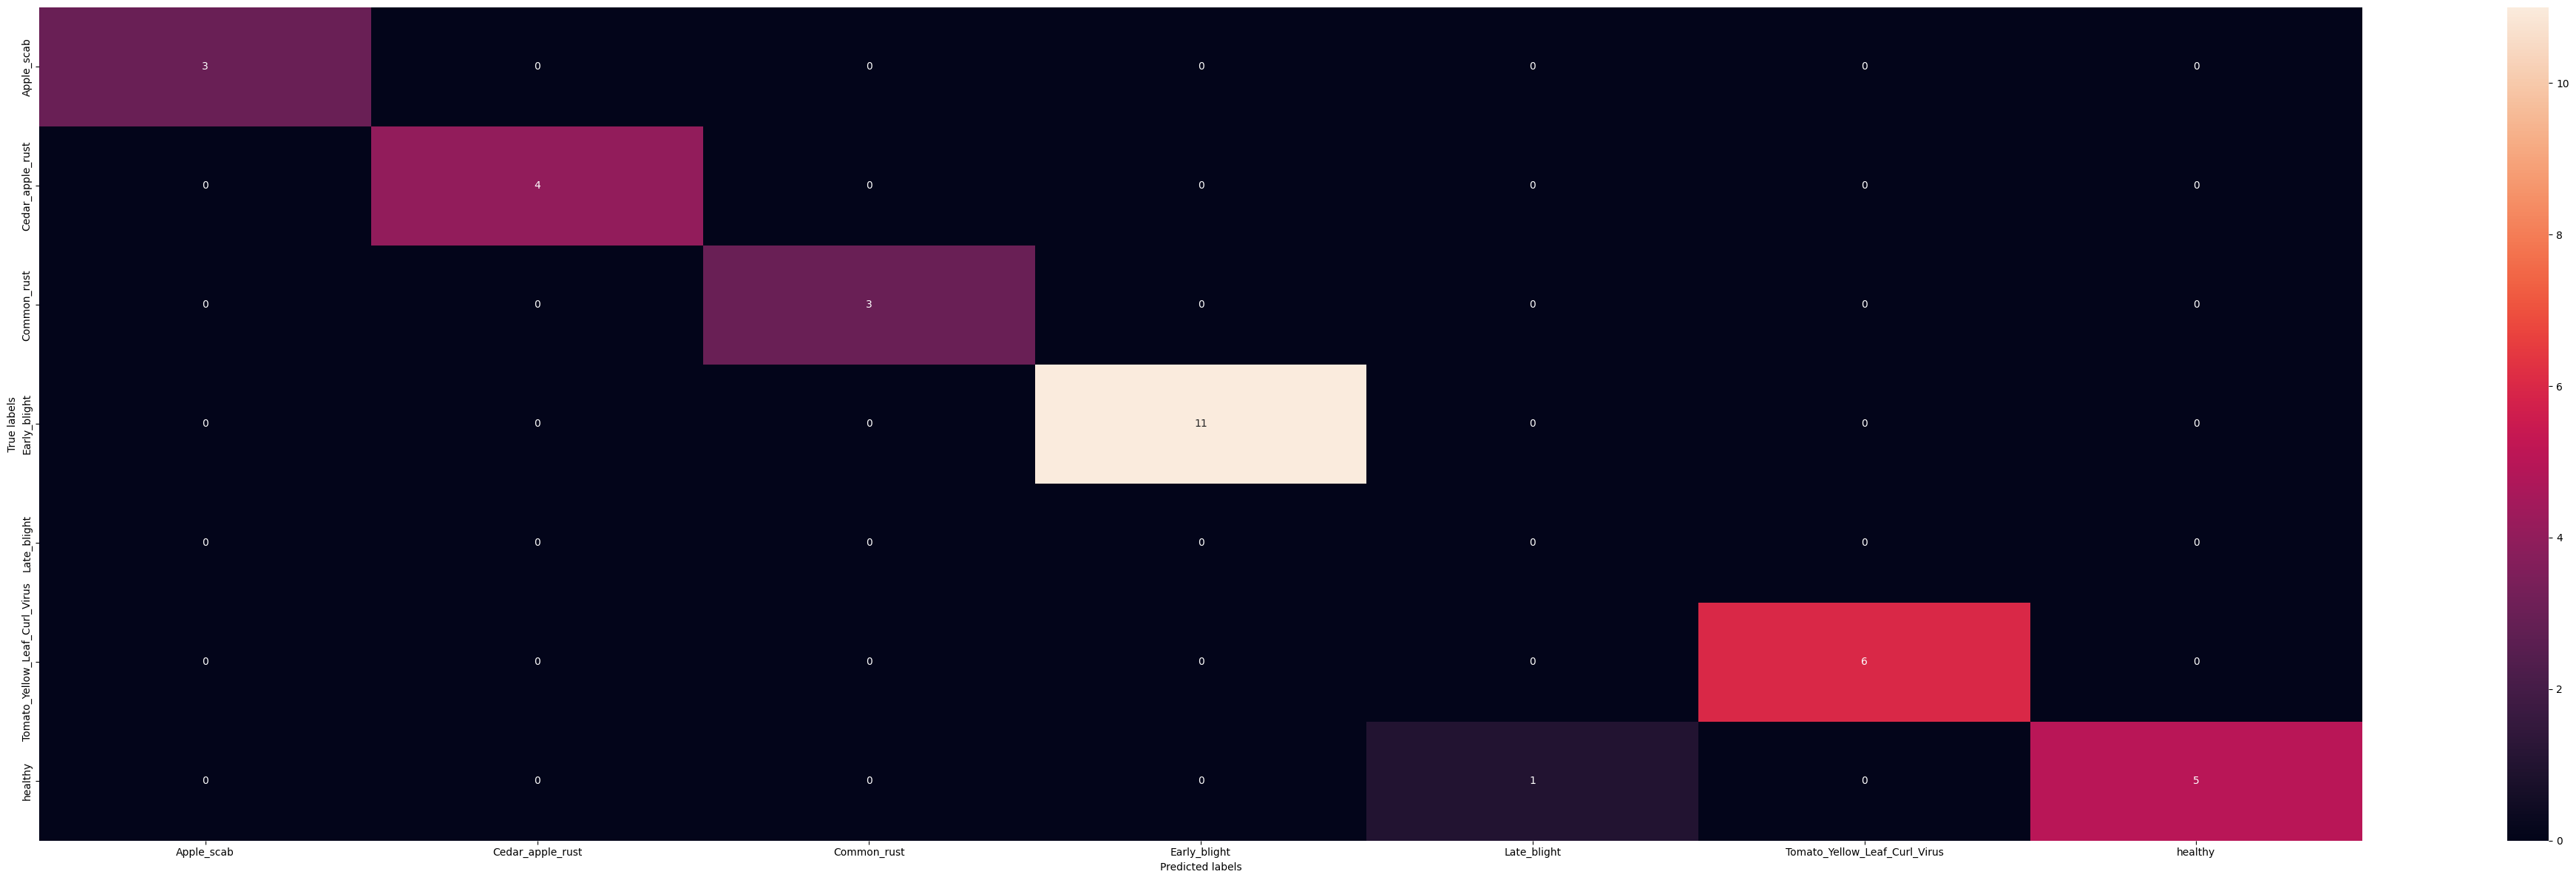

In [ ]:
# Set up the training and validation data
X1_train,y1_train,X2_train,y2_train,X1_valid,y1_valid,X2_valid,y2_valid,y1_classes,y2_classes,y1_valid_classes,y2_valid_classes = initialize_train_valid_data()


# Set up the testing data
data_test = pd.read_csv('/content/drive/MyDrive/EE769/data_test.csv')
features_list = list( data_test.loc[:][:1] )[1:-2]
target_list  = list( data_test.loc[:][:1] )[-2:]
#Extracting feature data from csv
X1_test  = data_test.loc[:,features_list]
X2_test = X1_test
#Extracting plants target data from csv
y1_test = data_test.loc[:,target_list[0]]
#Extracting diseases target data from csv
y2_test = data_test.loc[:,target_list[1]]
y1_test_classes = np.unique(y1_test) #plants
y2_test_classes = np.unique(y2_test) #diseases
# ------------------------------------------

label_encoder = LabelEncoder()
y1_train = label_encoder.fit_transform(y1_train)
y1_test = label_encoder.transform(y1_test)
# plant_class_names = label_encoder.classes_

# Convert the output labels to one-hot encoded form
y1_test = to_categorical(y1_test,num_classes=len(y1_classes))

#Load plants model
plant_model = load_model('/content/drive/MyDrive/EE769/plant_model.h5')

# assume y1_test is the one-hot encoded validation labels
plant_pred = plant_model.predict(X1_test)
plant_pred_labels = np.argmax(plant_pred, axis=1)
plant_true_labels = np.argmax(y1_test, axis=1)

labels = np.unique(np.concatenate((plant_true_labels, plant_pred_labels), axis=0))
class_names = label_encoder.inverse_transform(labels)

# print plants classification report
print('Plants Classifaction:')
print(classification_report(plant_true_labels, plant_pred_labels, target_names=class_names))

plt.rcParams["figure.figsize"] = [20.00, 3.50]
plt.rcParams["figure.autolayout"] = True
plants_cm = confusion_matrix(plant_true_labels, plant_pred_labels, labels=labels)
sns.heatmap(plants_cm, annot=True, xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.savefig('/content/drive/MyDrive/EE769/Testing_Plants_model_deep_learning.png')
plt.show()


label_encoder = LabelEncoder()
y2_train = label_encoder.fit_transform(y2_train)
y2_test = label_encoder.transform(y2_test)
# disease_class_names = label_encoder.classes_

# Convert the output labels to one-hot encoded form
y2_test = to_categorical(y2_test, num_classes=len(y2_classes))

#Load disease model
merged_disease_model = load_model('/content/drive/MyDrive/EE769/merged_disease_model.h5')

# assume y2_valid is the one-hot encoded validation labels
disease_pred = merged_disease_model.predict(X2_test)
disease_pred_labels = np.argmax(disease_pred, axis=1)
disease_true_labels = np.argmax(y2_test, axis=1)

labels = np.unique(np.concatenate((disease_true_labels, disease_pred_labels), axis=0))
class_names = label_encoder.inverse_transform(labels)

# print plnats classification report
print('Diseases Classifaction:')
print(classification_report(disease_true_labels, disease_pred_labels))

plt.rcParams["figure.figsize"] = [40.00, 12]
plt.rcParams["figure.autolayout"] = True
disease_cm = confusion_matrix(disease_true_labels, disease_pred_labels,labels=labels)
sns.heatmap(disease_cm, annot=True, xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.savefig('/content/drive/MyDrive/EE769/Testing_Disease_model_deep_learning.png')
plt.show()

## Task-8D: Predictor-5
### Deep Learning Model - Saving label encoding as a file

In [ ]:
# Set up the training and validation data
X1_train,y1_train,X2_train,y2_train,X1_valid,y1_valid,X2_valid,y2_valid,y1_classes,y2_classes,y1_valid_classes,y2_valid_classes = initialize_train_valid_data()

label_encoder = LabelEncoder()
y1_train = label_encoder.fit_transform(y1_train)
with open('/content/drive/MyDrive/EE769/plants_encoder.pkl', 'wb') as f:
    pickle.dump(label_encoder, f)

label_encoder = LabelEncoder()
y2_train = label_encoder.fit_transform(y2_train)
with open('/content/drive/MyDrive/EE769/diseases_encoder.pkl', 'wb') as f:
    pickle.dump(label_encoder, f)

## Task-8D: Predictor-5
### Deep Learning Model - Deployment Trail run

In [ ]:
#Load models
plant_model = load_model('/content/drive/MyDrive/EE769/plant_model.h5')
disease_model = load_model('/content/drive/MyDrive/EE769/merged_disease_model.h5')

with open('/content/drive/MyDrive/EE769/plants_encoder.pkl', 'rb') as f1:
    plant_encoder = pickle.load(f1)
with open('/content/drive/MyDrive/EE769/diseases_encoder.pkl', 'rb') as f2:
    diseases_encoder = pickle.load(f2)

#Load the pretrained model
# model = models.resnet18(pretrained=True) #The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
model = models.resnet18(weights=ResNet18_Weights.DEFAULT)
#Use the model object to select the desired layer
layer = model._modules.get('avgpool')
#Set model to evaluation mode
model.eval()
#ResNet-18 expects images to be at least 224x224, as well as normalized with a specific mean and standard deviation
scaler = transforms.Resize((224, 224))
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                  std=[0.229, 0.224, 0.225])
to_tensor = transforms.ToTensor()
def extract_ResNet18_features(input_image_path):
  #Load the image with Pillow library
  img = Image.open(input_image_path)
  #Create a PyTorch Variable with the transformed image
  t_img = Variable(normalize(to_tensor(scaler(img))).unsqueeze(0))
  #Create a vector of zeros that will hold our feature vector
    #The 'avgpool' layer has an output size of 512
  features_of_image = torch.zeros(512)
  #Define a function that will copy the output of a layer
  def copy_data(m, i, o):
    features_of_image.copy_(o.data.reshape(o.data.size(1)))
    # features_of_image.copy_(o.data)
  #Attach that function to our selected layer
  h = layer.register_forward_hook(copy_data)
  #Run the model on our transformed image
  model(t_img)
  # Detach our copy function from the layer
  h.remove()
  # Return the feature vector
  return features_of_image

features_list = []
for x in range(512):
  features_list.append(str(x))

#input image
# input_image = '/content/drive/MyDrive/EE769/project_dataset/test/Apple/Apple_scab/AppleScab1.JPG'
input_image = '/content/drive/MyDrive/EE769/project_dataset/test/Corn_maize/Common_rust/CornCommonRust1.JPG'
# input_image = '/content/drive/MyDrive/EE769/project_dataset/test/Potato/Early_blight/PotatoEarlyBlight1.JPG'
# input_image = '/content/drive/MyDrive/EE769/project_dataset/test/Tomato/Tomato_Yellow_Leaf_Curl_Virus/TomatoYellowCurlVirus2.JPG'

input_data_array = pd.DataFrame([extract_ResNet18_features(input_image).numpy()],columns=features_list)

display(input_data_array)

plants_predictions = plant_model.predict(input_data_array)
disease_predictions = disease_model.predict(input_data_array)

print('The Predicted plant is '+ str(plant_encoder.inverse_transform(np.argmax(plants_predictions, axis=1))[0]) )
print('The Predicted disease is '+ str(diseases_encoder.inverse_transform(np.argmax(disease_predictions, axis=1))[0]) )

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:01<00:00, 25.3MB/s]


0         1        2         3         4         5         6  \
0  0.046452  0.239215  0.25517  2.441159  0.216589  0.390198  0.326027   

          7         8         9  ...       502       503       504       505  \
0  0.214256  0.054449  1.042354  ...  0.344782  0.019933  0.319996  0.470657   

        506       507       508       509       510       511  
0  0.962548  0.387678  0.831222  1.008127  0.271339  3.203597  

[1 rows x 512 columns]

1/1 [==============================] - 0s 63ms/step


1/1 [==============================] - 0s 220ms/step
The Predicted plant is Corn_maize
The Predicted disease is Common_rust


##Task-9: Part-1
###Findings
1. Validation Accuracy:
    * L2 Logistic Regression: Plants - 98.54%, Diseases - 96.39%
    * Random Forest: Plants - 94.91%, Diseases - 88.08%
    * Decision Tree: Plants - 75.75%, Diseases - 68.07%
    * Adaboost Decision Tree: Plants - 90.24%, Diseases - 81.67%
    * Voting classifier: Plants - 95.97%, Diseases - 90.39%
    * Deep Learning Model: Plants - 79%, Diseases - 97%
2. Testing Accuracy:
    * L2 Logistic Regression: Plants - 93.94%, Diseases - 90.91%
    * Random Forest: Plants - 90.91%, Diseases - 66.67%
    * Decision Tree: Plants - 72.73%, Diseases - 54.55%
    * Adaboost Decision Tree: Plants - 96.97%, Diseases - 75.76%
    * Voting classifier: Plants - 96.97%, Diseases - 78.79%
    * Deep Learning Model: Plants - 82%, Diseases - 97%

* Tried to boost the accuracy of Random Forest diseases Classification with Adaboost but there is no much improvement but the binary file doubled in size (450MB to 900MB). 
  * Before Adaboost: Vaildation-88.08%, Testing-66.67%
  * With Adaboost: Vailidation-88.17%, Testing-72.73%
* While Adaboost can be effective in improving the accuracy of some machine learning models, it may not always lead to significant improvements in every situation. The lack of improvement when using Adaboost with Random Forest could be due to a number of factors, such as:
  * The dataset may not have enough features or may not be diverse enough to benefit from boosting.
  * The Random Forest model may already be well-optimized and adding Adaboost may not significantly improve its performance.
  * The hyperparameters of the Adaboost algorithm, such as the number of iterations and learning rate, may not have been tuned properly.

##Task-9: Part-2
###References
1. https://becominghuman.ai/extract-a-feature-vector-for-any-image-with-pytorch-9717561d1d4c
2. https://stackoverflow.com/questions/61606416/runtimeerror-output-with-shape-512-doesnt-match-the-broadcast-shape-1-512
3. https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
4. https://towardsdatascience.com/logistic-regression-using-python-sklearn-numpy-mnist-handwriting-recognition-matplotlib-a6b31e2b166a
5. https://freecontent.manning.com/deploying-machine-learning-models-part-1-saving-models/
6. https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
7. https://www.geeksforgeeks.org/random-forest-classifier-using-scikit-learn/
8. https://towardsdatascience.com/bayesian-optimization-for-hyperparameter-tuning-how-and-why-655b0ee0b399
9. https://towardsdatascience.com/decision-tree-in-python-b433ae57fb93
10. https://mathtuition88.com/2019/10/11/how-to-save-sklearn-tree-plot-as-file-vector-graphics/
https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html
11. https://towardsdatascience.com/ensemble-learning-using-scikit-learn-85c4531ff86a